## Datasets & Params¶


In [1]:
# Choose alpha value between 0-1
# ALPHA = 1.0

# Choose Dataset

# Experiment 1
# DATASET_NAME ='COMPAS_RACE_AM'

# Experiment 2
#DATASET_NAME = 'COMPAS_SEX'

# Experiment 3
# DATASET_NAME = 'ADULT_RACE'

# Experiment 4
#DATASET_NAME = 'ADULT_SEX'

# Experiment 5
# DATASET_NAME='CREDIT_SEX'

# Experiment 6
# DATASET_NAME = 'BANK_AGE'

# Experiment 7
DATASET_NAME = 'RECRUIT_AGE'

# Experiment 8
#DATASET_NAME = 'RECRUIT_SEX'

# Experiment 9
#DATASET_NAME = 'DIABETES_SEX'

# Experiment 9
# DATASET_NAME = 'NURSERY'

# Experiment 9
# DATASET_NAME = 'DEFAULT_CREDIT'

In [2]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving recruitmentdataset-2022-1.3.csv to recruitmentdataset-2022-1.3.csv
User uploaded file "recruitmentdataset-2022-1.3.csv" with length 315287 bytes


## Imports

In [3]:
! pip install ctgan
! pip install --upgrade category_encoders

from sklearn.preprocessing import MinMaxScaler

import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from datetime import datetime
import pprint
import json



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## Fairness metrics and functions


In [4]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return 1
    #return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    #,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

def fairness_metrics_roc_auc_std(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_str, op_str, op_f_str ,od_str,par_dif_str , dis_imp_str

In [5]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    # print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    # print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    # print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    # print('bias metrics:')
    # print('equal opportunity for tpr: (close to 0)', op_diff)
    # print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    # print('avarage absolute odds difference: (close to 0)',od_diff)
    # print('statistical parity difference: (close to 0) ',par_diff)
    # print('disparate_impact: (close to 1) ',dis_impact)


    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [6]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [7]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5,random_state=1234)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [8]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [9]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/content/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

elif DATASET_NAME == 'RECRUIT_AGE':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'age'
    PRIV_VALUE_FEATURE = 1
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == 'RECRUIT_SEX':
    orig_data = pd.read_csv('/content/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 0
    orig_data = orig_data.drop(['Id'],axis=1)
    orig_data['age'] = np.where(((pd.to_numeric(orig_data['age']) > 32) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)


    PRIV_CLASS = 1
    orig_data['gender'] = np.where(orig_data['gender'] == 'male', 0,1)
    orig_data['decision'] = np.where(orig_data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME == "DIABETES_SEX":
    orig_data = pd.read_csv('/content/diabetes_prediction_dataset.csv')
    TARGET_COL = 'diabetes'
    PRIV_FEATURE = 'gender'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data = orig_data[orig_data['gender'] != 'Other']
    orig_data['gender'] = np.where(orig_data['gender'] == 'Male', 0,1)

    feature_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level']
    CATEGORICAL = ['hypertension', 'heart_disease', 'smoking_history']


elif DATASET_NAME == "NURSERY":
    orig_data = pd.read_csv('/content/nursery.csv')
    TARGET_COL = 'class'
    PRIV_FEATURE = 'great_pret'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0
    orig_data['class'] = np.where(orig_data['class'] == 'spec_prior', 1,0)
    orig_data['great_pret'] = np.where(orig_data['parents'] == 'great_pret', 1,0)

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = ['has_nurs','form','children','housing','finance','social','health','parents']

elif DATASET_NAME == "DEFAULT_CREDIT":
    orig_data = pd.read_csv('/content/default of credit card clients.csv')
    TARGET_COL = 'default payment next month'
    PRIV_FEATURE = 'SEX'
    PRIV_VALUE_FEATURE = 1
    PRIV_CLASS = 0

    feature_columns = list(orig_data.columns)
    feature_columns.remove(TARGET_COL)
    CATEGORICAL = []

In [10]:
orig_data

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
1,0,1,German,Golf,67,False,True,False,False,2,True,bachelor,A,0
2,1,0,Dutch,Running,67,False,True,True,False,0,True,master,A,0
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
4,1,1,German,Golf,59,False,False,False,False,1,False,master,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,Dutch,Running,63,False,False,False,False,0,False,master,D,0
3996,1,1,Dutch,Tennis,62,False,False,False,True,2,True,bachelor,D,0
3997,0,0,Belgian,Rugby,60,True,False,False,True,2,False,bachelor,D,0
3998,1,0,Dutch,Tennis,66,False,True,False,False,1,True,bachelor,D,0


In [11]:
orig_data.columns


Index(['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company', 'decision'],
      dtype='object')

## Data_Visualization

In [12]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(937, 14) (330, 14) (1916, 14) (817, 14)


In [13]:
orig_data_one_non_priv

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
7,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,A,1
9,0,0,Dutch,Football,55,True,False,False,True,3,False,master,A,1
19,1,0,Belgian,Running,63,False,False,False,False,1,True,bachelor,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,0,0,Dutch,Swimming,67,False,True,False,False,1,True,bachelor,D,1
3936,1,0,Dutch,Golf,72,False,True,False,False,1,True,bachelor,D,1
3955,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,D,1
3969,0,0,Dutch,Running,75,True,True,False,True,2,True,master,D,1


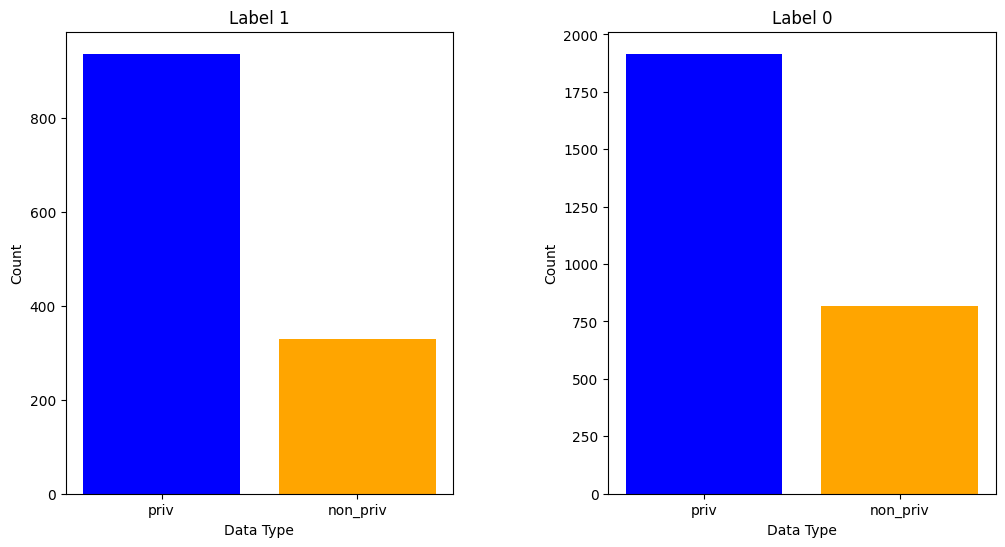

In [14]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

plt.savefig('plot_original_ratios.jpg')


# Show the plots
plt.show()

In [15]:
orig_data

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
1,0,1,German,Golf,67,False,True,False,False,2,True,bachelor,A,0
2,1,0,Dutch,Running,67,False,True,True,False,0,True,master,A,0
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
4,1,1,German,Golf,59,False,False,False,False,1,False,master,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,Dutch,Running,63,False,False,False,False,0,False,master,D,0
3996,1,1,Dutch,Tennis,62,False,False,False,True,2,True,bachelor,D,0
3997,0,0,Belgian,Rugby,60,True,False,False,True,2,False,bachelor,D,0
3998,1,0,Dutch,Tennis,66,False,True,False,False,1,True,bachelor,D,0


In [16]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [17]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+fp 64
conf matrix:
  [[368  10]
 [115  71]] 
accuracy:  0.7783687943262412 precision:  0.

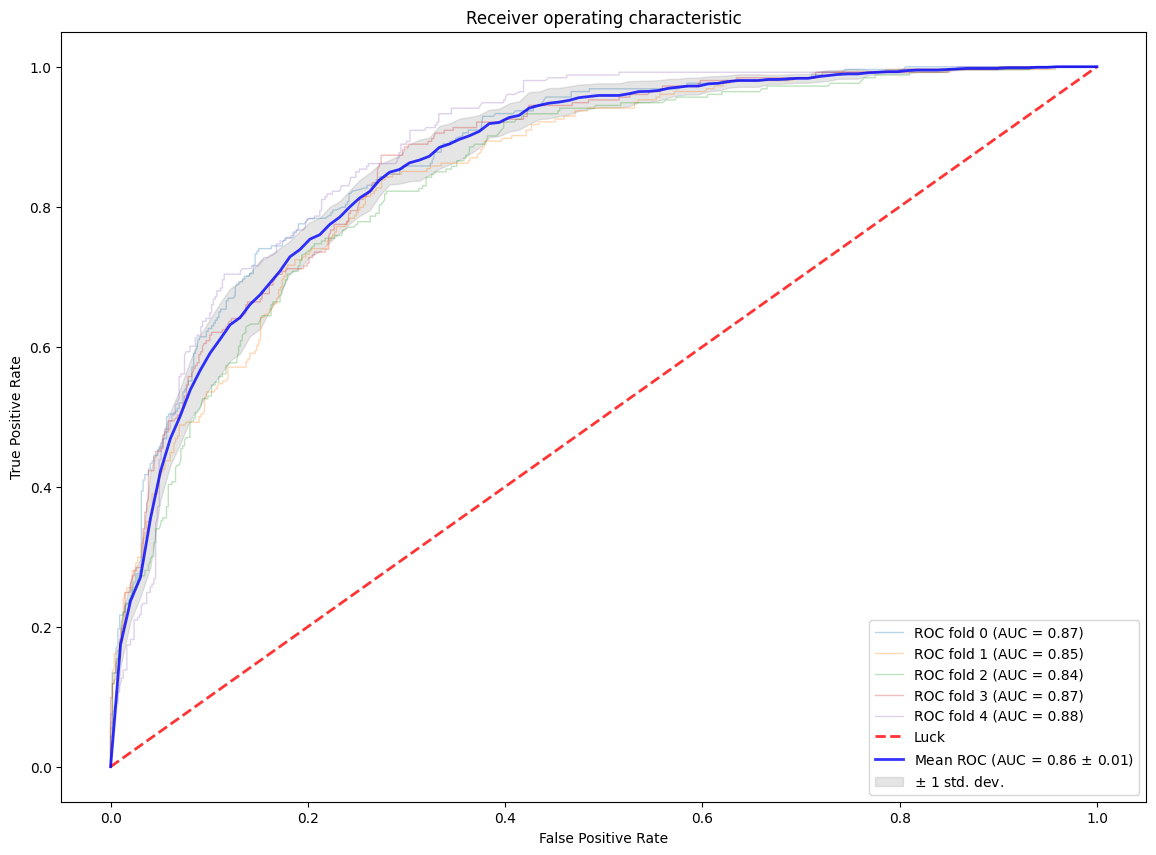

In [18]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

# CTGAN On Priv Target Group

In [19]:
orig_dataset[TARGET_COL] = orig_dataset[TARGET_COL].astype(int)

unprivileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
privileged_data_priv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] == PRIV_CLASS)]
print(unprivileged_data_priv_target.shape[0])
print(privileged_data_priv_target.shape[0])

Accaracy list :  [0.7775, 0.76375, 0.75125, 0.7775, 0.745]
equal opportunity for tpr :  [0.1888533576975788, 0.17583807716635041, 0.06750380517503807, 0.11128775834658189, 0.10873440285204991]
equal opportunity for fpr :  [0.02707189375558677, 0.03306878306878307, 0.007937285644292018, 0.009090618609406957, 0.004696176423925114]
odds difference list :  [0.10796262572658279, 0.10445343011756675, 0.037720545409665046, 0.060189188477994426, 0.05671528963798751]
The mean accuracy is  0.763 ± 0.013
The mean equal opportunity for tpr: (close to 0) 0.130 ± 0.045
The mean equal opportunity for fpr: (close to 0) 0.016 ± 0.011
The mean odds difference: (close to 0) 0.073 ± 0.028
The mean parity difference: (close to 0) 0.581 ± 0.085
The mean disperate impact: (close to 1) 1.000 ± 0.000
330
937


In [20]:
unprivileged_data_priv_target

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,German,Swimming,70,False,False,False,False,1,True,phd,A,1
3,0,0,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
7,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,A,1
9,0,0,Dutch,Football,55,True,False,False,True,3,False,master,A,1
19,1,0,Belgian,Running,63,False,False,False,False,1,True,bachelor,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,0,0,Dutch,Swimming,67,False,True,False,False,1,True,bachelor,D,1
3936,1,0,Dutch,Golf,72,False,True,False,False,1,True,bachelor,D,1
3955,1,0,Dutch,Swimming,71,False,True,False,False,1,True,master,D,1
3969,0,0,Dutch,Running,75,True,True,False,True,2,True,master,D,1


In [21]:
from ctgan import CTGAN
if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)
else:
    ctgan_priv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_priv_target.fit(privileged_data_priv_target , CATEGORICAL, epochs = 200)


# from ctgan import CTGAN

# if unprivileged_data_priv_target.shape[0] < privileged_data_priv_target.shape[0]:
#     ctgan_priv_target = CTGAN(verbose=True)
#     # Fit the synthesizer to the unprivileged features
#     ctgan_priv_target.fit(unprivileged_data_priv_target , CATEGORICAL, epochs = 200)


Gen. (0.06) | Discrim. (0.02): 100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


# CTGAN On Unpriv Target Group

In [22]:
unprivileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] != PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]
privileged_data_unpriv_target = orig_dataset[(orig_dataset[PRIV_FEATURE] == PRIV_VALUE_FEATURE ) & (orig_dataset[TARGET_COL] != PRIV_CLASS)]

print(unprivileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0])
print(privileged_data_unpriv_target.shape[0]-unprivileged_data_unpriv_target.shape[0])

817
1916
1099


In [23]:
from ctgan import CTGAN
if unprivileged_data_unpriv_target.shape[0] <= privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(unprivileged_data_unpriv_target , CATEGORICAL, epochs = 200)

if unprivileged_data_unpriv_target.shape[0] > privileged_data_unpriv_target.shape[0]:
    ctgan_unpriv_target = CTGAN(verbose=True)
    # Fit the synthesizer to the unprivileged features
    ctgan_unpriv_target.fit(privileged_data_unpriv_target , CATEGORICAL, epochs = 200)


Gen. (-0.32) | Discrim. (-0.10): 100%|██████████| 200/200 [00:20<00:00,  9.81it/s]


In [24]:
orig_dataset = pd.concat([orig_data_encoded, y_orig], axis=1)
orig_dataset

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,1,0,0.310777,0.291727,70,0.270350,0.323162,0.291976,0.274256,1,0.294435,0.453441,0.424,1
1,0,1,0.310777,0.275542,67,0.270350,0.303125,0.291976,0.274256,2,0.294435,0.204637,0.424,0
2,1,0,0.318598,0.207120,67,0.270350,0.303125,0.402453,0.274256,0,0.294435,0.423403,0.424,0
3,0,0,0.318598,0.299674,70,0.270350,0.303125,0.291976,0.274256,1,0.294435,0.423403,0.424,1
4,1,1,0.310777,0.275542,59,0.270350,0.323162,0.291976,0.274256,1,0.335970,0.423403,0.424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,0.318598,0.207120,63,0.270350,0.323162,0.291976,0.274256,0,0.335970,0.423403,0.276,0
3996,1,1,0.318598,0.318284,62,0.270350,0.323162,0.291976,0.461454,2,0.294435,0.204637,0.276,0
3997,0,0,0.308756,0.401481,60,0.467588,0.323162,0.291976,0.461454,2,0.335970,0.204637,0.276,0
3998,1,0,0.318598,0.318284,66,0.270350,0.303125,0.291976,0.274256,1,0.294435,0.204637,0.276,0


In [25]:
print(DATASET_NAME)

RECRUIT_AGE


Optuna FairUS

In [26]:
def Upsampling_Dataset(lambda_0, lambda_1):
    priv_target_samples = ctgan_priv_target.sample(math.floor(lambda_0 * (abs(privileged_data_priv_target.shape[0] - unprivileged_data_priv_target.shape[0]))))
    #print(priv_target_samples)
    # print('number of samples i added(lambda_0)', len(priv_target_samples))
    y_priv = priv_target_samples[TARGET_COL]
    priv_target_samples = priv_target_samples.loc[:, feature_columns]

    priv_target_samples = encoder.transform(priv_target_samples)
    priv_target_samples = pd.concat([priv_target_samples, y_priv], axis=1)

    unpriv_target_samples = ctgan_unpriv_target.sample(math.floor(lambda_1 * (abs(privileged_data_unpriv_target.shape[0] - unprivileged_data_unpriv_target.shape[0]))))
    # print('number of samples i added(lambda_1)', len(unpriv_target_samples))
    y_unpriv = unpriv_target_samples[TARGET_COL]
    unpriv_target_samples = unpriv_target_samples.loc[:, feature_columns]

    unpriv_target_samples = encoder.transform(unpriv_target_samples)
    unpriv_target_samples = pd.concat([unpriv_target_samples, y_unpriv], axis=1)

    if len((priv_target_samples)>0) and (len(unpriv_target_samples)==0):
        df_list = [orig_dataset, priv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(unpriv_target_samples)>0) and (len(priv_target_samples)==0):
        df_list = [orig_dataset, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_debias = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)>0) and (len(unpriv_target_samples)>0):
        df_list = [orig_dataset, priv_target_samples, unpriv_target_samples]  # List of your dataframes
        upsampled_df = pd.concat(df_list)
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    if (len(priv_target_samples)==0) and (len(unpriv_target_samples)==0):
        upsampled_df = orig_dataset
        y_upsampled = upsampled_df[TARGET_COL]
        upsampled_df_features = upsampled_df.loc[:, feature_columns]

    return upsampled_df


In [27]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [28]:
!pip install cmaes


In [29]:
import optuna


In [30]:
all_upsampled_acc = []
all_upsampled_od_diff = []

def FairUS_Finding_Optimal_Lambdas_Optuna(trial):

    # Initialize original Equalized odds and Accuracy Scores
    orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact = fairness_metrics_roc_auc_no_print(orig_data_encoded, y_orig)

    OrigFair_score = mean(orig_od_diff)
    OrigAcc_score = mean(orig_acc)

    # Initialize matrices to store Fairness and Accuracy results
    #Fairness_Matrix = np.zeros((num_steps, num_steps))
    #Accuracy_Matrix = np.zeros((num_steps, num_steps))

    lambda_0 =  trial.suggest_float("lambda_0", 0, 2)
    lambda_1 =  trial.suggest_float("lambda_1", 0, 2)

    upsampled_df = Upsampling_Dataset(lambda_0, lambda_1)
    y_debias = upsampled_df[TARGET_COL]
    upsampled_df_features = upsampled_df.loc[:, feature_columns]

    upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact = fairness_metrics_roc_auc_no_print(upsampled_df_features, y_debias)

    CurrFair_score = mean(upsampled_od_diff)
    CurrAcc_score = mean(upsampled_acc)
    # if ALPHA == 1:
    #   optimization_objective = CurrFair_score/mean(orig_od_diff)
    # else:
      # optimization_objective = (ALPHA*CurrFair_score/mean(orig_od_diff)) - ((1-ALPHA)*CurrAcc_score/mean(orig_acc))
    optimization_objective = (CurrFair_score/mean(orig_od_diff)) - (CurrAcc_score/mean(orig_acc))
    # optimization_objective = (CurrFair_score) - (CurrAcc_score)

    # Update fairness matrix with Equalized odds subtraction
    #Fairness_Matrix[i, j] = -(CurrFair_score - OrigFair_score)
    # Update accuracy matrix with Minos accuracy subtraction
    #Accuracy_Matrix[i, j] = (CurrAcc_score - OrigAcc_score)


    #fairness_delta = np.max(Fairness_Matrix)-np.min(Fairness_Matrix)
    #acc_delta = np.max(Accuracy_Matrix)-np.min(Accuracy_Matrix)
    #fairness_factor = acc_delta / fairness_delta
    #scaled_fairness_matrix = fairness_factor * Fairness_Matrix


    #Accuracy_Matrix = -(Accuracy_Matrix)
    #scaled_fairness_matrix= -(scaled_fairness_matrix)
    print ('lambda_0:',lambda_0)
    print ('lambda_1:',lambda_1)
    #print ('fairness matrix before scaling: ',Fairness_Matrix)
    #print ('fairness matrix after scaling: ',scaled_fairness_matrix)
    #print ('acc matrix is: ', Accuracy_Matrix)

    # Save upsampled_acc and upsampled_op_diff as trial attributes
    upsampled_acc = mean(upsampled_acc)
    upsampled_od_diff = mean(upsampled_od_diff)
    trial.set_user_attr('upsampled_acc', upsampled_acc)
    trial.set_user_attr('upsampled_op_diff', upsampled_od_diff)
    print('---------------------------------------trail upsampled_acc is : ', trial.user_attrs.get('upsampled_acc'))
    print('---------------------------------------trail upsampled_op_diff is : ', trial.user_attrs.get('upsampled_op_diff'))
    all_upsampled_acc.append(upsampled_acc)
    all_upsampled_od_diff.append(upsampled_od_diff)

    # Return optimal dataset upsampled with lambda_0, lambda_1 values
    # return optimization_objective #scaled_fairness_matrix
    return CurrFair_score, CurrAcc_score #for multi objective


In [31]:
# Record the start time
start_time = time.time()

In [37]:
CME_flag = False

if CME_flag:
  from optuna.samplers import CmaEsSampler

  # Create an instance of CmaEsSampler
  # Create an instance of CmaEsSampler with specified parameters
  cma_es_sampler = CmaEsSampler(
      sigma0=0.01,  # Initial standard deviation of the distribution.
      n_startup_trials=10,  # The number of trials before using CMA-ES.
      independent_sampler=optuna.samplers.RandomSampler(seed=0)  # Sampler used for the first `n_startup_trials`.
  )


  # Pass the instance of CmaEsSampler to create_study
  # study = optuna.create_study(sampler=cma_es_sampler, direction='minimize')
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=400)
else:
  from optuna.samplers import TPESampler

  # Create an instance of TPESampler with custom parameters
  # You can adjust parameters like n_startup_trials, n_ei_candidates, etc.
  tpe_sampler = TPESampler(n_startup_trials=20, n_ei_candidates=24, multivariate=True)

  # Pass the instance of TPESampler to create_study
  # study = optuna.create_study(sampler=tpe_sampler, direction='minimize') #directions=['minimize', 'maximize']
  study = optuna.create_study(sampler=tpe_sampler, directions=['minimize', 'maximize']) #

  study.optimize(FairUS_Finding_Optimal_Lambdas_Optuna, n_trials=200)

/usr/local/lib/python3.10/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-02 08:54:48,091] A new study created in memory with name: no-name-c9314a75-c1a8-4b3b-96f2-8e036b436896


conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+fp 64
conf matrix:
  [[368  10]
 [115  71]] 
accuracy:  0.7783687943262412 precision:  0.

[I 2024-04-02 08:54:49,272] Trial 0 finished with values: [0.18912737513900016, 0.7771477663230241] and parameters: {'lambda_0': 1.395360446427695, 'lambda_1': 0.8865382105732238}. 


conf matrix:
  [[318  32]
 [ 78 160]] 
accuracy:  0.8129251700680272 precision:  0.8333333333333334 recall:  0.6722689075630253 fpr:  0.09142857142857143 tpr:  0.6722689075630253 fn+fp 110
lambda_0: 1.395360446427695
lambda_1: 0.8865382105732238
---------------------------------------trail upsampled_acc is :  0.7771477663230241
---------------------------------------trail upsampled_op_diff is :  0.18912737513900016
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169 

[I 2024-04-02 08:54:50,500] Trial 1 finished with values: [0.22428462307810312, 0.7777774589528897] and parameters: {'lambda_0': 1.0962680438862162, 'lambda_1': 0.4069578770838216}. 


conf matrix:
  [[350  21]
 [132  66]] 
accuracy:  0.7311072056239016 precision:  0.7586206896551724 recall:  0.3333333333333333 fpr:  0.05660377358490566 tpr:  0.3333333333333333 fn+fp 153
conf matrix:
  [[593  43]
 [172 214]] 
accuracy:  0.7896281800391389 precision:  0.8326848249027238 recall:  0.5544041450777202 fpr:  0.06761006289308176 tpr:  0.5544041450777202 fn+fp 215
conf matrix:
  [[212  23]
 [ 55 154]] 
accuracy:  0.8243243243243243 precision:  0.8700564971751412 recall:  0.7368421052631579 fpr:  0.09787234042553192 tpr:  0.7368421052631579 fn+fp 78
conf matrix:
  [[381  20]
 [117  60]] 
accuracy:  0.7629757785467128 precision:  0.75 recall:  0.3389830508474576 fpr:  0.04987531172069826 tpr:  0.3389830508474576 fn+fp 137
conf matrix:
  [[579  57]
 [178 208]] 
accuracy:  0.7700587084148728 precision:  0.7849056603773585 recall:  0.538860103626943 fpr:  0.08962264150943396 tpr:  0.538860103626943 fn+fp 235
conf matrix:
  [[339  25]
 [123  55]] 
accuracy:  0.7269372693726938 pre

[I 2024-04-02 08:54:51,588] Trial 2 finished with values: [0.03192598965263299, 0.7758370142162503] and parameters: {'lambda_0': 0.24597880882888234, 'lambda_1': 0.45078514919136636}. 


conf matrix:
  [[625  21]
 [198  85]] 
accuracy:  0.7642626480086114 precision:  0.8018867924528302 recall:  0.3003533568904594 fpr:  0.032507739938080496 tpr:  0.3003533568904594 fn+fp 219
conf matrix:
  [[380  14]
 [134  55]] 
accuracy:  0.7461406518010292 precision:  0.7971014492753623 recall:  0.291005291005291 fpr:  0.03553299492385787 tpr:  0.291005291005291 fn+fp 148
conf matrix:
  [[245   7]
 [ 64  30]] 
accuracy:  0.7947976878612717 precision:  0.8108108108108109 recall:  0.3191489361702128 fpr:  0.027777777777777776 tpr:  0.3191489361702128 fn+fp 71
conf matrix:
  [[625  20]
 [200  83]] 
accuracy:  0.7629310344827587 precision:  0.8058252427184466 recall:  0.29328621908127206 fpr:  0.031007751937984496 tpr:  0.29328621908127206 fn+fp 220
conf matrix:
  [[353  14]
 [126  61]] 
accuracy:  0.7472924187725631 precision:  0.8133333333333334 recall:  0.32620320855614976 fpr:  0.03814713896457766 tpr:  0.32620320855614976 fn+fp 140
conf matrix:
  [[272   6]
 [ 74  22]] 
accuracy:  0

[I 2024-04-02 08:54:52,600] Trial 3 finished with values: [0.09242005320240297, 0.7720754136797802] and parameters: {'lambda_0': 0.38186723551374, 'lambda_1': 0.03509642153850012}. 


conf matrix:
  [[533  22]
 [146 153]] 
accuracy:  0.8032786885245902 precision:  0.8742857142857143 recall:  0.5117056856187291 fpr:  0.03963963963963964 tpr:  0.5117056856187291 fn+fp 168
conf matrix:
  [[352  14]
 [109  87]] 
accuracy:  0.7811387900355872 precision:  0.8613861386138614 recall:  0.44387755102040816 fpr:  0.03825136612021858 tpr:  0.44387755102040816 fn+fp 123
conf matrix:
  [[181   8]
 [ 37  66]] 
accuracy:  0.8458904109589042 precision:  0.8918918918918919 recall:  0.6407766990291263 fpr:  0.042328042328042326 tpr:  0.6407766990291263 fn+fp 45
conf matrix:
  [[526  28]
 [175 124]] 
accuracy:  0.7620164126611958 precision:  0.8157894736842105 recall:  0.41471571906354515 fpr:  0.05054151624548736 tpr:  0.41471571906354515 fn+fp 203
conf matrix:
  [[362  13]
 [111  66]] 
accuracy:  0.7753623188405797 precision:  0.8354430379746836 recall:  0.3728813559322034 fpr:  0.034666666666666665 tpr:  0.3728813559322034 fn+fp 124
conf matrix:
  [[164  15]
 [ 64  58]] 
accuracy:  

[I 2024-04-02 08:54:53,800] Trial 4 finished with values: [0.08432862303033271, 0.7953313253012049] and parameters: {'lambda_0': 0.8956586015754293, 'lambda_1': 1.9088974964720344}. 


conf matrix:
  [[400  13]
 [125  47]] 
accuracy:  0.764102564102564 precision:  0.7833333333333333 recall:  0.27325581395348836 fpr:  0.031476997578692496 tpr:  0.27325581395348836 fn+fp 138
conf matrix:
  [[925  41]
 [241 121]] 
accuracy:  0.7876506024096386 precision:  0.7469135802469136 recall:  0.3342541436464088 fpr:  0.042443064182194616 tpr:  0.3342541436464088 fn+fp 282
conf matrix:
  [[583  20]
 [110  74]] 
accuracy:  0.8348157560355781 precision:  0.7872340425531915 recall:  0.40217391304347827 fpr:  0.03316749585406302 tpr:  0.40217391304347827 fn+fp 130
conf matrix:
  [[342  21]
 [131  47]] 
accuracy:  0.7190388170055453 precision:  0.6911764705882353 recall:  0.2640449438202247 fpr:  0.05785123966942149 tpr:  0.2640449438202247 fn+fp 152
conf matrix:
  [[944  22]
 [246 116]] 
accuracy:  0.7981927710843374 precision:  0.8405797101449275 recall:  0.32044198895027626 fpr:  0.022774327122153208 tpr:  0.32044198895027626 fn+fp 268
conf matrix:
  [[369   7]
 [138  47]] 
accuracy

[I 2024-04-02 08:54:55,104] Trial 5 finished with values: [0.06773708625579615, 0.7800915613213348] and parameters: {'lambda_0': 0.6113352282145359, 'lambda_1': 1.1788976692793889}. 


conf matrix:
  [[780  26]
 [228  99]] 
accuracy:  0.7758164165931156 precision:  0.792 recall:  0.30275229357798167 fpr:  0.03225806451612903 tpr:  0.30275229357798167 fn+fp 254
conf matrix:
  [[360   7]
 [157  42]] 
accuracy:  0.7102473498233216 precision:  0.8571428571428571 recall:  0.21105527638190955 fpr:  0.01907356948228883 tpr:  0.21105527638190955 fn+fp 164
conf matrix:
  [[420  19]
 [ 71  57]] 
accuracy:  0.8412698412698413 precision:  0.75 recall:  0.4453125 fpr:  0.04328018223234624 tpr:  0.4453125 fn+fp 90
lambda_0: 0.6113352282145359
lambda_1: 1.1788976692793889
---------------------------------------trail upsampled_acc is :  0.7800915613213348
---------------------------------------trail upsampled_op_diff is :  0.06773708625579615
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.77108433734939

[I 2024-04-02 08:54:56,614] Trial 6 finished with values: [0.053103813290874415, 0.7956926457369244] and parameters: {'lambda_0': 0.425361125379208, 'lambda_1': 1.7019353070107242}. 


conf matrix:
  [[909  11]
 [221  84]] 
accuracy:  0.8106122448979591 precision:  0.8842105263157894 recall:  0.2754098360655738 fpr:  0.011956521739130435 tpr:  0.2754098360655738 fn+fp 232
conf matrix:
  [[527   3]
 [ 99  22]] 
accuracy:  0.8433179723502304 precision:  0.88 recall:  0.18181818181818182 fpr:  0.005660377358490566 tpr:  0.18181818181818182 fn+fp 102
conf matrix:
  [[382   8]
 [122  62]] 
accuracy:  0.7735191637630662 precision:  0.8857142857142857 recall:  0.33695652173913043 fpr:  0.020512820512820513 tpr:  0.33695652173913043 fn+fp 130
lambda_0: 0.425361125379208
lambda_1: 1.7019353070107242
---------------------------------------trail upsampled_acc is :  0.7956926457369244
---------------------------------------trail upsampled_op_diff is :  0.053103813290874415
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118

[I 2024-04-02 08:54:57,843] Trial 7 finished with values: [0.1036285858479853, 0.7858254105445117] and parameters: {'lambda_0': 0.7645560691498643, 'lambda_1': 1.2022301489013796}. 


conf matrix:
  [[781  30]
 [225 121]] 
accuracy:  0.7796024200518582 precision:  0.8013245033112583 recall:  0.34971098265895956 fpr:  0.036991368680641186 tpr:  0.34971098265895956 fn+fp 255
conf matrix:
  [[354  17]
 [136  54]] 
accuracy:  0.7272727272727273 precision:  0.7605633802816901 recall:  0.28421052631578947 fpr:  0.04582210242587601 tpr:  0.28421052631578947 fn+fp 153
conf matrix:
  [[427  13]
 [ 89  67]] 
accuracy:  0.8288590604026845 precision:  0.8375 recall:  0.42948717948717946 fpr:  0.029545454545454545 tpr:  0.42948717948717946 fn+fp 102
conf matrix:
  [[776  35]
 [214 132]] 
accuracy:  0.7847882454624028 precision:  0.7904191616766467 recall:  0.3815028901734104 fpr:  0.04315659679408138 tpr:  0.3815028901734104 fn+fp 249
conf matrix:
  [[416  16]
 [ 69  82]] 
accuracy:  0.8542024013722127 precision:  0.8367346938775511 recall:  0.543046357615894 fpr:  0.037037037037037035 tpr:  0.543046357615894 fn+fp 85
conf matrix:
  [[360  19]
 [145  50]] 
accuracy:  0.714285714

[I 2024-04-02 08:54:58,990] Trial 8 finished with values: [0.1579555069515305, 0.7833927417120694] and parameters: {'lambda_0': 1.3262213887497076, 'lambda_1': 1.425679719522228}. 


conf matrix:
  [[435  36]
 [ 85 140]] 
accuracy:  0.8261494252873564 precision:  0.7954545454545454 recall:  0.6222222222222222 fpr:  0.07643312101910828 tpr:  0.6222222222222222 fn+fp 121
conf matrix:
  [[819  41]
 [235 179]] 
accuracy:  0.783359497645212 precision:  0.8136363636363636 recall:  0.4323671497584541 fpr:  0.047674418604651166 tpr:  0.4323671497584541 fn+fp 276
conf matrix:
  [[486  22]
 [106 132]] 
accuracy:  0.8284182305630027 precision:  0.8571428571428571 recall:  0.5546218487394958 fpr:  0.04330708661417323 tpr:  0.5546218487394958 fn+fp 128
conf matrix:
  [[333  19]
 [129  47]] 
accuracy:  0.7196969696969697 precision:  0.7121212121212122 recall:  0.26704545454545453 fpr:  0.05397727272727273 tpr:  0.26704545454545453 fn+fp 148
conf matrix:
  [[817  43]
 [241 173]] 
accuracy:  0.7770800627943485 precision:  0.8009259259259259 recall:  0.4178743961352657 fpr:  0.05 tpr:  0.4178743961352657 fn+fp 284
conf matrix:
  [[430  20]
 [103 125]] 
accuracy:  0.8185840707964602

[I 2024-04-02 08:55:00,150] Trial 9 finished with values: [0.19007349740904003, 0.783783366392062] and parameters: {'lambda_0': 1.6991703868236816, 'lambda_1': 1.2808325093892803}. 


conf matrix:
  [[780  48]
 [224 235]] 
accuracy:  0.7886557886557887 precision:  0.8303886925795053 recall:  0.5119825708061002 fpr:  0.057971014492753624 tpr:  0.5119825708061002 fn+fp 272
conf matrix:
  [[347  11]
 [135  57]] 
accuracy:  0.7345454545454545 precision:  0.8382352941176471 recall:  0.296875 fpr:  0.030726256983240222 tpr:  0.296875 fn+fp 146
conf matrix:
  [[433  37]
 [ 89 178]] 
accuracy:  0.8290366350067843 precision:  0.827906976744186 recall:  0.6666666666666666 fpr:  0.07872340425531915 tpr:  0.6666666666666666 fn+fp 126
conf matrix:
  [[776  52]
 [236 223]] 
accuracy:  0.7762237762237763 precision:  0.8109090909090909 recall:  0.485838779956427 fpr:  0.06280193236714976 tpr:  0.485838779956427 fn+fp 288
conf matrix:
  [[371  15]
 [131  52]] 
accuracy:  0.7434094903339191 precision:  0.7761194029850746 recall:  0.28415300546448086 fpr:  0.038860103626943004 tpr:  0.28415300546448086 fn+fp 146
conf matrix:
  [[405  37]
 [105 171]] 
accuracy:  0.8022284122562674 prec

[I 2024-04-02 08:55:01,238] Trial 10 finished with values: [0.10350917397598416, 0.7820449352627571] and parameters: {'lambda_0': 1.062528521660244, 'lambda_1': 1.7443354397776647}. 


 recall:  0.23834196891191708 fpr:  0.03316326530612245 tpr:  0.23834196891191708 fn+fp 160
conf matrix:
  [[897  33]
 [250 132]] 
accuracy:  0.7842987804878049 precision:  0.8 recall:  0.34554973821989526 fpr:  0.035483870967741936 tpr:  0.34554973821989526 fn+fp 283
conf matrix:
  [[358  13]
 [144  37]] 
accuracy:  0.7155797101449275 precision:  0.74 recall:  0.20441988950276244 fpr:  0.03504043126684636 tpr:  0.20441988950276244 fn+fp 157
conf matrix:
  [[539  20]
 [106  95]] 
accuracy:  0.8342105263157895 precision:  0.8260869565217391 recall:  0.472636815920398 fpr:  0.03577817531305903 tpr:  0.472636815920398 fn+fp 126
conf matrix:
  [[894  36]
 [256 126]] 
accuracy:  0.7774390243902439 precision:  0.7777777777777778 recall:  0.3298429319371728 fpr:  0.03870967741935484 tpr:  0.3298429319371728 fn+fp 292
conf matrix:
  [[518  20]
 [134  78]] 
accuracy:  0.7946666666666666 precision:  0.7959183673469388 recall:  0.36792452830188677 fpr:  0.03717472118959108 tpr:  0.367924528301886

[I 2024-04-02 08:55:02,299] Trial 11 finished with values: [0.1124572461770696, 0.8097666811405413] and parameters: {'lambda_0': 0.08375120860656748, 'lambda_1': 1.6627436627372818}. 


conf matrix:
  [[898  14]
 [210  53]] 
accuracy:  0.8093617021276596 precision:  0.7910447761194029 recall:  0.20152091254752852 fpr:  0.015350877192982455 tpr:  0.20152091254752852 fn+fp 224
conf matrix:
  [[358  12]
 [139  46]] 
accuracy:  0.7279279279279279 precision:  0.7931034482758621 recall:  0.24864864864864866 fpr:  0.032432432432432434 tpr:  0.24864864864864866 fn+fp 151
conf matrix:
  [[540   2]
 [ 71   7]] 
accuracy:  0.882258064516129 precision:  0.7777777777777778 recall:  0.08974358974358974 fpr:  0.0036900369003690036 tpr:  0.08974358974358974 fn+fp 73
conf matrix:
  [[891  21]
 [201  62]] 
accuracy:  0.811063829787234 precision:  0.7469879518072289 recall:  0.23574144486692014 fpr:  0.023026315789473683 tpr:  0.23574144486692014 fn+fp 222
conf matrix:
  [[527   1]
 [ 80   3]] 
accuracy:  0.867430441898527 precision:  0.75 recall:  0.03614457831325301 fpr:  0.001893939393939394 tpr:  0.03614457831325301 fn+fp 81
conf matrix:
  [[364  20]
 [121  59]] 
accuracy:  0.75 pre

[I 2024-04-02 08:55:03,515] Trial 12 finished with values: [0.13408284838311615, 0.7977994286235724] and parameters: {'lambda_0': 1.3035432455531224, 'lambda_1': 1.5899295267945346}. 


conf matrix:
  [[362  20]
 [121  68]] 
accuracy:  0.7530647985989493 precision:  0.7727272727272727 recall:  0.35978835978835977 fpr:  0.05235602094240838 tpr:  0.35978835978835977 fn+fp 141
conf matrix:
  [[488  26]
 [ 83 139]] 
accuracy:  0.8519021739130435 precision:  0.8424242424242424 recall:  0.6261261261261262 fpr:  0.05058365758754864 tpr:  0.6261261261261262 fn+fp 109
lambda_0: 1.3035432455531224
lambda_1: 1.5899295267945346
---------------------------------------trail upsampled_acc is :  0.7977994286235724
---------------------------------------trail upsampled_op_diff is :  0.13408284838311615
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43

[I 2024-04-02 08:55:04,520] Trial 13 finished with values: [0.026314281480782988, 0.7679466074740599] and parameters: {'lambda_0': 0.28260866030565657, 'lambda_1': 0.28737760935484724}. 


conf matrix:
  [[577  33]
 [176 111]] 
accuracy:  0.7670011148272018 precision:  0.7708333333333334 recall:  0.3867595818815331 fpr:  0.054098360655737705 tpr:  0.3867595818815331 fn+fp 209
conf matrix:
  [[232  14]
 [ 48  38]] 
accuracy:  0.8132530120481928 precision:  0.7307692307692307 recall:  0.4418604651162791 fpr:  0.056910569105691054 tpr:  0.4418604651162791 fn+fp 62
conf matrix:
  [[345  19]
 [128  73]] 
accuracy:  0.7398230088495575 precision:  0.7934782608695652 recall:  0.36318407960199006 fpr:  0.0521978021978022 tpr:  0.36318407960199006 fn+fp 147
conf matrix:
  [[589  21]
 [173 114]] 
accuracy:  0.7837235228539576 precision:  0.8444444444444444 recall:  0.397212543554007 fpr:  0.03442622950819672 tpr:  0.397212543554007 fn+fp 194
conf matrix:
  [[203   5]
 [ 64  44]] 
accuracy:  0.7816455696202531 precision:  0.8979591836734694 recall:  0.4074074074074074 fpr:  0.02403846153846154 tpr:  0.4074074074074074 fn+fp 69
conf matrix:
  [[386  16]
 [109  70]] 
accuracy:  0.7848

[I 2024-04-02 08:55:05,570] Trial 14 finished with values: [0.09664738422998756, 0.7887812653082114] and parameters: {'lambda_0': 0.695881044823248, 'lambda_1': 1.297526534285717}. 


conf matrix:
  [[803  28]
 [217 121]] 
accuracy:  0.7904191616766467 precision:  0.8120805369127517 recall:  0.35798816568047337 fpr:  0.03369434416365824 tpr:  0.35798816568047337 fn+fp 245
conf matrix:
  [[359  17]
 [141  46]] 
accuracy:  0.7193605683836589 precision:  0.7301587301587301 recall:  0.24598930481283424 fpr:  0.04521276595744681 tpr:  0.24598930481283424 fn+fp 158
conf matrix:
  [[444  11]
 [ 76  75]] 
accuracy:  0.8564356435643564 precision:  0.872093023255814 recall:  0.4966887417218543 fpr:  0.024175824175824177 tpr:  0.4966887417218543 fn+fp 87
conf matrix:
  [[813  19]
 [224 113]] 
accuracy:  0.7921300256629598 precision:  0.8560606060606061 recall:  0.3353115727002967 fpr:  0.02283653846153846 tpr:  0.3353115727002967 fn+fp 243
conf matrix:
  [[370   3]
 [145  45]] 
accuracy:  0.7371225577264654 precision:  0.9375 recall:  0.23684210526315788 fpr:  0.00804289544235925 tpr:  0.23684210526315788 fn+fp 148
conf matrix:
  [[443  16]
 [ 79  68]] 
accuracy:  0.8432343234

[I 2024-04-02 08:55:06,758] Trial 15 finished with values: [0.15206668750436844, 0.7780041318918666] and parameters: {'lambda_0': 1.2361128815134326, 'lambda_1': 0.9900741777191984}. 


conf matrix:
  [[367  22]
 [134  58]] 
accuracy:  0.7314974182444062 precision:  0.725 recall:  0.3020833333333333 fpr:  0.056555269922879174 tpr:  0.3020833333333333 fn+fp 156
lambda_0: 1.2361128815134326
lambda_1: 0.9900741777191984
---------------------------------------trail upsampled_acc is :  0.7780041318918666
---------------------------------------trail upsampled_op_diff is :  0.15206668750436844
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accu

[I 2024-04-02 08:55:08,025] Trial 16 finished with values: [0.05983956060548321, 0.7668415529905561] and parameters: {'lambda_0': 0.36980389860573837, 'lambda_1': 0.4931203808566056}. 


conf matrix:
  [[630  25]
 [195 103]] 
accuracy:  0.7691500524658972 precision:  0.8046875 recall:  0.34563758389261745 fpr:  0.03816793893129771 tpr:  0.34563758389261745 fn+fp 220
conf matrix:
  [[368  14]
 [135  59]] 
accuracy:  0.7413194444444444 precision:  0.8082191780821918 recall:  0.30412371134020616 fpr:  0.03664921465968586 tpr:  0.30412371134020616 fn+fp 149
conf matrix:
  [[262  11]
 [ 60  44]] 
accuracy:  0.8116710875331565 precision:  0.8 recall:  0.4230769230769231 fpr:  0.040293040293040296 tpr:  0.4230769230769231 fn+fp 71
lambda_0: 0.36980389860573837
lambda_1: 0.4931203808566056
---------------------------------------trail upsampled_acc is :  0.7668415529905561
---------------------------------------trail upsampled_op_diff is :  0.05983956060548321
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accu

[I 2024-04-02 08:55:09,552] Trial 17 finished with values: [0.23133594732468218, 0.7764303569302974] and parameters: {'lambda_0': 1.3453146092939574, 'lambda_1': 0.5510754104789988}. 


conf matrix:
  [[626  42]
 [189 227]] 
accuracy:  0.7869003690036901 precision:  0.8438661710037175 recall:  0.5456730769230769 fpr:  0.06287425149700598 tpr:  0.5456730769230769 fn+fp 231
conf matrix:
  [[362  10]
 [133  51]] 
accuracy:  0.7428057553956835 precision:  0.8360655737704918 recall:  0.27717391304347827 fpr:  0.026881720430107527 tpr:  0.27717391304347827 fn+fp 143
conf matrix:
  [[264  32]
 [ 56 176]] 
accuracy:  0.8333333333333334 precision:  0.8461538461538461 recall:  0.7586206896551724 fpr:  0.10810810810810811 tpr:  0.7586206896551724 fn+fp 88
lambda_0: 1.3453146092939574
lambda_1: 0.5510754104789988
---------------------------------------trail upsampled_acc is :  0.7764303569302974
---------------------------------------trail upsampled_op_diff is :  0.23133594732468218
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  

[I 2024-04-02 08:55:10,887] Trial 18 finished with values: [0.18204750519747653, 0.7870822579577791] and parameters: {'lambda_0': 1.700729266966953, 'lambda_1': 1.0716724237709785}. 


conf matrix:
  [[354  44]
 [114  78]] 
accuracy:  0.7322033898305085 precision:  0.639344262295082 recall:  0.40625 fpr:  0.11055276381909548 tpr:  0.40625 fn+fp 158
conf matrix:
  [[357  27]
 [ 87 180]] 
accuracy:  0.8248847926267281 precision:  0.8695652173913043 recall:  0.6741573033707865 fpr:  0.0703125 tpr:  0.6741573033707865 fn+fp 114
lambda_0: 1.700729266966953
lambda_1: 1.0716724237709785
---------------------------------------trail upsampled_acc is :  0.7870822579577791
---------------------------------------trail upsampled_op_diff is :  0.18204750519747653
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.794520547945205

[I 2024-04-02 08:55:11,978] Trial 19 finished with values: [0.31817183800703097, 0.7849476426313567] and parameters: {'lambda_0': 1.5230592485825198, 'lambda_1': 0.0045913165477629025}. 


conf matrix:
  [[501  47]
 [170 268]] 
accuracy:  0.7799188640973631 precision:  0.8507936507936508 recall:  0.6118721461187214 fpr:  0.08576642335766424 tpr:  0.6118721461187214 fn+fp 217
conf matrix:
  [[354  27]
 [128  60]] 
accuracy:  0.7275922671353251 precision:  0.6896551724137931 recall:  0.3191489361702128 fpr:  0.07086614173228346 tpr:  0.3191489361702128 fn+fp 155
conf matrix:
  [[147  20]
 [ 42 208]] 
accuracy:  0.8513189448441247 precision:  0.9122807017543859 recall:  0.832 fpr:  0.11976047904191617 tpr:  0.832 fn+fp 62
conf matrix:
  [[503  44]
 [161 277]] 
accuracy:  0.7918781725888325 precision:  0.8629283489096573 recall:  0.632420091324201 fpr:  0.08043875685557587 tpr:  0.632420091324201 fn+fp 205
conf matrix:
  [[360  16]
 [117  71]] 
accuracy:  0.7641843971631206 precision:  0.8160919540229885 recall:  0.3776595744680851 fpr:  0.0425531914893617 tpr:  0.3776595744680851 fn+fp 133
conf matrix:
  [[143  28]
 [ 44 206]] 
accuracy:  0.828978622327791 precision:  0.880

[I 2024-04-02 08:55:12,979] Trial 20 finished with values: [0.11271311298562536, 0.7843085369962934] and parameters: {'lambda_0': 0.08977024378680737, 'lambda_1': 0.8807882154236413}. 


conf matrix:
  [[734   6]
 [219  45]] 
accuracy:  0.7758964143426295 precision:  0.8823529411764706 recall:  0.17045454545454544 fpr:  0.008108108108108109 tpr:  0.17045454545454544 fn+fp 225
conf matrix:
  [[381   5]
 [138  43]] 
accuracy:  0.7477954144620811 precision:  0.8958333333333334 recall:  0.23756906077348067 fpr:  0.012953367875647668 tpr:  0.23756906077348067 fn+fp 143
conf matrix:
  [[353   1]
 [ 81   2]] 
accuracy:  0.8123569794050344 precision:  0.6666666666666666 recall:  0.024096385542168676 fpr:  0.002824858757062147 tpr:  0.024096385542168676 fn+fp 82
conf matrix:
  [[725  15]
 [189  75]] 
accuracy:  0.796812749003984 precision:  0.8333333333333334 recall:  0.2840909090909091 fpr:  0.02027027027027027 tpr:  0.2840909090909091 fn+fp 204
conf matrix:
  [[362  13]
 [125  69]] 
accuracy:  0.7574692442882249 precision:  0.8414634146341463 recall:  0.3556701030927835 fpr:  0.034666666666666665 tpr:  0.3556701030927835 fn+fp 138
conf matrix:
  [[363   2]
 [ 64   6]] 
accura

[I 2024-04-02 08:55:13,957] Trial 21 finished with values: [0.03202289239762468, 0.7822815951597702] and parameters: {'lambda_0': 0.17588469486675606, 'lambda_1': 0.2803629319239037}. 


conf matrix:
  [[594  15]
 [156 118]] 
accuracy:  0.8063420158550396 precision:  0.8872180451127819 recall:  0.4306569343065693 fpr:  0.024630541871921183 tpr:  0.4306569343065693 fn+fp 171
conf matrix:
  [[378  10]
 [103  87]] 
accuracy:  0.8044982698961938 precision:  0.8969072164948454 recall:  0.45789473684210524 fpr:  0.02577319587628866 tpr:  0.45789473684210524 fn+fp 113
conf matrix:
  [[216   5]
 [ 53  31]] 
accuracy:  0.8098360655737705 precision:  0.8611111111111112 recall:  0.36904761904761907 fpr:  0.02262443438914027 tpr:  0.36904761904761907 fn+fp 58
conf matrix:
  [[591  17]
 [183  91]] 
accuracy:  0.7732426303854876 precision:  0.8425925925925926 recall:  0.33211678832116787 fpr:  0.027960526315789474 tpr:  0.33211678832116787 fn+fp 200
conf matrix:
  [[214   5]
 [ 56  30]] 
accuracy:  0.8 precision:  0.8571428571428571 recall:  0.3488372093023256 fpr:  0.0228310502283105 tpr:  0.3488372093023256 fn+fp 61
conf matrix:
  [[377  12]
 [127  61]] 
accuracy:  0.7590987868284

[I 2024-04-02 08:55:14,961] Trial 22 finished with values: [0.06782082547217634, 0.7899836807338562] and parameters: {'lambda_0': 0.20437009355393052, 'lambda_1': 0.17325789234501554}. 


conf matrix:
  [[570  15]
 [168 110]] 
accuracy:  0.7879490150637312 precision:  0.88 recall:  0.39568345323741005 fpr:  0.02564102564102564 tpr:  0.39568345323741005 fn+fp 183
conf matrix:
  [[375  10]
 [104  77]] 
accuracy:  0.7985865724381626 precision:  0.8850574712643678 recall:  0.425414364640884 fpr:  0.025974025974025976 tpr:  0.425414364640884 fn+fp 114
conf matrix:
  [[195   5]
 [ 64  33]] 
accuracy:  0.7676767676767676 precision:  0.868421052631579 recall:  0.3402061855670103 fpr:  0.025 tpr:  0.3402061855670103 fn+fp 69
conf matrix:
  [[564  20]
 [170 108]] 
accuracy:  0.7795823665893271 precision:  0.84375 recall:  0.38848920863309355 fpr:  0.03424657534246575 tpr:  0.38848920863309355 fn+fp 190
conf matrix:
  [[187   8]
 [ 66  28]] 
accuracy:  0.7439446366782007 precision:  0.7777777777777778 recall:  0.2978723404255319 fpr:  0.041025641025641026 tpr:  0.2978723404255319 fn+fp 74
conf matrix:
  [[377  12]
 [104  80]] 
accuracy:  0.7975567190226877 precision:  0.8695652173

[I 2024-04-02 08:55:16,023] Trial 23 finished with values: [0.15012696337885867, 0.7804950483106355] and parameters: {'lambda_0': 0.6916344309012872, 'lambda_1': 0.12097954865444763}. 


conf matrix:
  [[531  42]
 [148 189]] 
accuracy:  0.7912087912087912 precision:  0.8181818181818182 recall:  0.5608308605341247 fpr:  0.07329842931937172 tpr:  0.5608308605341247 fn+fp 190
conf matrix:
  [[167  21]
 [ 39 111]] 
accuracy:  0.8224852071005917 precision:  0.8409090909090909 recall:  0.74 fpr:  0.11170212765957446 tpr:  0.74 fn+fp 60
conf matrix:
  [[364  21]
 [109  78]] 
accuracy:  0.7727272727272727 precision:  0.7878787878787878 recall:  0.41711229946524064 fpr:  0.05454545454545454 tpr:  0.41711229946524064 fn+fp 130
conf matrix:
  [[535  38]
 [144 193]] 
accuracy:  0.8 precision:  0.8354978354978355 recall:  0.5727002967359051 fpr:  0.06631762652705062 tpr:  0.5727002967359051 fn+fp 182
conf matrix:
  [[165  14]
 [ 49 104]] 
accuracy:  0.8102409638554217 precision:  0.8813559322033898 recall:  0.6797385620915033 fpr:  0.0782122905027933 tpr:  0.6797385620915033 fn+fp 63
conf matrix:
  [[370  24]
 [ 95  89]] 
accuracy:  0.7941176470588235 precision:  0.7876106194690266

[I 2024-04-02 08:55:17,092] Trial 24 finished with values: [0.11032771053005086, 0.7697145688307863] and parameters: {'lambda_0': 0.6894294433049885, 'lambda_1': 0.6314730950005758}. 


conf matrix:
  [[655  30]
 [204 133]] 
accuracy:  0.7710371819960861 precision:  0.8159509202453987 recall:  0.39465875370919884 fpr:  0.043795620437956206 tpr:  0.39465875370919884 fn+fp 234
conf matrix:
  [[368  20]
 [119  60]] 
accuracy:  0.7548500881834215 precision:  0.75 recall:  0.33519553072625696 fpr:  0.05154639175257732 tpr:  0.33519553072625696 fn+fp 139
conf matrix:
  [[287  10]
 [ 85  73]] 
accuracy:  0.7912087912087912 precision:  0.8795180722891566 recall:  0.4620253164556962 fpr:  0.03367003367003367 tpr:  0.4620253164556962 fn+fp 95
conf matrix:
  [[665  20]
 [214 123]] 
accuracy:  0.7710371819960861 precision:  0.8601398601398601 recall:  0.3649851632047478 fpr:  0.029197080291970802 tpr:  0.3649851632047478 fn+fp 234
conf matrix:
  [[301  10]
 [ 69  78]] 
accuracy:  0.8275109170305677 precision:  0.8863636363636364 recall:  0.5306122448979592 fpr:  0.03215434083601286 tpr:  0.5306122448979592 fn+fp 79
conf matrix:
  [[364  10]
 [145  45]] 
accuracy:  0.7251773049645

[I 2024-04-02 08:55:18,099] Trial 25 finished with values: [0.08867726573632356, 0.7816017316017316] and parameters: {'lambda_0': 0.02366734297778339, 'lambda_1': 0.552169997423734}. 


conf matrix:
  [[659   9]
 [200  56]] 
accuracy:  0.7738095238095238 precision:  0.8615384615384616 recall:  0.21875 fpr:  0.01347305389221557 tpr:  0.21875 fn+fp 209
conf matrix:
  [[280   0]
 [ 65   4]] 
accuracy:  0.8137535816618912 precision:  1.0 recall:  0.057971014492753624 fpr:  0.0 tpr:  0.057971014492753624 fn+fp 65
conf matrix:
  [[379   9]
 [135  52]] 
accuracy:  0.7495652173913043 precision:  0.8524590163934426 recall:  0.27807486631016043 fpr:  0.023195876288659795 tpr:  0.27807486631016043 fn+fp 144
conf matrix:
  [[659   9]
 [201  55]] 
accuracy:  0.7727272727272727 precision:  0.859375 recall:  0.21484375 fpr:  0.01347305389221557 tpr:  0.21484375 fn+fp 210
conf matrix:
  [[367   7]
 [138  45]] 
accuracy:  0.7396768402154399 precision:  0.8653846153846154 recall:  0.2459016393442623 fpr:  0.01871657754010695 tpr:  0.2459016393442623 fn+fp 145
conf matrix:
  [[292   2]
 [ 63  10]] 
accuracy:  0.8228882833787466 precision:  0.8333333333333334 recall:  0.136986301369863 f

[I 2024-04-02 08:55:19,072] Trial 26 finished with values: [0.046071879129694515, 0.7618817852834741] and parameters: {'lambda_0': 0.1063492493201166, 'lambda_1': 0.07373038312528885}. 


conf matrix:
  [[551  12]
 [168  98]] 
accuracy:  0.7828709288299156 precision:  0.8909090909090909 recall:  0.3684210526315789 fpr:  0.021314387211367674 tpr:  0.3684210526315789 fn+fp 180
conf matrix:
  [[377  10]
 [116  70]] 
accuracy:  0.7801047120418848 precision:  0.875 recall:  0.3763440860215054 fpr:  0.025839793281653745 tpr:  0.3763440860215054 fn+fp 126
conf matrix:
  [[174   2]
 [ 52  28]] 
accuracy:  0.7890625 precision:  0.9333333333333333 recall:  0.35 fpr:  0.011363636363636364 tpr:  0.35 fn+fp 54
conf matrix:
  [[552  11]
 [198  68]] 
accuracy:  0.7478890229191797 precision:  0.8607594936708861 recall:  0.2556390977443609 fpr:  0.019538188277087035 tpr:  0.2556390977443609 fn+fp 209
conf matrix:
  [[196   3]
 [ 71  14]] 
accuracy:  0.7394366197183099 precision:  0.8235294117647058 recall:  0.16470588235294117 fpr:  0.01507537688442211 tpr:  0.16470588235294117 fn+fp 74
conf matrix:
  [[356   8]
 [127  54]] 
accuracy:  0.7522935779816514 precision:  0.8709677419354839 r

[I 2024-04-02 08:55:20,378] Trial 27 finished with values: [0.30913020012079667, 0.7844889714930706] and parameters: {'lambda_0': 1.9855024919450062, 'lambda_1': 0.20442175368261828}. 


conf matrix:
  [[532  59]
 [185 309]] 
accuracy:  0.7751152073732719 precision:  0.8396739130434783 recall:  0.6255060728744939 fpr:  0.09983079526226735 tpr:  0.6255060728744939 fn+fp 244
conf matrix:
  [[362  14]
 [142  50]] 
accuracy:  0.7253521126760564 precision:  0.78125 recall:  0.2604166666666667 fpr:  0.03723404255319149 tpr:  0.2604166666666667 fn+fp 156
conf matrix:
  [[170  45]
 [ 43 259]] 
accuracy:  0.8297872340425532 precision:  0.8519736842105263 recall:  0.8576158940397351 fpr:  0.20930232558139536 tpr:  0.8576158940397351 fn+fp 88
lambda_0: 1.9855024919450062
lambda_1: 0.20442175368261828
---------------------------------------trail upsampled_acc is :  0.7844889714930706
---------------------------------------trail upsampled_op_diff is :  0.30913020012079667
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81

[I 2024-04-02 08:55:21,832] Trial 28 finished with values: [0.048166802167252526, 0.7681600126948992] and parameters: {'lambda_0': 0.47937765036098856, 'lambda_1': 0.6063933588760044}. 


conf matrix:
  [[649  31]
 [197 114]] 
accuracy:  0.7699293642785066 precision:  0.7862068965517242 recall:  0.3665594855305466 fpr:  0.045588235294117645 tpr:  0.3665594855305466 fn+fp 228
conf matrix:
  [[286  17]
 [ 69  60]] 
accuracy:  0.8009259259259259 precision:  0.7792207792207793 recall:  0.46511627906976744 fpr:  0.056105610561056105 tpr:  0.46511627906976744 fn+fp 86
conf matrix:
  [[363  14]
 [128  54]] 
accuracy:  0.7459749552772809 precision:  0.7941176470588235 recall:  0.2967032967032967 fpr:  0.03713527851458886 tpr:  0.2967032967032967 fn+fp 142
lambda_0: 0.47937765036098856
lambda_1: 0.6063933588760044
---------------------------------------trail upsampled_acc is :  0.7681600126948992
---------------------------------------trail upsampled_op_diff is :  0.048166802167252526
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[36

[I 2024-04-02 08:55:23,180] Trial 29 finished with values: [0.061417454846938675, 0.7694709580958229] and parameters: {'lambda_0': 0.036613750820847446, 'lambda_1': 0.2801189626435619}. 


conf matrix:
  [[590  18]
 [205  53]] 
accuracy:  0.7424942263279446 precision:  0.7464788732394366 recall:  0.2054263565891473 fpr:  0.029605263157894735 tpr:  0.2054263565891473 fn+fp 223
conf matrix:
  [[369  14]
 [133  43]] 
accuracy:  0.7370304114490162 precision:  0.7543859649122807 recall:  0.24431818181818182 fpr:  0.03655352480417755 tpr:  0.24431818181818182 fn+fp 147
conf matrix:
  [[221   4]
 [ 72  10]] 
accuracy:  0.752442996742671 precision:  0.7142857142857143 recall:  0.12195121951219512 fpr:  0.017777777777777778 tpr:  0.12195121951219512 fn+fp 76
conf matrix:
  [[594  14]
 [151 106]] 
accuracy:  0.8092485549132948 precision:  0.8833333333333333 recall:  0.41245136186770426 fpr:  0.023026315789473683 tpr:  0.41245136186770426 fn+fp 165
conf matrix:
  [[385  10]
 [109  86]] 
accuracy:  0.7983050847457627 precision:  0.8958333333333334 recall:  0.441025641025641 fpr:  0.02531645569620253 tpr:  0.441025641025641 fn+fp 119
conf matrix:
  [[209   4]
 [ 42  20]] 
accuracy:  

[I 2024-04-02 08:55:24,227] Trial 30 finished with values: [0.21207610411270594, 0.7672743073757983] and parameters: {'lambda_0': 0.8960598761745703, 'lambda_1': 0.08111078409644162}. 


conf matrix:
  [[509  55]
 [162 200]] 
accuracy:  0.765658747300216 precision:  0.7843137254901961 recall:  0.5524861878453039 fpr:  0.0975177304964539 tpr:  0.5524861878453039 fn+fp 217
conf matrix:
  [[158  28]
 [ 51 133]] 
accuracy:  0.7864864864864864 precision:  0.8260869565217391 recall:  0.7228260869565217 fpr:  0.15053763440860216 tpr:  0.7228260869565217 fn+fp 79
conf matrix:
  [[351  27]
 [111  67]] 
accuracy:  0.7517985611510791 precision:  0.7127659574468085 recall:  0.37640449438202245 fpr:  0.07142857142857142 tpr:  0.37640449438202245 fn+fp 138
conf matrix:
  [[535  29]
 [178 184]] 
accuracy:  0.7764578833693304 precision:  0.863849765258216 recall:  0.5082872928176796 fpr:  0.051418439716312055 tpr:  0.5082872928176796 fn+fp 207
conf matrix:
  [[368   7]
 [130  55]] 
accuracy:  0.7553571428571428 precision:  0.8870967741935484 recall:  0.2972972972972973 fpr:  0.018666666666666668 tpr:  0.2972972972972973 fn+fp 137
conf matrix:
  [[167  22]
 [ 48 129]] 
accuracy:  0.808

[I 2024-04-02 08:55:25,451] Trial 31 finished with values: [0.09528166572205478, 0.8026350209042517] and parameters: {'lambda_0': 0.13792147406026273, 'lambda_1': 1.6697065265921538}. 


conf matrix:
  [[524   0]
 [ 70   6]] 
accuracy:  0.8833333333333333 precision:  1.0 recall:  0.07894736842105263 fpr:  0.0 tpr:  0.07894736842105263 fn+fp 70
conf matrix:
  [[906   7]
 [219  51]] 
accuracy:  0.8089602704987321 precision:  0.8793103448275862 recall:  0.18888888888888888 fpr:  0.007667031763417305 tpr:  0.18888888888888888 fn+fp 226
conf matrix:
  [[536   2]
 [ 78   5]] 
accuracy:  0.8711755233494364 precision:  0.7142857142857143 recall:  0.060240963855421686 fpr:  0.0037174721189591076 tpr:  0.060240963855421686 fn+fp 80
conf matrix:
  [[370   5]
 [141  46]] 
accuracy:  0.7402135231316725 precision:  0.9019607843137255 recall:  0.24598930481283424 fpr:  0.013333333333333334 tpr:  0.24598930481283424 fn+fp 146
conf matrix:
  [[897  16]
 [232  38]] 
accuracy:  0.790363482671175 precision:  0.7037037037037037 recall:  0.14074074074074075 fpr:  0.017524644030668127 tpr:  0.14074074074074075 fn+fp 248
conf matrix:
  [[551   2]
 [ 78   3]] 
accuracy:  0.8738170347003155 pre

[I 2024-04-02 08:55:26,631] Trial 32 finished with values: [0.03465096879579442, 0.798075380914194] and parameters: {'lambda_0': 0.5057892012512044, 'lambda_1': 1.754983426448766}. 


conf matrix:
  [[372  11]
 [151  32]] 
accuracy:  0.7137809187279152 precision:  0.7441860465116279 recall:  0.17486338797814208 fpr:  0.028720626631853787 tpr:  0.17486338797814208 fn+fp 162
conf matrix:
  [[541   8]
 [ 89  43]] 
accuracy:  0.8575624082232012 precision:  0.8431372549019608 recall:  0.32575757575757575 fpr:  0.014571948998178506 tpr:  0.32575757575757575 fn+fp 97
conf matrix:
  [[922  10]
 [245  70]] 
accuracy:  0.7955092221331195 precision:  0.875 recall:  0.2222222222222222 fpr:  0.01072961373390558 tpr:  0.2222222222222222 fn+fp 255
conf matrix:
  [[563   3]
 [ 92  22]] 
accuracy:  0.8602941176470589 precision:  0.88 recall:  0.19298245614035087 fpr:  0.00530035335689046 tpr:  0.19298245614035087 fn+fp 95
conf matrix:
  [[359   7]
 [153  48]] 
accuracy:  0.7178130511463845 precision:  0.8727272727272727 recall:  0.23880597014925373 fpr:  0.01912568306010929 tpr:  0.23880597014925373 fn+fp 160
conf matrix:
  [[915  18]
 [230  84]] 
accuracy:  0.8011226944667201 preci

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[552   0]
 [ 85   0]] 
accuracy:  0.8665620094191523 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 85
conf matrix:
  [[385  13]
 [128  49]] 
accuracy:  0.7547826086956522 precision:  0.7903225806451613 recall:  0.2768361581920904 fpr:  0.032663316582914576 tpr:  0.2768361581920904 fn+fp 141
conf matrix:
  [[946   4]
 [199  63]] 
accuracy:  0.8325082508250825 precision:  0.9402985074626866 recall:  0.24045801526717558 fpr:  0.004210526315789474 tpr:  0.24045801526717558 fn+fp 203
conf matrix:
  [[369   4]
 [143  61]] 
accuracy:  0.7452339688041595 precision:  0.9384615384615385 recall:  0.29901960784313725 fpr:  0.010723860589812333 tpr:  0.29901960784313725 fn+fp 147
conf matrix:
  [[577   0]
 [ 56   2]] 
accuracy:  0.9118110236220472 precision:  1.0 recall:  0.034482758620689655 fpr:  0.0 tpr:  0.034482758620689655 fn+fp 56
conf matrix:
  [[934  17]
 [214  47]] 
accuracy:  0.8094059405940595 precision:  0.734375 recall:  0.18007662835249041 fpr:  0.01787592008

[I 2024-04-02 08:55:27,819] Trial 33 finished with values: [0.13760670933107344, 0.8194719471947195] and parameters: {'lambda_0': 0.07017128621522828, 'lambda_1': 1.837015539377169}. 


0.0379746835443038 fpr:  0.0 tpr:  0.0379746835443038 fn+fp 76
conf matrix:
  [[354  17]
 [138  44]] 
accuracy:  0.7197106690777577 precision:  0.7213114754098361 recall:  0.24175824175824176 fpr:  0.04582210242587601 tpr:  0.24175824175824176 fn+fp 155
lambda_0: 0.07017128621522828
lambda_1: 1.837015539377169
---------------------------------------trail upsampled_acc is :  0.8194719471947195
---------------------------------------trail upsampled_op_diff is :  0.13760670933107344
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 t

[I 2024-04-02 08:55:29,021] Trial 34 finished with values: [0.02513413705524736, 0.7991446428324563] and parameters: {'lambda_0': 0.48232895951943233, 'lambda_1': 1.8344564381295507}. 


conf matrix:
  [[558   2]
 [ 94  32]] 
accuracy:  0.8600583090379009 precision:  0.9411764705882353 recall:  0.25396825396825395 fpr:  0.0035714285714285713 tpr:  0.25396825396825395 fn+fp 96
conf matrix:
  [[375  15]
 [140  46]] 
accuracy:  0.7309027777777778 precision:  0.7540983606557377 recall:  0.24731182795698925 fpr:  0.038461538461538464 tpr:  0.24731182795698925 fn+fp 155
conf matrix:
  [[937  12]
 [246  66]] 
accuracy:  0.7954004758128469 precision:  0.8461538461538461 recall:  0.21153846153846154 fpr:  0.012644889357218124 tpr:  0.21153846153846154 fn+fp 258
conf matrix:
  [[565   4]
 [ 95  29]] 
accuracy:  0.8571428571428571 precision:  0.8787878787878788 recall:  0.23387096774193547 fpr:  0.007029876977152899 tpr:  0.23387096774193547 fn+fp 99
conf matrix:
  [[372   8]
 [151  37]] 
accuracy:  0.7200704225352113 precision:  0.8222222222222222 recall:  0.19680851063829788 fpr:  0.021052631578947368 tpr:  0.19680851063829788 fn+fp 159
conf matrix:
  [[927  23]
 [220  91]] 
ac

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


precision:  0.8235294117647058 recall:  0.2222222222222222 fpr:  0.023195876288659795 tpr:  0.2222222222222222 fn+fp 156
conf matrix:
  [[590   0]
 [ 76   1]] 
accuracy:  0.8860569715142429 precision:  1.0 recall:  0.012987012987012988 fpr:  0.0 tpr:  0.012987012987012988 fn+fp 76
conf matrix:
  [[968   9]
 [209  57]] 
accuracy:  0.82461786001609 precision:  0.8636363636363636 recall:  0.21428571428571427 fpr:  0.009211873080859774 tpr:  0.21428571428571427 fn+fp 218
conf matrix:
  [[610   1]
 [ 79   1]] 
accuracy:  0.8842257597684515 precision:  0.5 recall:  0.0125 fpr:  0.0016366612111292963 tpr:  0.0125 fn+fp 80
conf matrix:
  [[358   8]
 [130  56]] 
accuracy:  0.75 precision:  0.875 recall:  0.3010752688172043 fpr:  0.02185792349726776 tpr:  0.3010752688172043 fn+fp 138
conf matrix:
  [[961  16]
 [207  59]] 
accuracy:  0.8205953338696702 precision:  0.7866666666666666 recall:  0.22180451127819548 fpr:  0.016376663254861822 tpr:  0.22180451127819548 fn+fp 223
conf matrix:
  [[588   

[I 2024-04-02 08:55:30,216] Trial 35 finished with values: [0.14289296606681623, 0.8200394233430685] and parameters: {'lambda_0': 0.10385269937798941, 'lambda_1': 1.9610941230563117}. 


---------------------------------------trail upsampled_op_diff is :  0.14289296606681623
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+

[I 2024-04-02 08:55:31,453] Trial 36 finished with values: [0.1799880177327222, 0.7935754189944134] and parameters: {'lambda_0': 1.7294667138915616, 'lambda_1': 1.9210919591544013}. 



---------------------------------------trail upsampled_op_diff is :  0.1799880177327222
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+

[I 2024-04-02 08:55:32,598] Trial 37 finished with values: [0.1290906983169337, 0.8078272352167233] and parameters: {'lambda_0': 0.06588957418655883, 'lambda_1': 1.4157403254761607}. 


conf matrix:
  [[381  17]
 [118  57]] 
accuracy:  0.7643979057591623 precision:  0.7702702702702703 recall:  0.32571428571428573 fpr:  0.04271356783919598 tpr:  0.32571428571428573 fn+fp 135
conf matrix:
  [[847  11]
 [205  56]] 
accuracy:  0.806970509383378 precision:  0.835820895522388 recall:  0.21455938697318008 fpr:  0.01282051282051282 tpr:  0.21455938697318008 fn+fp 216
conf matrix:
  [[492   2]
 [ 66   7]] 
accuracy:  0.8800705467372134 precision:  0.7777777777777778 recall:  0.0958904109589041 fpr:  0.004048582995951417 tpr:  0.0958904109589041 fn+fp 68
conf matrix:
  [[355   9]
 [139  49]] 
accuracy:  0.7318840579710145 precision:  0.8448275862068966 recall:  0.26063829787234044 fpr:  0.024725274725274724 tpr:  0.26063829787234044 fn+fp 148
conf matrix:
  [[841  16]
 [215  46]] 
accuracy:  0.7933810375670841 precision:  0.7419354838709677 recall:  0.17624521072796934 fpr:  0.01866977829638273 tpr:  0.17624521072796934 fn+fp 231
conf matrix:
  [[471   2]
 [ 65   3]] 
accuracy:

[I 2024-04-02 08:55:34,281] Trial 38 finished with values: [0.055997172304156385, 0.7981712391692036] and parameters: {'lambda_0': 0.779440060726353, 'lambda_1': 1.800074360257565}. 


conf matrix:
  [[922  20]
 [240 108]] 
accuracy:  0.7984496124031008 precision:  0.84375 recall:  0.3103448275862069 fpr:  0.021231422505307854 tpr:  0.3103448275862069 fn+fp 260
conf matrix:
  [[372  12]
 [137  55]] 
accuracy:  0.7413194444444444 precision:  0.8208955223880597 recall:  0.2864583333333333 fpr:  0.03125 tpr:  0.2864583333333333 fn+fp 149
conf matrix:
  [[550   8]
 [103  53]] 
accuracy:  0.8445378151260504 precision:  0.8688524590163934 recall:  0.33974358974358976 fpr:  0.014336917562724014 tpr:  0.33974358974358976 fn+fp 111
lambda_0: 0.779440060726353
lambda_1: 1.800074360257565
---------------------------------------trail upsampled_acc is :  0.7981712391692036
---------------------------------------trail upsampled_op_diff is :  0.055997172304156385
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accur

[I 2024-04-02 08:55:35,817] Trial 39 finished with values: [0.04431071598254312, 0.8018455356725692] and parameters: {'lambda_0': 0.42522877500337286, 'lambda_1': 1.852160658944115}. 


0.42522877500337286
lambda_1: 1.852160658944115
---------------------------------------trail upsampled_acc is :  0.8018455356725692
---------------------------------------trail upsampled_op_diff is :  0.04431071598254312
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.

[I 2024-04-02 08:55:36,942] Trial 40 finished with values: [0.07170308685837908, 0.798123534010946] and parameters: {'lambda_0': 0.46451855274431214, 'lambda_1': 1.9238110263270956}. 


conf matrix:
  [[374  11]
 [138  53]] 
accuracy:  0.7413194444444444 precision:  0.828125 recall:  0.2774869109947644 fpr:  0.02857142857142857 tpr:  0.2774869109947644 fn+fp 149
conf matrix:
  [[942  28]
 [232  77]] 
accuracy:  0.7967161845191556 precision:  0.7333333333333333 recall:  0.24919093851132687 fpr:  0.0288659793814433 tpr:  0.24919093851132687 fn+fp 260
conf matrix:
  [[373  10]
 [133  49]] 
accuracy:  0.7469026548672566 precision:  0.8305084745762712 recall:  0.2692307692307692 fpr:  0.02610966057441253 tpr:  0.2692307692307692 fn+fp 143
conf matrix:
  [[569  18]
 [ 99  28]] 
accuracy:  0.8361344537815126 precision:  0.6086956521739131 recall:  0.2204724409448819 fpr:  0.030664395229982964 tpr:  0.2204724409448819 fn+fp 117
conf matrix:
  [[959  11]
 [256  53]] 
accuracy:  0.7912431587177482 precision:  0.828125 recall:  0.1715210355987055 fpr:  0.01134020618556701 tpr:  0.1715210355987055 fn+fp 267
conf matrix:
  [[597   2]
 [110  12]] 
accuracy:  0.8446601941747572 prec

[I 2024-04-02 08:55:38,033] Trial 41 finished with values: [0.09794715430538607, 0.7972148371646325] and parameters: {'lambda_0': 0.29056544614735713, 'lambda_1': 1.6883558482245733}. 


conf matrix:
  [[913   5]
 [242  46]] 
accuracy:  0.7951907131011609 precision:  0.9019607843137255 recall:  0.1597222222222222 fpr:  0.0054466230936819175 tpr:  0.1597222222222222 fn+fp 247
conf matrix:
  [[368   5]
 [150  42]] 
accuracy:  0.7256637168141593 precision:  0.8936170212765957 recall:  0.21875 fpr:  0.013404825737265416 tpr:  0.21875 fn+fp 155
conf matrix:
  [[545   0]
 [ 92   4]] 
accuracy:  0.8564742589703588 precision:  1.0 recall:  0.041666666666666664 fpr:  0.0 tpr:  0.041666666666666664 fn+fp 92
conf matrix:
  [[907  11]
 [225  63]] 
accuracy:  0.8043117744610282 precision:  0.8513513513513513 recall:  0.21875 fpr:  0.011982570806100218 tpr:  0.21875 fn+fp 236
conf matrix:
  [[544   4]
 [ 96   8]] 
accuracy:  0.8466257668711656 precision:  0.6666666666666666 recall:  0.07692307692307693 fpr:  0.0072992700729927005 tpr:  0.07692307692307693 fn+fp 100
conf matrix:
  [[363   7]
 [129  55]] 
accuracy:  0.7545126353790613 precision:  0.8870967741935484 recall:  0.29891304

[I 2024-04-02 08:55:39,106] Trial 42 finished with values: [0.0534783161993618, 0.7911217401800754] and parameters: {'lambda_0': 0.5180686831807892, 'lambda_1': 1.5678381131697612}. 


conf matrix:
  [[876  15]
 [229  87]] 
accuracy:  0.7978458989229494 precision:  0.8529411764705882 recall:  0.27531645569620256 fpr:  0.016835016835016835 tpr:  0.27531645569620256 fn+fp 244
conf matrix:
  [[524   5]
 [ 78  43]] 
accuracy:  0.8723076923076923 precision:  0.8958333333333334 recall:  0.35537190082644626 fpr:  0.00945179584120983 tpr:  0.35537190082644626 fn+fp 83
conf matrix:
  [[352  10]
 [151  44]] 
accuracy:  0.7109515260323159 precision:  0.8148148148148148 recall:  0.22564102564102564 fpr:  0.027624309392265192 tpr:  0.22564102564102564 fn+fp 161
conf matrix:
  [[873  18]
 [231  85]] 
accuracy:  0.7937033968516984 precision:  0.8252427184466019 recall:  0.2689873417721519 fpr:  0.020202020202020204 tpr:  0.2689873417721519 fn+fp 249
conf matrix:
  [[504   5]
 [ 87  44]] 
accuracy:  0.85625 precision:  0.8979591836734694 recall:  0.33587786259541985 fpr:  0.009823182711198428 tpr:  0.33587786259541985 fn+fp 92
conf matrix:
  [[369  13]
 [144  41]] 
accuracy:  0.7231

[I 2024-04-02 08:55:40,283] Trial 43 finished with values: [0.04185604055948894, 0.7950765360569602] and parameters: {'lambda_0': 0.6449319230904116, 'lambda_1': 1.8791475198728187}. 


conf matrix:
  [[368   8]
 [136  40]] 
accuracy:  0.7391304347826086 precision:  0.8333333333333334 recall:  0.22727272727272727 fpr:  0.02127659574468085 tpr:  0.22727272727272727 fn+fp 144
conf matrix:
  [[930  30]
 [230 101]] 
accuracy:  0.7986057319907048 precision:  0.7709923664122137 recall:  0.30513595166163143 fpr:  0.03125 tpr:  0.30513595166163143 fn+fp 260
conf matrix:
  [[351  12]
 [145  51]] 
accuracy:  0.7191413237924866 precision:  0.8095238095238095 recall:  0.2602040816326531 fpr:  0.03305785123966942 tpr:  0.2602040816326531 fn+fp 157
conf matrix:
  [[579  18]
 [ 85  50]] 
accuracy:  0.8592896174863388 precision:  0.7352941176470589 recall:  0.37037037037037035 fpr:  0.03015075376884422 tpr:  0.37037037037037035 fn+fp 103
conf matrix:
  [[946  14]
 [258  73]] 
accuracy:  0.7893106119287374 precision:  0.8390804597701149 recall:  0.22054380664652568 fpr:  0.014583333333333334 tpr:  0.22054380664652568 fn+fp 272
conf matrix:
  [[356   8]
 [154  39]] 
accuracy:  0.709156

[I 2024-04-02 08:55:41,363] Trial 44 finished with values: [0.0783314768044407, 0.8016577959002816] and parameters: {'lambda_0': 0.3088002245058397, 'lambda_1': 1.7919024855646983}. 


conf matrix:
  [[922  18]
 [228  63]] 
accuracy:  0.8001624695369618 precision:  0.7777777777777778 recall:  0.21649484536082475 fpr:  0.019148936170212766 tpr:  0.21649484536082475 fn+fp 246
conf matrix:
  [[566   2]
 [ 89  13]] 
accuracy:  0.8641791044776119 precision:  0.8666666666666667 recall:  0.12745098039215685 fpr:  0.0035211267605633804 tpr:  0.12745098039215685 fn+fp 91
conf matrix:
  [[356  16]
 [139  50]] 
accuracy:  0.7237076648841355 precision:  0.7575757575757576 recall:  0.26455026455026454 fpr:  0.043010752688172046 tpr:  0.26455026455026454 fn+fp 155
conf matrix:
  [[932   9]
 [225  65]] 
accuracy:  0.809910641754671 precision:  0.8783783783783784 recall:  0.22413793103448276 fpr:  0.009564293304994687 tpr:  0.22413793103448276 fn+fp 234
conf matrix:
  [[366   7]
 [136  55]] 
accuracy:  0.7464539007092199 precision:  0.8870967741935484 recall:  0.2879581151832461 fpr:  0.01876675603217158 tpr:  0.2879581151832461 fn+fp 143
conf matrix:
  [[566   2]
 [ 89  10]] 
accur

[I 2024-04-02 08:55:42,558] Trial 45 finished with values: [0.025528923220919767, 0.7945652173913044] and parameters: {'lambda_0': 0.46490295665290465, 'lambda_1': 1.9639165814356858}. 


fn+fp 165
conf matrix:
  [[965  13]
 [257  53]] 
accuracy:  0.7903726708074534 precision:  0.803030303030303 recall:  0.17096774193548386 fpr:  0.013292433537832311 tpr:  0.17096774193548386 fn+fp 270
conf matrix:
  [[609   3]
 [107  18]] 
accuracy:  0.8507462686567164 precision:  0.8571428571428571 recall:  0.144 fpr:  0.004901960784313725 tpr:  0.144 fn+fp 110
conf matrix:
  [[356  10]
 [150  35]] 
accuracy:  0.7096188747731398 precision:  0.7777777777777778 recall:  0.1891891891891892 fpr:  0.0273224043715847 tpr:  0.1891891891891892 fn+fp 160
conf matrix:
  [[968  11]
 [245  64]] 
accuracy:  0.8012422360248447 precision:  0.8533333333333334 recall:  0.20711974110032363 fpr:  0.011235955056179775 tpr:  0.20711974110032363 fn+fp 256
conf matrix:
  [[603   2]
 [ 96  23]] 
accuracy:  0.8646408839779005 precision:  0.92 recall:  0.19327731092436976 fpr:  0.003305785123966942 tpr:  0.19327731092436976 fn+fp 98
conf matrix:
  [[365   9]
 [149  41]] 
accuracy:  0.7198581560283688 precision

[I 2024-04-02 08:55:43,659] Trial 46 finished with values: [0.13167562409751196, 0.8226310970991821] and parameters: {'lambda_0': 0.04387757086397881, 'lambda_1': 1.8933161254155875}. 


conf matrix:
  [[958   5]
 [213  45]] 
accuracy:  0.8214578214578214 precision:  0.9 recall:  0.1744186046511628 fpr:  0.005192107995846314 tpr:  0.1744186046511628 fn+fp 218
conf matrix:
  [[592   0]
 [ 75   3]] 
accuracy:  0.8880597014925373 precision:  1.0 recall:  0.038461538461538464 fpr:  0.0 tpr:  0.038461538461538464 fn+fp 75
conf matrix:
  [[366   5]
 [138  42]] 
accuracy:  0.7404718693284936 precision:  0.8936170212765957 recall:  0.23333333333333334 fpr:  0.013477088948787063 tpr:  0.23333333333333334 fn+fp 143
conf matrix:
  [[947  16]
 [209  49]] 
accuracy:  0.8157248157248157 precision:  0.7538461538461538 recall:  0.18992248062015504 fpr:  0.016614745586708203 tpr:  0.18992248062015504 fn+fp 225
conf matrix:
  [[575   3]
 [ 65   3]] 
accuracy:  0.8947368421052632 precision:  0.5 recall:  0.04411764705882353 fpr:  0.005190311418685121 tpr:  0.04411764705882353 fn+fp 68
conf matrix:
  [[372  13]
 [144  46]] 
accuracy:  0.7269565217391304 precision:  0.7796610169491526 reca

[I 2024-04-02 08:55:44,786] Trial 47 finished with values: [0.05009527883587995, 0.785180705488704] and parameters: {'lambda_0': 0.31217898015693457, 'lambda_1': 1.2973445680178117}. 


conf matrix:
  [[408   6]
 [ 82  12]] 
accuracy:  0.8267716535433071 precision:  0.6666666666666666 recall:  0.1276595744680851 fpr:  0.014492753623188406 tpr:  0.1276595744680851 fn+fp 88
conf matrix:
  [[811  21]
 [234  57]] 
accuracy:  0.7729296527159395 precision:  0.7307692307692307 recall:  0.1958762886597938 fpr:  0.025240384615384616 tpr:  0.1958762886597938 fn+fp 255
conf matrix:
  [[452   2]
 [102  13]] 
accuracy:  0.8172231985940246 precision:  0.8666666666666667 recall:  0.11304347826086956 fpr:  0.004405286343612335 tpr:  0.11304347826086956 fn+fp 104
conf matrix:
  [[359  19]
 [132  44]] 
accuracy:  0.7274368231046932 precision:  0.6984126984126984 recall:  0.25 fpr:  0.05026455026455026 tpr:  0.25 fn+fp 151
conf matrix:
  [[818  13]
 [223  68]] 
accuracy:  0.7896613190730838 precision:  0.8395061728395061 recall:  0.23367697594501718 fpr:  0.015643802647412757 tpr:  0.23367697594501718 fn+fp 236
conf matrix:
  [[361  13]
 [142  41]] 
accuracy:  0.7217235188509874 precisi

[I 2024-04-02 08:55:46,325] Trial 48 finished with values: [0.2588127240139184, 0.7759833663793226] and parameters: {'lambda_0': 1.917781280475616, 'lambda_1': 0.7041344757676113}. 


conf matrix:
  [[643  58]
 [197 289]] 
accuracy:  0.785172704296546 precision:  0.8328530259365994 recall:  0.5946502057613169 fpr:  0.08273894436519258 tpr:  0.5946502057613169 fn+fp 255
conf matrix:
  [[375  18]
 [126  58]] 
accuracy:  0.7504332755632582 precision:  0.7631578947368421 recall:  0.31521739130434784 fpr:  0.04580152671755725 tpr:  0.31521739130434784 fn+fp 144
conf matrix:
  [[268  40]
 [ 71 231]] 
accuracy:  0.8180327868852459 precision:  0.8523985239852399 recall:  0.7649006622516556 fpr:  0.12987012987012986 tpr:  0.7649006622516556 fn+fp 111
lambda_0: 1.917781280475616
lambda_1: 0.7041344757676113
---------------------------------------trail upsampled_acc is :  0.7759833663793226
---------------------------------------trail upsampled_op_diff is :  0.2588127240139184
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]

[I 2024-04-02 08:55:47,938] Trial 49 finished with values: [0.08445774950346419, 0.788374462964779] and parameters: {'lambda_0': 0.7568856004829088, 'lambda_1': 1.53301569075328}. 


conf matrix:
  [[855  28]
 [236 109]] 
accuracy:  0.7850162866449512 precision:  0.7956204379562044 recall:  0.3159420289855073 fpr:  0.031710079275198186 tpr:  0.3159420289855073 fn+fp 264
conf matrix:
  [[362  17]
 [150  42]] 
accuracy:  0.7075306479859895 precision:  0.711864406779661 recall:  0.21875 fpr:  0.044854881266490766 tpr:  0.21875 fn+fp 167
conf matrix:
  [[493  11]
 [ 86  67]] 
accuracy:  0.852359208523592 precision:  0.8589743589743589 recall:  0.43790849673202614 fpr:  0.021825396825396824 tpr:  0.43790849673202614 fn+fp 97
lambda_0: 0.7568856004829088
lambda_1: 1.53301569075328
---------------------------------------trail upsampled_acc is :  0.788374462964779
---------------------------------------trail upsampled_op_diff is :  0.08445774950346419
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy

[I 2024-04-02 08:55:49,078] Trial 50 finished with values: [0.04068779883892314, 0.794763055998699] and parameters: {'lambda_0': 0.7422659019966916, 'lambda_1': 1.962839889804509}. 


recall:  0.24 fpr:  0.026737967914438502 tpr:  0.24 fn+fp 143
conf matrix:
  [[590  14]
 [119  49]] 
accuracy:  0.8277202072538861 precision:  0.7777777777777778 recall:  0.2916666666666667 fpr:  0.023178807947019868 tpr:  0.2916666666666667 fn+fp 133
lambda_0: 0.7422659019966916
lambda_1: 1.962839889804509
---------------------------------------trail upsampled_acc is :  0.794763055998699
---------------------------------------trail upsampled_op_diff is :  0.04068779883892314
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr: 

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:55:50,336] Trial 51 finished with values: [0.12555366209287633, 0.8134982227925018] and parameters: {'lambda_0': 0.06421881617504921, 'lambda_1': 1.624553670995163}. 


conf matrix:
  [[521   1]
 [ 75   4]] 
accuracy:  0.8735440931780366 precision:  0.8 recall:  0.05063291139240506 fpr:  0.0019157088122605363 tpr:  0.05063291139240506 fn+fp 76
conf matrix:
  [[378   3]
 [131  51]] 
accuracy:  0.7619893428063943 precision:  0.9444444444444444 recall:  0.2802197802197802 fpr:  0.007874015748031496 tpr:  0.2802197802197802 fn+fp 134
lambda_0: 0.06421881617504921
lambda_1: 1.624553670995163
---------------------------------------trail upsampled_acc is :  0.8134982227925018
---------------------------------------trail upsampled_op_diff is :  0.12555366209287633
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accur

[I 2024-04-02 08:55:51,461] Trial 52 finished with values: [0.05799061433088229, 0.7973485016038208] and parameters: {'lambda_0': 0.4212251781758415, 'lambda_1': 1.6876930175781297}. 


conf matrix:
  [[899  19]
 [248  56]] 
accuracy:  0.7815057283142389 precision:  0.7466666666666667 recall:  0.18421052631578946 fpr:  0.020697167755991286 tpr:  0.18421052631578946 fn+fp 267
conf matrix:
  [[542   8]
 [ 82  23]] 
accuracy:  0.8625954198473282 precision:  0.7419354838709677 recall:  0.21904761904761905 fpr:  0.014545454545454545 tpr:  0.21904761904761905 fn+fp 90
conf matrix:
  [[357  11]
 [166  33]] 
accuracy:  0.6878306878306878 precision:  0.75 recall:  0.1658291457286432 fpr:  0.029891304347826088 tpr:  0.1658291457286432 fn+fp 177
conf matrix:
  [[912   5]
 [240  64]] 
accuracy:  0.7993447993447993 precision:  0.927536231884058 recall:  0.21052631578947367 fpr:  0.0054525627044711015 tpr:  0.21052631578947367 fn+fp 245
conf matrix:
  [[531   1]
 [ 98  21]] 
accuracy:  0.847926267281106 precision:  0.9545454545454546 recall:  0.17647058823529413 fpr:  0.0018796992481203006 tpr:  0.17647058823529413 fn+fp 99
conf matrix:
  [[381   4]
 [142  43]] 
accuracy:  0.743859

[I 2024-04-02 08:55:52,580] Trial 53 finished with values: [0.19697942318670672, 0.7964792243403875] and parameters: {'lambda_0': 1.9458149695875702, 'lambda_1': 1.4385370812322364}. 


conf matrix:
  [[800  63]
 [197 292]] 
accuracy:  0.8076923076923077 precision:  0.8225352112676056 recall:  0.5971370143149284 fpr:  0.07300115874855156 tpr:  0.5971370143149284 fn+fp 260
conf matrix:
  [[358  18]
 [111  76]] 
accuracy:  0.7708703374777975 precision:  0.8085106382978723 recall:  0.40641711229946526 fpr:  0.047872340425531915 tpr:  0.40641711229946526 fn+fp 129
conf matrix:
  [[442  45]
 [ 86 216]] 
accuracy:  0.8339670468948035 precision:  0.8275862068965517 recall:  0.7152317880794702 fpr:  0.09240246406570841 tpr:  0.7152317880794702 fn+fp 131
conf matrix:
  [[805  58]
 [212 277]] 
accuracy:  0.8002958579881657 precision:  0.826865671641791 recall:  0.5664621676891616 fpr:  0.06720741599073002 tpr:  0.5664621676891616 fn+fp 270
conf matrix:
  [[354  20]
 [137  57]] 
accuracy:  0.7235915492957746 precision:  0.7402597402597403 recall:  0.29381443298969073 fpr:  0.053475935828877004 tpr:  0.29381443298969073 fn+fp 157
conf matrix:
  [[451  38]
 [ 75 220]] 
accuracy:  

[I 2024-04-02 08:55:53,813] Trial 54 finished with values: [0.03821482462434959, 0.8007806401249025] and parameters: {'lambda_0': 0.4529260141842199, 'lambda_1': 1.9394938499016412}. 


conf matrix:
  [[957  16]
 [224  84]] 
accuracy:  0.8126463700234192 precision:  0.84 recall:  0.2727272727272727 fpr:  0.01644398766700925 tpr:  0.2727272727272727 fn+fp 240
conf matrix:
  [[598   7]
 [ 92  32]] 
accuracy:  0.8641975308641975 precision:  0.8205128205128205 recall:  0.25806451612903225 fpr:  0.011570247933884297 tpr:  0.25806451612903225 fn+fp 99
conf matrix:
  [[359   9]
 [132  52]] 
accuracy:  0.7445652173913043 precision:  0.8524590163934426 recall:  0.2826086956521739 fpr:  0.024456521739130436 tpr:  0.2826086956521739 fn+fp 141
lambda_0: 0.4529260141842199
lambda_1: 1.9394938499016412
---------------------------------------trail upsampled_acc is :  0.8007806401249025
---------------------------------------trail upsampled_op_diff is :  0.03821482462434959
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81

[I 2024-04-02 08:55:55,023] Trial 55 finished with values: [0.13144284412624746, 0.7790185133621276] and parameters: {'lambda_0': 0.9869400707846494, 'lambda_1': 0.8718606264350585}. 


conf matrix:
  [[387  27]
 [111  71]] 
accuracy:  0.7684563758389261 precision:  0.7244897959183674 recall:  0.3901098901098901 fpr:  0.06521739130434782 tpr:  0.3901098901098901 fn+fp 138
conf matrix:
  [[687  51]
 [203 170]] 
accuracy:  0.7713771377137714 precision:  0.7692307692307693 recall:  0.45576407506702415 fpr:  0.06910569105691057 tpr:  0.45576407506702415 fn+fp 254
conf matrix:
  [[349  25]
 [118  60]] 
accuracy:  0.7409420289855072 precision:  0.7058823529411765 recall:  0.33707865168539325 fpr:  0.06684491978609626 tpr:  0.33707865168539325 fn+fp 143
conf matrix:
  [[338  26]
 [ 85 110]] 
accuracy:  0.8014311270125224 precision:  0.8088235294117647 recall:  0.5641025641025641 fpr:  0.07142857142857142 tpr:  0.5641025641025641 fn+fp 111
conf matrix:
  [[704  34]
 [204 169]] 
accuracy:  0.7857785778577858 precision:  0.8325123152709359 recall:  0.45308310991957107 fpr:  0.04607046070460705 tpr:  0.45308310991957107 fn+fp 238
conf matrix:
  [[351  12]
 [122  50]] 
accuracy: 

[I 2024-04-02 08:55:56,095] Trial 56 finished with values: [0.06001150892799904, 0.7810815401143868] and parameters: {'lambda_0': 0.7990475450400061, 'lambda_1': 1.5263167477068822}. 


conf matrix:
  [[848  34]
 [230 120]] 
accuracy:  0.7857142857142857 precision:  0.7792207792207793 recall:  0.34285714285714286 fpr:  0.03854875283446712 tpr:  0.34285714285714286 fn+fp 264
conf matrix:
  [[358  22]
 [126  50]] 
accuracy:  0.7338129496402878 precision:  0.6944444444444444 recall:  0.2840909090909091 fpr:  0.05789473684210526 tpr:  0.2840909090909091 fn+fp 148
conf matrix:
  [[490  12]
 [104  70]] 
accuracy:  0.8284023668639053 precision:  0.8536585365853658 recall:  0.40229885057471265 fpr:  0.02390438247011952 tpr:  0.40229885057471265 fn+fp 116
conf matrix:
  [[858  24]
 [236 114]] 
accuracy:  0.788961038961039 precision:  0.8260869565217391 recall:  0.32571428571428573 fpr:  0.027210884353741496 tpr:  0.32571428571428573 fn+fp 260
conf matrix:
  [[492  14]
 [ 95  58]] 
accuracy:  0.834597875569044 precision:  0.8055555555555556 recall:  0.3790849673202614 fpr:  0.02766798418972332 tpr:  0.3790849673202614 fn+fp 109
conf matrix:
  [[366  10]
 [141  56]] 
accuracy:  

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:55:57,238] Trial 57 finished with values: [0.13306242820631964, 0.8151828211708452] and parameters: {'lambda_0': 0.022755792552071052, 'lambda_1': 1.6707041870121713}. 


tpr:  0.22404371584699453 fn+fp 151
conf matrix:
  [[522   0]
 [ 72   1]] 
accuracy:  0.8789915966386554 precision:  1.0 recall:  0.0136986301369863 fpr:  0.0 tpr:  0.0136986301369863 fn+fp 72
conf matrix:
  [[901  13]
 [202  54]] 
accuracy:  0.8162393162393162 precision:  0.8059701492537313 recall:  0.2109375 fpr:  0.014223194748358862 tpr:  0.2109375 fn+fp 215
conf matrix:
  [[539   0]
 [ 67   1]] 
accuracy:  0.8896210873146623 precision:  1.0 recall:  0.014705882352941176 fpr:  0.0 tpr:  0.014705882352941176 fn+fp 67
conf matrix:
  [[362  13]
 [135  53]] 
accuracy:  0.7371225577264654 precision:  0.803030303030303 recall:  0.28191489361702127 fpr:  0.034666666666666665 tpr:  0.28191489361702127 fn+fp 148
conf matrix:
  [[896  17]
 [194  62]] 
accuracy:  0.8195038494439693 precision:  0.7848101265822784 recall:  0.2421875 fpr:  0.018619934282584884 tpr:  0.2421875 fn+fp 211
conf matrix:
  [[356  16]
 [123  59]] 
accuracy:  0.7490974729241877 precision:  0.7866666666666666 recall:  0.

[I 2024-04-02 08:55:58,576] Trial 58 finished with values: [0.032207102885756955, 0.7915171085383851] and parameters: {'lambda_0': 0.5000179601150275, 'lambda_1': 1.6406094851780233}. 


conf matrix:
  [[884  23]
 [241  73]] 
accuracy:  0.7837837837837838 precision:  0.7604166666666666 recall:  0.23248407643312102 fpr:  0.025358324145534728 tpr:  0.23248407643312102 fn+fp 264
conf matrix:
  [[356  12]
 [145  40]] 
accuracy:  0.7160940325497287 precision:  0.7692307692307693 recall:  0.21621621621621623 fpr:  0.03260869565217391 tpr:  0.21621621621621623 fn+fp 157
conf matrix:
  [[528  11]
 [ 96  33]] 
accuracy:  0.8398203592814372 precision:  0.75 recall:  0.2558139534883721 fpr:  0.02040816326530612 tpr:  0.2558139534883721 fn+fp 107
lambda_0: 0.5000179601150275
lambda_1: 1.6406094851780233
---------------------------------------trail upsampled_acc is :  0.7915171085383851
---------------------------------------trail upsampled_op_diff is :  0.032207102885756955
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118 

[I 2024-04-02 08:56:00,048] Trial 59 finished with values: [0.19320179607031443, 0.7756938763534946] and parameters: {'lambda_0': 1.3323672929458532, 'lambda_1': 0.5217818896633202}. 


conf matrix:
  [[601  60]
 [186 229]] 
accuracy:  0.7713754646840149 precision:  0.7923875432525952 recall:  0.5518072289156627 fpr:  0.0907715582450832 tpr:  0.5518072289156627 fn+fp 246
conf matrix:
  [[258  29]
 [ 68 161]] 
accuracy:  0.812015503875969 precision:  0.8473684210526315 recall:  0.7030567685589519 fpr:  0.10104529616724739 tpr:  0.7030567685589519 fn+fp 97
conf matrix:
  [[343  31]
 [118  68]] 
accuracy:  0.7339285714285714 precision:  0.6868686868686869 recall:  0.3655913978494624 fpr:  0.08288770053475936 tpr:  0.3655913978494624 fn+fp 149
lambda_0: 1.3323672929458532
lambda_1: 0.5217818896633202
---------------------------------------trail upsampled_acc is :  0.7756938763534946
---------------------------------------trail upsampled_op_diff is :  0.19320179607031443
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 

[I 2024-04-02 08:56:01,451] Trial 60 finished with values: [0.15111114547195564, 0.7888848258093654] and parameters: {'lambda_0': 1.2729341096833302, 'lambda_1': 1.3388808603795743}. 


conf matrix:
  [[798  42]
 [219 189]] 
accuracy:  0.7908653846153846 precision:  0.8181818181818182 recall:  0.4632352941176471 fpr:  0.05 tpr:  0.4632352941176471 fn+fp 261
conf matrix:
  [[441  31]
 [ 89 136]] 
accuracy:  0.8278335724533716 precision:  0.8143712574850299 recall:  0.6044444444444445 fpr:  0.06567796610169492 tpr:  0.6044444444444445 fn+fp 120
conf matrix:
  [[357  11]
 [130  53]] 
accuracy:  0.7441016333938294 precision:  0.828125 recall:  0.2896174863387978 fpr:  0.029891304347826088 tpr:  0.2896174863387978 fn+fp 141
conf matrix:
  [[806  35]
 [221 186]] 
accuracy:  0.7948717948717948 precision:  0.8416289592760181 recall:  0.457002457002457 fpr:  0.041617122473246136 tpr:  0.457002457002457 fn+fp 256
conf matrix:
  [[375  16]
 [140  59]] 
accuracy:  0.735593220338983 precision:  0.7866666666666666 recall:  0.2964824120603015 fpr:  0.04092071611253197 tpr:  0.2964824120603015 fn+fp 156
conf matrix:
  [[431  19]
 [ 81 127]] 
accuracy:  0.8480243161094225 precision:  

[I 2024-04-02 08:56:02,648] Trial 61 finished with values: [0.04800226048245442, 0.8039230665422776] and parameters: {'lambda_0': 0.561943722459875, 'lambda_1': 1.9908279794016195}. 


---------------------------------------trail upsampled_op_diff is :  0.04800226048245442
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+

[I 2024-04-02 08:56:03,770] Trial 62 finished with values: [0.0755976993341677, 0.8002215424895838] and parameters: {'lambda_0': 0.39428894342909865, 'lambda_1': 1.8774663390563713}. 


conf matrix:
  [[947  12]
 [232  69]] 
accuracy:  0.8063492063492064 precision:  0.8518518518518519 recall:  0.2292358803986711 fpr:  0.01251303441084463 tpr:  0.2292358803986711 fn+fp 244
conf matrix:
  [[572   4]
 [100  16]] 
accuracy:  0.8497109826589595 precision:  0.8 recall:  0.13793103448275862 fpr:  0.006944444444444444 tpr:  0.13793103448275862 fn+fp 104
conf matrix:
  [[375   8]
 [132  53]] 
accuracy:  0.7535211267605634 precision:  0.8688524590163934 recall:  0.2864864864864865 fpr:  0.020887728459530026 tpr:  0.2864864864864865 fn+fp 140
conf matrix:
  [[951   8]
 [255  46]] 
accuracy:  0.7912698412698412 precision:  0.8518518518518519 recall:  0.15282392026578073 fpr:  0.008342022940563087 tpr:  0.15282392026578073 fn+fp 263
conf matrix:
  [[590   2]
 [ 94  17]] 
accuracy:  0.8634423897581792 precision:  0.8947368421052632 recall:  0.15315315315315314 fpr:  0.0033783783783783786 tpr:  0.15315315315315314 fn+fp 96
conf matrix:
  [[361   6]
 [161  29]] 
accuracy:  0.70017953

[I 2024-04-02 08:56:04,973] Trial 63 finished with values: [0.07017986664492792, 0.8011302426502789] and parameters: {'lambda_0': 0.9287307257309032, 'lambda_1': 1.9749249683946755}. 


conf matrix:
  [[572  22]
 [ 92  85]] 
accuracy:  0.8521400778210116 precision:  0.794392523364486 recall:  0.480225988700565 fpr:  0.037037037037037035 tpr:  0.480225988700565 fn+fp 114
lambda_0: 0.9287307257309032
lambda_1: 1.9749249683946755
---------------------------------------trail upsampled_acc is :  0.8011302426502789
---------------------------------------trail upsampled_op_diff is :  0.07017986664492792
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  

[I 2024-04-02 08:56:06,165] Trial 64 finished with values: [0.041539660255648043, 0.8006782948028144] and parameters: {'lambda_0': 0.6828598291842515, 'lambda_1': 1.9004155670264737}. 


conf matrix:
  [[566   7]
 [ 96  51]] 
accuracy:  0.8569444444444444 precision:  0.8793103448275862 recall:  0.3469387755102041 fpr:  0.012216404886561954 tpr:  0.3469387755102041 fn+fp 103
conf matrix:
  [[951  13]
 [222 114]] 
accuracy:  0.8192307692307692 precision:  0.8976377952755905 recall:  0.3392857142857143 fpr:  0.013485477178423237 tpr:  0.3392857142857143 fn+fp 235
conf matrix:
  [[598   4]
 [104  51]] 
accuracy:  0.857331571994716 precision:  0.9272727272727272 recall:  0.32903225806451614 fpr:  0.006644518272425249 tpr:  0.32903225806451614 fn+fp 108
conf matrix:
  [[353   9]
 [118  63]] 
accuracy:  0.7661141804788214 precision:  0.875 recall:  0.34806629834254144 fpr:  0.024861878453038673 tpr:  0.34806629834254144 fn+fp 127
conf matrix:
  [[942  22]
 [253  83]] 
accuracy:  0.7884615384615384 precision:  0.7904761904761904 recall:  0.24702380952380953 fpr:  0.022821576763485476 tpr:  0.24702380952380953 fn+fp 275
conf matrix:
  [[368   9]
 [141  44]] 
accuracy:  0.733096

[I 2024-04-02 08:56:07,271] Trial 65 finished with values: [0.11409377722250603, 0.8045481919824042] and parameters: {'lambda_0': 0.2549578201773331, 'lambda_1': 1.9837314186522448}. 


conf matrix:
  [[958  25]
 [235  49]] 
accuracy:  0.7947908445146015 precision:  0.6621621621621622 recall:  0.17253521126760563 fpr:  0.0254323499491353 tpr:  0.17253521126760563 fn+fp 260
conf matrix:
  [[342  25]
 [145  43]] 
accuracy:  0.6936936936936937 precision:  0.6323529411764706 recall:  0.22872340425531915 fpr:  0.0681198910081744 tpr:  0.22872340425531915 fn+fp 170
conf matrix:
  [[616   0]
 [ 90   6]] 
accuracy:  0.8735955056179775 precision:  1.0 recall:  0.0625 fpr:  0.0 tpr:  0.0625 fn+fp 90
conf matrix:
  [[975   7]
 [230  54]] 
accuracy:  0.8127962085308057 precision:  0.8852459016393442 recall:  0.19014084507042253 fpr:  0.007128309572301426 tpr:  0.19014084507042253 fn+fp 237
conf matrix:
  [[607   0]
 [ 85  10]] 
accuracy:  0.8789173789173789 precision:  1.0 recall:  0.10526315789473684 fpr:  0.0 tpr:  0.10526315789473684 fn+fp 85
conf matrix:
  [[368   7]
 [145  44]] 
accuracy:  0.7304964539007093 precision:  0.8627450980392157 recall:  0.2328042328042328 fpr:  0.

[I 2024-04-02 08:56:08,486] Trial 66 finished with values: [0.037101578422693064, 0.8011692266340349] and parameters: {'lambda_0': 0.5478894903986815, 'lambda_1': 1.9846060496622178}. 


conf matrix:
  [[967  15]
 [232  88]] 
accuracy:  0.8102918586789555 precision:  0.8543689320388349 recall:  0.275 fpr:  0.015274949083503055 tpr:  0.275 fn+fp 247
conf matrix:
  [[603   6]
 [ 96  38]] 
accuracy:  0.8627187079407806 precision:  0.8636363636363636 recall:  0.2835820895522388 fpr:  0.009852216748768473 tpr:  0.2835820895522388 fn+fp 102
conf matrix:
  [[364   9]
 [136  50]] 
accuracy:  0.740608228980322 precision:  0.847457627118644 recall:  0.26881720430107525 fpr:  0.024128686327077747 tpr:  0.26881720430107525 fn+fp 145
conf matrix:
  [[966  17]
 [234  85]] 
accuracy:  0.8072196620583717 precision:  0.8333333333333334 recall:  0.2664576802507837 fpr:  0.017293997965412006 tpr:  0.2664576802507837 fn+fp 251
conf matrix:
  [[596   6]
 [ 98  40]] 
accuracy:  0.8594594594594595 precision:  0.8695652173913043 recall:  0.2898550724637681 fpr:  0.009966777408637873 tpr:  0.2898550724637681 fn+fp 104
conf matrix:
  [[370  11]
 [136  45]] 
accuracy:  0.7384341637010676 precisi

[I 2024-04-02 08:56:09,588] Trial 67 finished with values: [0.08148356444813773, 0.7770493848518522] and parameters: {'lambda_0': 0.5885163102301564, 'lambda_1': 1.0233629023919375}. 


conf matrix:
  [[366  19]
 [130  58]] 
accuracy:  0.7399650959860384 precision:  0.7532467532467533 recall:  0.30851063829787234 fpr:  0.04935064935064935 tpr:  0.30851063829787234 fn+fp 149
conf matrix:
  [[745  26]
 [228  97]] 
accuracy:  0.7682481751824818 precision:  0.7886178861788617 recall:  0.29846153846153844 fpr:  0.03372243839169909 tpr:  0.29846153846153844 fn+fp 254
conf matrix:
  [[350  21]
 [132  51]] 
accuracy:  0.723826714801444 precision:  0.7083333333333334 recall:  0.2786885245901639 fpr:  0.05660377358490566 tpr:  0.2786885245901639 fn+fp 153
conf matrix:
  [[395   5]
 [ 96  46]] 
accuracy:  0.8136531365313653 precision:  0.9019607843137255 recall:  0.323943661971831 fpr:  0.0125 tpr:  0.323943661971831 fn+fp 101
conf matrix:
  [[751  21]
 [222 102]] 
accuracy:  0.7782846715328468 precision:  0.8292682926829268 recall:  0.3148148148148148 fpr:  0.027202072538860103 tpr:  0.3148148148148148 fn+fp 243
conf matrix:
  [[368   8]
 [137  39]] 
accuracy:  0.73731884057971

[I 2024-04-02 08:56:10,895] Trial 68 finished with values: [0.030783453888634828, 0.7905400537245525] and parameters: {'lambda_0': 0.47432280803235266, 'lambda_1': 1.5036190701650702}. 


conf matrix:
  [[865  12]
 [216  94]] 
accuracy:  0.8079191238416176 precision:  0.8867924528301887 recall:  0.3032258064516129 fpr:  0.013683010262257697 tpr:  0.3032258064516129 fn+fp 228
conf matrix:
  [[513   4]
 [ 86  43]] 
accuracy:  0.8606811145510835 precision:  0.9148936170212766 recall:  0.3333333333333333 fpr:  0.007736943907156673 tpr:  0.3333333333333333 fn+fp 90
conf matrix:
  [[352   8]
 [130  51]] 
accuracy:  0.744916820702403 precision:  0.864406779661017 recall:  0.281767955801105 fpr:  0.022222222222222223 tpr:  0.281767955801105 fn+fp 138
lambda_0: 0.47432280803235266
lambda_1: 1.5036190701650702
---------------------------------------trail upsampled_acc is :  0.7905400537245525
---------------------------------------trail upsampled_op_diff is :  0.030783453888634828
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15

[I 2024-04-02 08:56:12,665] Trial 69 finished with values: [0.16472228719014634, 0.7820662768031189] and parameters: {'lambda_0': 0.9300906552802134, 'lambda_1': 0.5155511607204796}. 


conf matrix:
  [[622  38]
 [200 166]] 
accuracy:  0.7680311890838206 precision:  0.8137254901960784 recall:  0.453551912568306 fpr:  0.05757575757575758 tpr:  0.453551912568306 fn+fp 238
conf matrix:
  [[347  15]
 [128  55]] 
accuracy:  0.7376146788990826 precision:  0.7857142857142857 recall:  0.3005464480874317 fpr:  0.04143646408839779 tpr:  0.3005464480874317 fn+fp 143
conf matrix:
  [[275  23]
 [ 72 111]] 
accuracy:  0.8024948024948025 precision:  0.8283582089552238 recall:  0.6065573770491803 fpr:  0.07718120805369127 tpr:  0.6065573770491803 fn+fp 95
lambda_0: 0.9300906552802134
lambda_1: 0.5155511607204796
---------------------------------------trail upsampled_acc is :  0.7820662768031189
---------------------------------------trail upsampled_op_diff is :  0.16472228719014634
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 

[I 2024-04-02 08:56:13,998] Trial 70 finished with values: [0.04257186150245731, 0.7981481481481482] and parameters: {'lambda_0': 0.5529860192740493, 'lambda_1': 1.9525047832943685}. 


conf matrix:
  [[961  15]
 [251  69]] 
accuracy:  0.7947530864197531 precision:  0.8214285714285714 recall:  0.215625 fpr:  0.015368852459016393 tpr:  0.215625 fn+fp 266
conf matrix:
  [[346   9]
 [147  32]] 
accuracy:  0.7078651685393258 precision:  0.7804878048780488 recall:  0.1787709497206704 fpr:  0.02535211267605634 tpr:  0.1787709497206704 fn+fp 156
conf matrix:
  [[615   6]
 [104  37]] 
accuracy:  0.8556430446194225 precision:  0.8604651162790697 recall:  0.2624113475177305 fpr:  0.00966183574879227 tpr:  0.2624113475177305 fn+fp 110
conf matrix:
  [[962  14]
 [248  72]] 
accuracy:  0.7978395061728395 precision:  0.8372093023255814 recall:  0.225 fpr:  0.014344262295081968 tpr:  0.225 fn+fp 262
conf matrix:
  [[585   4]
 [106  26]] 
accuracy:  0.8474341192787794 precision:  0.8666666666666667 recall:  0.19696969696969696 fpr:  0.006791171477079796 tpr:  0.19696969696969696 fn+fp 110
conf matrix:
  [[377  10]
 [142  46]] 
accuracy:  0.7356521739130435 precision:  0.8214285714285

[I 2024-04-02 08:56:15,192] Trial 71 finished with values: [0.12656093150364547, 0.8214943718462931] and parameters: {'lambda_0': 0.0034028962939087262, 'lambda_1': 1.7262280137962192}. 


conf matrix:
  [[373  16]
 [142  50]] 
accuracy:  0.7280550774526678 precision:  0.7575757575757576 recall:  0.2604166666666667 fpr:  0.04113110539845758 tpr:  0.2604166666666667 fn+fp 158
conf matrix:
  [[916  10]
 [196  58]] 
accuracy:  0.8254237288135593 precision:  0.8529411764705882 recall:  0.2283464566929134 fpr:  0.01079913606911447 tpr:  0.2283464566929134 fn+fp 206
conf matrix:
  [[553   1]
 [ 69   2]] 
accuracy:  0.888 precision:  0.6666666666666666 recall:  0.028169014084507043 fpr:  0.0018050541516245488 tpr:  0.028169014084507043 fn+fp 70
conf matrix:
  [[363   9]
 [127  56]] 
accuracy:  0.7549549549549549 precision:  0.8615384615384616 recall:  0.30601092896174864 fpr:  0.024193548387096774 tpr:  0.30601092896174864 fn+fp 136
conf matrix:
  [[919   7]
 [209  44]] 
accuracy:  0.816793893129771 precision:  0.8627450980392157 recall:  0.17391304347826086 fpr:  0.00755939524838013 tpr:  0.17391304347826086 fn+fp 216
conf matrix:
  [[557   0]
 [ 65   2]] 
accuracy:  0.8958333

[I 2024-04-02 08:56:16,284] Trial 72 finished with values: [0.20313741740424945, 0.7850532868620745] and parameters: {'lambda_0': 1.6868910687593839, 'lambda_1': 0.9454609740760752}. 


conf matrix:
  [[701  53]
 [217 241]] 
accuracy:  0.7772277227722773 precision:  0.8197278911564626 recall:  0.5262008733624454 fpr:  0.07029177718832891 tpr:  0.5262008733624454 fn+fp 270
conf matrix:
  [[354  17]
 [123  65]] 
accuracy:  0.7495527728085868 precision:  0.7926829268292683 recall:  0.34574468085106386 fpr:  0.04582210242587601 tpr:  0.34574468085106386 fn+fp 140
conf matrix:
  [[347  36]
 [ 94 176]] 
accuracy:  0.8009188361408882 precision:  0.8301886792452831 recall:  0.6518518518518519 fpr:  0.09399477806788512 tpr:  0.6518518518518519 fn+fp 130
conf matrix:
  [[701  53]
 [198 260]] 
accuracy:  0.7929042904290429 precision:  0.8306709265175719 recall:  0.5676855895196506 fpr:  0.07029177718832891 tpr:  0.5676855895196506 fn+fp 251
conf matrix:
  [[332  28]
 [ 79 185]] 
accuracy:  0.8285256410256411 precision:  0.8685446009389671 recall:  0.7007575757575758 fpr:  0.07777777777777778 tpr:  0.7007575757575758 fn+fp 107
conf matrix:
  [[369  25]
 [119  75]] 
accuracy:  0.7

[I 2024-04-02 08:56:17,367] Trial 73 finished with values: [0.09730494572213338, 0.7888931394752082] and parameters: {'lambda_0': 1.1156385807437128, 'lambda_1': 1.6754991148079934}. 


conf matrix:
  [[872  42]
 [239 150]] 
accuracy:  0.7843438219493477 precision:  0.78125 recall:  0.3856041131105398 fpr:  0.045951859956236324 tpr:  0.3856041131105398 fn+fp 281
conf matrix:
  [[363  18]
 [135  48]] 
accuracy:  0.7287234042553191 precision:  0.7272727272727273 recall:  0.26229508196721313 fpr:  0.047244094488188976 tpr:  0.26229508196721313 fn+fp 153
conf matrix:
  [[509  24]
 [104 102]] 
accuracy:  0.8267929634641408 precision:  0.8095238095238095 recall:  0.49514563106796117 fpr:  0.0450281425891182 tpr:  0.49514563106796117 fn+fp 128
conf matrix:
  [[871  44]
 [218 170]] 
accuracy:  0.7989255564082886 precision:  0.794392523364486 recall:  0.4381443298969072 fpr:  0.048087431693989074 tpr:  0.4381443298969072 fn+fp 262
conf matrix:
  [[540  22]
 [ 95 103]] 
accuracy:  0.8460526315789474 precision:  0.824 recall:  0.5202020202020202 fpr:  0.03914590747330961 tpr:  0.5202020202020202 fn+fp 117
conf matrix:
  [[331  22]
 [123  67]] 
accuracy:  0.7329650092081031 preci

[I 2024-04-02 08:56:18,517] Trial 74 finished with values: [0.19506150781600098, 0.799863387978142] and parameters: {'lambda_0': 1.9747722796362583, 'lambda_1': 1.9314898568639955}. 


conf matrix:
  [[907  64]
 [230 263]] 
accuracy:  0.7991803278688525 precision:  0.8042813455657493 recall:  0.5334685598377282 fpr:  0.06591143151390319 tpr:  0.5334685598377282 fn+fp 294
conf matrix:
  [[345  23]
 [121  52]] 
accuracy:  0.7338262476894639 precision:  0.6933333333333334 recall:  0.30057803468208094 fpr:  0.0625 tpr:  0.30057803468208094 fn+fp 144
conf matrix:
  [[562  41]
 [109 211]] 
accuracy:  0.8374864572047671 precision:  0.8373015873015873 recall:  0.659375 fpr:  0.06799336650082918 tpr:  0.659375 fn+fp 150
conf matrix:
  [[925  46]
 [255 238]] 
accuracy:  0.7943989071038251 precision:  0.8380281690140845 recall:  0.4827586206896552 fpr:  0.04737384140061792 tpr:  0.4827586206896552 fn+fp 301
conf matrix:
  [[365  13]
 [141  58]] 
accuracy:  0.733102253032929 precision:  0.8169014084507042 recall:  0.2914572864321608 fpr:  0.03439153439153439 tpr:  0.2914572864321608 fn+fp 154
conf matrix:
  [[560  33]
 [114 180]] 
accuracy:  0.8342728297632469 precision:  0.8450

[I 2024-04-02 08:56:19,591] Trial 75 finished with values: [0.03962092647946704, 0.7945558072095337] and parameters: {'lambda_0': 0.4465462014230842, 'lambda_1': 1.531377535689249}. 


precision:  0.8064516129032258 recall:  0.26737967914438504 fpr:  0.03 tpr:  0.26737967914438504 fn+fp 149
conf matrix:
  [[867  16]
 [237  70]] 
accuracy:  0.7873949579831933 precision:  0.813953488372093 recall:  0.2280130293159609 fpr:  0.01812004530011325 tpr:  0.2280130293159609 fn+fp 253
conf matrix:
  [[340  11]
 [149  42]] 
accuracy:  0.7047970479704797 precision:  0.7924528301886793 recall:  0.2198952879581152 fpr:  0.03133903133903134 tpr:  0.2198952879581152 fn+fp 160
conf matrix:
  [[527   5]
 [ 88  28]] 
accuracy:  0.8564814814814815 precision:  0.8484848484848485 recall:  0.2413793103448276 fpr:  0.009398496240601503 tpr:  0.2413793103448276 fn+fp 93
conf matrix:
  [[871  12]
 [235  72]] 
accuracy:  0.7924369747899159 precision:  0.8571428571428571 recall:  0.23452768729641693 fpr:  0.013590033975084938 tpr:  0.23452768729641693 fn+fp 247
conf matrix:
  [[368   9]
 [129  45]] 
accuracy:  0.7495462794918331 precision:  0.8333333333333334 recall:  0.25862068965517243 fpr:  

[I 2024-04-02 08:56:20,668] Trial 76 finished with values: [0.2612169271986826, 0.7820646506777894] and parameters: {'lambda_0': 1.2402796665620657, 'lambda_1': 0.03917972139078296}. 


conf matrix:
  [[499  56]
 [162 242]] 
accuracy:  0.7726798748696558 precision:  0.8120805369127517 recall:  0.599009900990099 fpr:  0.1009009009009009 tpr:  0.599009900990099 fn+fp 218
conf matrix:
  [[355  28]
 [118  59]] 
accuracy:  0.7392857142857143 precision:  0.6781609195402298 recall:  0.3333333333333333 fpr:  0.0731070496083551 tpr:  0.3333333333333333 fn+fp 146
conf matrix:
  [[144  28]
 [ 44 183]] 
accuracy:  0.8195488721804511 precision:  0.8672985781990521 recall:  0.8061674008810573 fpr:  0.16279069767441862 tpr:  0.8061674008810573 fn+fp 72
conf matrix:
  [[522  34]
 [158 245]] 
accuracy:  0.799791449426486 precision:  0.8781362007168458 recall:  0.607940446650124 fpr:  0.06115107913669065 tpr:  0.607940446650124 fn+fp 192
conf matrix:
  [[372  16]
 [113  72]] 
accuracy:  0.774869109947644 precision:  0.8181818181818182 recall:  0.3891891891891892 fpr:  0.041237113402061855 tpr:  0.3891891891891892 fn+fp 129
conf matrix:
  [[150  18]
 [ 45 173]] 
accuracy:  0.83678756476

[I 2024-04-02 08:56:21,843] Trial 77 finished with values: [0.13531449383714006, 0.7969738961965942] and parameters: {'lambda_0': 1.401486221969842, 'lambda_1': 1.960512274551911}. 


conf matrix:
  [[937  41]
 [230 193]] 
accuracy:  0.806566738044254 precision:  0.8247863247863247 recall:  0.4562647754137116 fpr:  0.041922290388548056 tpr:  0.4562647754137116 fn+fp 271
conf matrix:
  [[352  20]
 [128  49]] 
accuracy:  0.7304189435336976 precision:  0.7101449275362319 recall:  0.2768361581920904 fpr:  0.053763440860215055 tpr:  0.2768361581920904 fn+fp 148
conf matrix:
  [[585  21]
 [102 144]] 
accuracy:  0.8556338028169014 precision:  0.8727272727272727 recall:  0.5853658536585366 fpr:  0.034653465346534656 tpr:  0.5853658536585366 fn+fp 123
conf matrix:
  [[938  39]
 [238 185]] 
accuracy:  0.8021428571428572 precision:  0.8258928571428571 recall:  0.4373522458628842 fpr:  0.03991811668372569 tpr:  0.4373522458628842 fn+fp 277
conf matrix:
  [[347  16]
 [134  66]] 
accuracy:  0.7335701598579041 precision:  0.8048780487804879 recall:  0.33 fpr:  0.0440771349862259 tpr:  0.33 fn+fp 150
conf matrix:
  [[591  23]
 [104 119]] 
accuracy:  0.8482676224611708 precision:  0

[I 2024-04-02 08:56:22,945] Trial 78 finished with values: [0.05524185997032322, 0.7931034482758621] and parameters: {'lambda_0': 0.5983674990786749, 'lambda_1': 1.8359963081045836}. 


conf matrix:
  [[934  16]
 [249  77]] 
accuracy:  0.792319749216301 precision:  0.8279569892473119 recall:  0.2361963190184049 fpr:  0.016842105263157894 tpr:  0.2361963190184049 fn+fp 265
conf matrix:
  [[347  11]
 [155  38]] 
accuracy:  0.6987295825771325 precision:  0.7755102040816326 recall:  0.19689119170984457 fpr:  0.030726256983240222 tpr:  0.19689119170984457 fn+fp 166
conf matrix:
  [[587   5]
 [ 94  39]] 
accuracy:  0.863448275862069 precision:  0.8863636363636364 recall:  0.2932330827067669 fpr:  0.008445945945945946 tpr:  0.2932330827067669 fn+fp 99
conf matrix:
  [[933  17]
 [245  81]] 
accuracy:  0.7946708463949843 precision:  0.826530612244898 recall:  0.24846625766871167 fpr:  0.017894736842105262 tpr:  0.24846625766871167 fn+fp 262
conf matrix:
  [[371  10]
 [139  44]] 
accuracy:  0.7358156028368794 precision:  0.8148148148148148 recall:  0.24043715846994534 fpr:  0.026246719160104987 tpr:  0.24043715846994534 fn+fp 149
conf matrix:
  [[562   7]
 [106  37]] 
accuracy:

[I 2024-04-02 08:56:24,491] Trial 79 finished with values: [0.10155626636557206, 0.8120249776540625] and parameters: {'lambda_0': 0.23556603810978452, 'lambda_1': 1.996693214275844}. 


conf matrix:
  [[973  13]
 [221  60]] 
accuracy:  0.8153117600631413 precision:  0.821917808219178 recall:  0.21352313167259787 fpr:  0.013184584178498986 tpr:  0.21352313167259787 fn+fp 234
conf matrix:
  [[616   1]
 [ 86   8]] 
accuracy:  0.8776371308016878 precision:  0.8888888888888888 recall:  0.0851063829787234 fpr:  0.0016207455429497568 tpr:  0.0851063829787234 fn+fp 87
conf matrix:
  [[357  12]
 [135  52]] 
accuracy:  0.7356115107913669 precision:  0.8125 recall:  0.27807486631016043 fpr:  0.032520325203252036 tpr:  0.27807486631016043 fn+fp 147
lambda_0: 0.23556603810978452
lambda_1: 1.996693214275844
---------------------------------------trail upsampled_acc is :  0.8120249776540625
---------------------------------------trail upsampled_op_diff is :  0.10155626636557206
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [11

[I 2024-04-02 08:56:26,075] Trial 80 finished with values: [0.03887213487036162, 0.8030471043937546] and parameters: {'lambda_0': 0.41247361330395504, 'lambda_1': 1.926517034607229}. 


conf matrix:
  [[962   8]
 [249  54]] 
accuracy:  0.798114689709348 precision:  0.8709677419354839 recall:  0.1782178217821782 fpr:  0.008247422680412371 tpr:  0.1782178217821782 fn+fp 257
conf matrix:
  [[593   3]
 [ 96  22]] 
accuracy:  0.8613445378151261 precision:  0.88 recall:  0.1864406779661017 fpr:  0.0050335570469798654 tpr:  0.1864406779661017 fn+fp 99
conf matrix:
  [[369   5]
 [153  32]] 
accuracy:  0.7173524150268337 precision:  0.8648648648648649 recall:  0.17297297297297298 fpr:  0.013368983957219251 tpr:  0.17297297297297298 fn+fp 158
lambda_0: 0.41247361330395504
lambda_1: 1.926517034607229
---------------------------------------trail upsampled_acc is :  0.8030471043937546
---------------------------------------trail upsampled_op_diff is :  0.03887213487036162
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  8

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:27,226] Trial 81 finished with values: [0.12067715136305306, 0.811468790416949] and parameters: {'lambda_0': 0.16552444489019424, 'lambda_1': 1.9502922329148416}. 


conf matrix:
  [[968   7]
 [221  52]] 
accuracy:  0.8173076923076923 precision:  0.8813559322033898 recall:  0.19047619047619047 fpr:  0.0071794871794871795 tpr:  0.19047619047619047 fn+fp 228
conf matrix:
  [[593   1]
 [ 85   3]] 
accuracy:  0.873900293255132 precision:  0.75 recall:  0.03409090909090909 fpr:  0.0016835016835016834 tpr:  0.03409090909090909 fn+fp 86
conf matrix:
  [[375   6]
 [136  49]] 
accuracy:  0.7491166077738516 precision:  0.8909090909090909 recall:  0.2648648648648649 fpr:  0.015748031496062992 tpr:  0.2648648648648649 fn+fp 142
conf matrix:
  [[956  19]
 [224  49]] 
accuracy:  0.8052884615384616 precision:  0.7205882352941176 recall:  0.1794871794871795 fpr:  0.019487179487179488 tpr:  0.1794871794871795 fn+fp 243
conf matrix:
  [[364  17]
 [143  45]] 
accuracy:  0.718804920913884 precision:  0.7258064516129032 recall:  0.2393617021276596 fpr:  0.04461942257217848 tpr:  0.2393617021276596 fn+fp 160
conf matrix:
  [[592   2]
 [ 81   4]] 
accuracy:  0.8777614138

[I 2024-04-02 08:56:28,303] Trial 82 finished with values: [0.11363239106671452, 0.8223160876491502] and parameters: {'lambda_0': 0.04271067065689598, 'lambda_1': 1.9407199469681222}. 


conf matrix:
  [[956  17]
 [198  60]] 
accuracy:  0.8253452477660439 precision:  0.7792207792207793 recall:  0.23255813953488372 fpr:  0.017471736896197326 tpr:  0.23255813953488372 fn+fp 215
conf matrix:
  [[357  16]
 [127  59]] 
accuracy:  0.7441860465116279 precision:  0.7866666666666666 recall:  0.3172043010752688 fpr:  0.04289544235924933 tpr:  0.3172043010752688 fn+fp 143
conf matrix:
  [[599   1]
 [ 71   1]] 
accuracy:  0.8928571428571429 precision:  0.5 recall:  0.013888888888888888 fpr:  0.0016666666666666668 tpr:  0.013888888888888888 fn+fp 72
conf matrix:
  [[968   5]
 [222  36]] 
accuracy:  0.8155970755483347 precision:  0.8780487804878049 recall:  0.13953488372093023 fpr:  0.0051387461459403904 tpr:  0.13953488372093023 fn+fp 227
conf matrix:
  [[582   0]
 [ 77   1]] 
accuracy:  0.8833333333333333 precision:  1.0 recall:  0.01282051282051282 fpr:  0.0 tpr:  0.01282051282051282 fn+fp 77
conf matrix:
  [[386   5]
 [145  35]] 
accuracy:  0.7373029772329247 precision:  0.875 r

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:29,420] Trial 83 finished with values: [0.12276313458511155, 0.8156280660850116] and parameters: {'lambda_0': 0.12054424263089725, 'lambda_1': 1.8957828205581153}. 


conf matrix:
  [[951  12]
 [213  55]] 
accuracy:  0.8172217709179529 precision:  0.8208955223880597 recall:  0.20522388059701493 fpr:  0.012461059190031152 tpr:  0.20522388059701493 fn+fp 225
conf matrix:
  [[384  12]
 [149  51]] 
accuracy:  0.7298657718120806 precision:  0.8095238095238095 recall:  0.255 fpr:  0.030303030303030304 tpr:  0.255 fn+fp 161
conf matrix:
  [[567   0]
 [ 64   4]] 
accuracy:  0.8992125984251969 precision:  1.0 recall:  0.058823529411764705 fpr:  0.0 tpr:  0.058823529411764705 fn+fp 64
conf matrix:
  [[953  10]
 [198  70]] 
accuracy:  0.8310316815597075 precision:  0.875 recall:  0.26119402985074625 fpr:  0.010384215991692628 tpr:  0.26119402985074625 fn+fp 208
conf matrix:
  [[587   0]
 [ 87   0]] 
accuracy:  0.870919881305638 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 87
conf matrix:
  [[366  10]
 [111  70]] 
accuracy:  0.7827648114901257 precision:  0.875 recall:  0.3867403314917127 fpr:  0.026595744680851064 tpr:  0.3867403314917127 fn+fp 121
l

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:30,503] Trial 84 finished with values: [0.1360523949063743, 0.8267505432162364] and parameters: {'lambda_0': 0.021498768135944424, 'lambda_1': 1.9478426046107755}. 


conf matrix:
  [[964  10]
 [204  52]] 
accuracy:  0.8260162601626017 precision:  0.8387096774193549 recall:  0.203125 fpr:  0.01026694045174538 tpr:  0.203125 fn+fp 214
conf matrix:
  [[575   0]
 [ 65   3]] 
accuracy:  0.8989113530326595 precision:  1.0 recall:  0.04411764705882353 fpr:  0.0 tpr:  0.04411764705882353 fn+fp 65
conf matrix:
  [[389  10]
 [139  49]] 
accuracy:  0.7461669505962522 precision:  0.8305084745762712 recall:  0.26063829787234044 fpr:  0.02506265664160401 tpr:  0.26063829787234044 fn+fp 149
conf matrix:
  [[967   7]
 [210  46]] 
accuracy:  0.8235772357723578 precision:  0.8679245283018868 recall:  0.1796875 fpr:  0.007186858316221766 tpr:  0.1796875 fn+fp 217
conf matrix:
  [[353   7]
 [136  46]] 
accuracy:  0.7361623616236163 precision:  0.8679245283018868 recall:  0.25274725274725274 fpr:  0.019444444444444445 tpr:  0.25274725274725274 fn+fp 143
conf matrix:
  [[614   0]
 [ 74   0]] 
accuracy:  0.8924418604651163 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[964  11]
 [209  45]] 
accuracy:  0.8209926769731489 precision:  0.8035714285714286 recall:  0.17716535433070865 fpr:  0.011282051282051283 tpr:  0.17716535433070865 fn+fp 220
conf matrix:
  [[591   0]
 [ 63   3]] 
accuracy:  0.9041095890410958 precision:  1.0 recall:  0.045454545454545456 fpr:  0.0 tpr:  0.045454545454545456 fn+fp 63
conf matrix:
  [[373  11]
 [146  42]] 
accuracy:  0.7255244755244755 precision:  0.7924528301886793 recall:  0.22340425531914893 fpr:  0.028645833333333332 tpr:  0.22340425531914893 fn+fp 157
conf matrix:
  [[962  13]
 [203  51]] 
accuracy:  0.8242473555736372 precision:  0.796875 recall:  0.20078740157480315 fpr:  0.013333333333333334 tpr:  0.20078740157480315 fn+fp 216
conf matrix:
  [[359  13]
 [146  50]] 
accuracy:  0.7200704225352113 precision:  0.7936507936507936 recall:  0.25510204081632654 fpr:  0.03494623655913978 tpr:  0.25510204081632654 fn+fp 159
conf matrix:
  [[603   0]
 [ 57   1]] 
accuracy:  0.913767019667171 precision:  1.

[I 2024-04-02 08:56:31,743] Trial 85 finished with values: [0.12197446935643418, 0.8231367957292266] and parameters: {'lambda_0': 0.005570555984186751, 'lambda_1': 1.950153531857531}. 


 [[371   7]
 [151  40]] 
accuracy:  0.7223198594024605 precision:  0.851063829787234 recall:  0.2094240837696335 fpr:  0.018518518518518517 tpr:  0.2094240837696335 fn+fp 158
conf matrix:
  [[597   0]
 [ 62   1]] 
accuracy:  0.906060606060606 precision:  1.0 recall:  0.015873015873015872 fpr:  0.0 tpr:  0.015873015873015872 fn+fp 62
lambda_0: 0.005570555984186751
lambda_1: 1.950153531857531
---------------------------------------trail upsampled_acc is :  0.8231367957292266
---------------------------------------trail upsampled_op_diff is :  0.12197446935643418
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precis

[I 2024-04-02 08:56:32,843] Trial 86 finished with values: [0.13080985123315528, 0.8224742994395516] and parameters: {'lambda_0': 0.09594244671192835, 'lambda_1': 1.9919113803216728}. 


conf matrix:
  [[979   5]
 [212  53]] 
accuracy:  0.8262610088070457 precision:  0.9137931034482759 recall:  0.2 fpr:  0.00508130081300813 tpr:  0.2 fn+fp 217
conf matrix:
  [[362   4]
 [142  52]] 
accuracy:  0.7392857142857143 precision:  0.9285714285714286 recall:  0.26804123711340205 fpr:  0.01092896174863388 tpr:  0.26804123711340205 fn+fp 146
conf matrix:
  [[617   1]
 [ 70   1]] 
accuracy:  0.8969521044992743 precision:  0.5 recall:  0.014084507042253521 fpr:  0.0016181229773462784 tpr:  0.014084507042253521 fn+fp 71
conf matrix:
  [[971  13]
 [204  61]] 
accuracy:  0.8262610088070457 precision:  0.8243243243243243 recall:  0.23018867924528302 fpr:  0.013211382113821139 tpr:  0.23018867924528302 fn+fp 217
conf matrix:
  [[587   0]
 [ 81   3]] 
accuracy:  0.879284649776453 precision:  1.0 recall:  0.03571428571428571 fpr:  0.0 tpr:  0.03571428571428571 fn+fp 81
conf matrix:
  [[384  13]
 [123  58]] 
accuracy:  0.7647058823529411 precision:  0.8169014084507042 recall:  0.3204419889

[I 2024-04-02 08:56:33,933] Trial 87 finished with values: [0.11890664414847259, 0.8225723957543888] and parameters: {'lambda_0': 0.032136725542347255, 'lambda_1': 1.994740352925873}. 


conf matrix:
  [[979   6]
 [212  45]] 
accuracy:  0.8244766505636071 precision:  0.8823529411764706 recall:  0.17509727626459143 fpr:  0.006091370558375634 tpr:  0.17509727626459143 fn+fp 218
conf matrix:
  [[622   0]
 [ 67   2]] 
accuracy:  0.9030390738060782 precision:  1.0 recall:  0.028985507246376812 fpr:  0.0 tpr:  0.028985507246376812 fn+fp 67
conf matrix:
  [[357   6]
 [145  43]] 
accuracy:  0.7259528130671506 precision:  0.8775510204081632 recall:  0.22872340425531915 fpr:  0.01652892561983471 tpr:  0.22872340425531915 fn+fp 151
conf matrix:
  [[960  25]
 [207  50]] 
accuracy:  0.8132045088566827 precision:  0.6666666666666666 recall:  0.19455252918287938 fpr:  0.025380710659898477 tpr:  0.19455252918287938 fn+fp 232
conf matrix:
  [[590   2]
 [ 68   1]] 
accuracy:  0.8940998487140696 precision:  0.3333333333333333 recall:  0.014492753623188406 fpr:  0.0033783783783783786 tpr:  0.014492753623188406 fn+fp 70
conf matrix:
  [[370  23]
 [139  49]] 
accuracy:  0.7211703958691911 p

[I 2024-04-02 08:56:35,063] Trial 88 finished with values: [0.05859410742748394, 0.7900163666121113] and parameters: {'lambda_0': 0.6759140812106499, 'lambda_1': 1.5476698775745392}. 


 tpr:  0.34782608695652173 fn+fp 105
conf matrix:
  [[377   5]
 [150  47]] 
accuracy:  0.7322970639032815 precision:  0.9038461538461539 recall:  0.23857868020304568 fpr:  0.013089005235602094 tpr:  0.23857868020304568 fn+fp 155
lambda_0: 0.6759140812106499
lambda_1: 1.5476698775745392
---------------------------------------trail upsampled_acc is :  0.7900163666121113
---------------------------------------trail upsampled_op_diff is :  0.05859410742748394
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 

[I 2024-04-02 08:56:36,334] Trial 89 finished with values: [0.2387633582917004, 0.7941637051711795] and parameters: {'lambda_0': 1.7635263664855223, 'lambda_1': 0.47099049277528215}. 


conf matrix:
  [[604  46]
 [186 281]] 
accuracy:  0.7923008057296329 precision:  0.8593272171253823 recall:  0.6017130620985011 fpr:  0.07076923076923076 tpr:  0.6017130620985011 fn+fp 232
conf matrix:
  [[354  25]
 [127  74]] 
accuracy:  0.7379310344827587 precision:  0.7474747474747475 recall:  0.3681592039800995 fpr:  0.06596306068601583 tpr:  0.3681592039800995 fn+fp 152
conf matrix:
  [[250  21]
 [ 59 207]] 
accuracy:  0.851024208566108 precision:  0.9078947368421053 recall:  0.7781954887218046 fpr:  0.07749077490774908 tpr:  0.7781954887218046 fn+fp 80
lambda_0: 1.7635263664855223
lambda_1: 0.47099049277528215
---------------------------------------trail upsampled_acc is :  0.7941637051711795
---------------------------------------trail upsampled_op_diff is :  0.2387633582917004
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]


[I 2024-04-02 08:56:37,863] Trial 90 finished with values: [0.031021417151146948, 0.790289758254311] and parameters: {'lambda_0': 0.6023059585655737, 'lambda_1': 1.7258754658413544}. 


conf matrix:
  [[909  17]
 [235  91]] 
accuracy:  0.7987220447284346 precision:  0.8425925925925926 recall:  0.2791411042944785 fpr:  0.0183585313174946 tpr:  0.2791411042944785 fn+fp 252
conf matrix:
  [[396   8]
 [149  46]] 
accuracy:  0.7378964941569283 precision:  0.8518518518518519 recall:  0.2358974358974359 fpr:  0.019801980198019802 tpr:  0.2358974358974359 fn+fp 157
conf matrix:
  [[513   9]
 [ 86  45]] 
accuracy:  0.8545176110260337 precision:  0.8333333333333334 recall:  0.3435114503816794 fpr:  0.017241379310344827 tpr:  0.3435114503816794 fn+fp 95
lambda_0: 0.6023059585655737
lambda_1: 1.7258754658413544
---------------------------------------trail upsampled_acc is :  0.790289758254311
---------------------------------------trail upsampled_op_diff is :  0.031021417151146948
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15

[I 2024-04-02 08:56:39,219] Trial 91 finished with values: [0.13378607523533545, 0.8127575743908917] and parameters: {'lambda_0': 0.22832646538189383, 'lambda_1': 1.9843099961272634}. 


conf matrix:
  [[971  11]
 [233  48]] 
accuracy:  0.8068091844813935 precision:  0.8135593220338984 recall:  0.1708185053380783 fpr:  0.01120162932790224 tpr:  0.1708185053380783 fn+fp 244
conf matrix:
  [[359  10]
 [132  47]] 
accuracy:  0.7408759124087592 precision:  0.8245614035087719 recall:  0.26256983240223464 fpr:  0.02710027100271003 tpr:  0.26256983240223464 fn+fp 142
conf matrix:
  [[612   1]
 [101   1]] 
accuracy:  0.8573426573426574 precision:  0.5 recall:  0.00980392156862745 fpr:  0.0016313213703099511 tpr:  0.00980392156862745 fn+fp 102
conf matrix:
  [[966  16]
 [210  71]] 
accuracy:  0.8210609659540776 precision:  0.8160919540229885 recall:  0.2526690391459075 fpr:  0.016293279022403257 tpr:  0.2526690391459075 fn+fp 226
conf matrix:
  [[599   1]
 [ 85   5]] 
accuracy:  0.8753623188405797 precision:  0.8333333333333334 recall:  0.05555555555555555 fpr:  0.0016666666666666668 tpr:  0.05555555555555555 fn+fp 86
conf matrix:
  [[367  15]
 [125  66]] 
accuracy:  0.75567190

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:40,313] Trial 92 finished with values: [0.11799703122052836, 0.8230645161290322] and parameters: {'lambda_0': 0.03301936354787394, 'lambda_1': 1.9838318910856}. 


conf matrix:
  [[973  10]
 [209  48]] 
accuracy:  0.8233870967741935 precision:  0.8275862068965517 recall:  0.1867704280155642 fpr:  0.01017293997965412 tpr:  0.1867704280155642 fn+fp 219
conf matrix:
  [[603   0]
 [ 67   3]] 
accuracy:  0.9004457652303121 precision:  1.0 recall:  0.04285714285714286 fpr:  0.0 tpr:  0.04285714285714286 fn+fp 67
conf matrix:
  [[370  10]
 [142  45]] 
accuracy:  0.7319223985890653 precision:  0.8181818181818182 recall:  0.24064171122994651 fpr:  0.02631578947368421 tpr:  0.24064171122994651 fn+fp 152
conf matrix:
  [[977   6]
 [213  44]] 
accuracy:  0.8233870967741935 precision:  0.88 recall:  0.17120622568093385 fpr:  0.006103763987792472 tpr:  0.17120622568093385 fn+fp 219
conf matrix:
  [[353   5]
 [145  41]] 
accuracy:  0.7242647058823529 precision:  0.8913043478260869 recall:  0.22043010752688172 fpr:  0.013966480446927373 tpr:  0.22043010752688172 fn+fp 150
conf matrix:
  [[624   1]
 [ 68   3]] 
accuracy:  0.9008620689655172 precision:  0.75 recal

[I 2024-04-02 08:56:41,417] Trial 93 finished with values: [0.12900592830440463, 0.8228260826978606] and parameters: {'lambda_0': 0.08828612735033473, 'lambda_1': 1.9413323899567756}. 


conf matrix:
  [[966   7]
 [210  54]] 
accuracy:  0.824575586095392 precision:  0.8852459016393442 recall:  0.20454545454545456 fpr:  0.007194244604316547 tpr:  0.20454545454545456 fn+fp 217
conf matrix:
  [[385   7]
 [129  53]] 
accuracy:  0.7630662020905923 precision:  0.8833333333333333 recall:  0.29120879120879123 fpr:  0.017857142857142856 tpr:  0.29120879120879123 fn+fp 136
conf matrix:
  [[581   0]
 [ 81   1]] 
accuracy:  0.8778280542986425 precision:  1.0 recall:  0.012195121951219513 fpr:  0.0 tpr:  0.012195121951219513 fn+fp 81
conf matrix:
  [[966   7]
 [213  51]] 
accuracy:  0.8221503637833468 precision:  0.8793103448275862 recall:  0.19318181818181818 fpr:  0.007194244604316547 tpr:  0.19318181818181818 fn+fp 220
conf matrix:
  [[367   6]
 [146  48]] 
accuracy:  0.7319223985890653 precision:  0.8888888888888888 recall:  0.24742268041237114 fpr:  0.0160857908847185 tpr:  0.24742268041237114 fn+fp 152
conf matrix:
  [[599   1]
 [ 67   3]] 
accuracy:  0.8985074626865671 preci

[I 2024-04-02 08:56:42,601] Trial 94 finished with values: [0.0669520994582674, 0.8039201731125232] and parameters: {'lambda_0': 0.3070677496300651, 'lambda_1': 1.9454841800213547}. 


conf matrix:
  [[374   7]
 [153  42]] 
accuracy:  0.7222222222222222 precision:  0.8571428571428571 recall:  0.2153846153846154 fpr:  0.01837270341207349 tpr:  0.2153846153846154 fn+fp 160
conf matrix:
  [[591   2]
 [ 92   4]] 
accuracy:  0.8635703918722787 precision:  0.6666666666666666 recall:  0.041666666666666664 fpr:  0.003372681281618887 tpr:  0.041666666666666664 fn+fp 94
conf matrix:
  [[969   6]
 [228  62]] 
accuracy:  0.8150197628458498 precision:  0.9117647058823529 recall:  0.21379310344827587 fpr:  0.006153846153846154 tpr:  0.21379310344827587 fn+fp 234
conf matrix:
  [[370   4]
 [139  47]] 
accuracy:  0.7446428571428572 precision:  0.9215686274509803 recall:  0.25268817204301075 fpr:  0.0106951871657754 tpr:  0.25268817204301075 fn+fp 143
conf matrix:
  [[599   2]
 [ 89  15]] 
accuracy:  0.8709219858156029 precision:  0.8823529411764706 recall:  0.14423076923076922 fpr:  0.0033277870216306157 tpr:  0.14423076923076922 fn+fp 91
conf matrix:
  [[967   7]
 [252  38]] 
accur

[I 2024-04-02 08:56:43,734] Trial 95 finished with values: [0.06811604489236613, 0.8020534676481984] and parameters: {'lambda_0': 0.34609730321045706, 'lambda_1': 1.8420051831462567}. 


conf matrix:
  [[947   5]
 [239  56]] 
accuracy:  0.8043303929430633 precision:  0.9180327868852459 recall:  0.18983050847457628 fpr:  0.005252100840336135 tpr:  0.18983050847457628 fn+fp 244
conf matrix:
  [[583   1]
 [101  17]] 
accuracy:  0.8547008547008547 precision:  0.9444444444444444 recall:  0.1440677966101695 fpr:  0.0017123287671232876 tpr:  0.1440677966101695 fn+fp 102
conf matrix:
  [[364   4]
 [138  39]] 
accuracy:  0.7394495412844037 precision:  0.9069767441860465 recall:  0.22033898305084745 fpr:  0.010869565217391304 tpr:  0.22033898305084745 fn+fp 142
conf matrix:
  [[941  10]
 [235  60]] 
accuracy:  0.8033707865168539 precision:  0.8571428571428571 recall:  0.2033898305084746 fpr:  0.010515247108307046 tpr:  0.2033898305084746 fn+fp 245
conf matrix:
  [[375   8]
 [141  46]] 
accuracy:  0.7385964912280701 precision:  0.8518518518518519 recall:  0.24598930481283424 fpr:  0.020887728459530026 tpr:  0.24598930481283424 fn+fp 149
conf matrix:
  [[566   2]
 [ 94  14]] 
accu

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:44,829] Trial 96 finished with values: [0.12141930740267229, 0.8039551820728291] and parameters: {'lambda_0': 0.3060606252218558, 'lambda_1': 1.9897423283603295}. 


conf matrix:
  [[971  13]
 [225  65]] 
accuracy:  0.8131868131868132 precision:  0.8333333333333334 recall:  0.22413793103448276 fpr:  0.013211382113821139 tpr:  0.22413793103448276 fn+fp 238
conf matrix:
  [[365  12]
 [128  57]] 
accuracy:  0.7508896797153025 precision:  0.8260869565217391 recall:  0.3081081081081081 fpr:  0.03183023872679045 tpr:  0.3081081081081081 fn+fp 140
conf matrix:
  [[606   1]
 [ 97   8]] 
accuracy:  0.8623595505617978 precision:  0.8888888888888888 recall:  0.0761904761904762 fpr:  0.0016474464579901153 tpr:  0.0761904761904762 fn+fp 98
conf matrix:
  [[975   9]
 [236  54]] 
accuracy:  0.8076923076923077 precision:  0.8571428571428571 recall:  0.18620689655172415 fpr:  0.009146341463414634 tpr:  0.18620689655172415 fn+fp 245
conf matrix:
  [[614   0]
 [ 89   9]] 
accuracy:  0.875 precision:  1.0 recall:  0.09183673469387756 fpr:  0.0 tpr:  0.09183673469387756 fn+fp 89
conf matrix:
  [[361   9]
 [147  45]] 
accuracy:  0.7224199288256228 precision:  0.83333333

[I 2024-04-02 08:56:45,942] Trial 97 finished with values: [0.10945797961961393, 0.8066350710900474] and parameters: {'lambda_0': 0.2941623670376699, 'lambda_1': 1.9584243061712074}. 


conf matrix:
  [[964  13]
 [231  58]] 
accuracy:  0.8072669826224329 precision:  0.8169014084507042 recall:  0.20069204152249134 fpr:  0.01330603889457523 tpr:  0.20069204152249134 fn+fp 244
conf matrix:
  [[604   3]
 [ 93   8]] 
accuracy:  0.864406779661017 precision:  0.7272727272727273 recall:  0.07920792079207921 fpr:  0.004942339373970346 tpr:  0.07920792079207921 fn+fp 96
conf matrix:
  [[360  10]
 [138  50]] 
accuracy:  0.7347670250896058 precision:  0.8333333333333334 recall:  0.26595744680851063 fpr:  0.02702702702702703 tpr:  0.26595744680851063 fn+fp 148
conf matrix:
  [[965  12]
 [235  54]] 
accuracy:  0.8048973143759873 precision:  0.8181818181818182 recall:  0.18685121107266436 fpr:  0.012282497441146366 tpr:  0.18685121107266436 fn+fp 247
conf matrix:
  [[366  12]
 [133  52]] 
accuracy:  0.7424511545293073 precision:  0.8125 recall:  0.2810810810810811 fpr:  0.031746031746031744 tpr:  0.2810810810810811 fn+fp 145
conf matrix:
  [[599   0]
 [102   2]] 
accuracy:  0.854907

[I 2024-04-02 08:56:47,039] Trial 98 finished with values: [0.11936440230595541, 0.8226922187845679] and parameters: {'lambda_0': 0.051777509205313786, 'lambda_1': 1.9625504113701286}. 


conf matrix:
  [[972   6]
 [217  42]] 
accuracy:  0.8197251414713015 precision:  0.875 recall:  0.16216216216216217 fpr:  0.006134969325153374 tpr:  0.16216216216216217 fn+fp 223
conf matrix:
  [[355   6]
 [154  41]] 
accuracy:  0.7122302158273381 precision:  0.8723404255319149 recall:  0.21025641025641026 fpr:  0.01662049861495845 tpr:  0.21025641025641026 fn+fp 160
conf matrix:
  [[617   0]
 [ 63   1]] 
accuracy:  0.9074889867841409 precision:  1.0 recall:  0.015625 fpr:  0.0 tpr:  0.015625 fn+fp 63
conf matrix:
  [[970   8]
 [213  46]] 
accuracy:  0.8213419563459984 precision:  0.8518518518518519 recall:  0.1776061776061776 fpr:  0.0081799591002045 tpr:  0.1776061776061776 fn+fp 221
conf matrix:
  [[375   8]
 [148  45]] 
accuracy:  0.7291666666666666 precision:  0.8490566037735849 recall:  0.23316062176165803 fpr:  0.020887728459530026 tpr:  0.23316062176165803 fn+fp 156
conf matrix:
  [[595   0]
 [ 65   1]] 
accuracy:  0.9016641452344932 precision:  1.0 recall:  0.01515151515151515

[I 2024-04-02 08:56:48,129] Trial 99 finished with values: [0.07677041161814846, 0.7973371572633094] and parameters: {'lambda_0': 0.4397797645229641, 'lambda_1': 1.8567604464030745}. 


conf matrix:
  [[941  14]
 [247  59]] 
accuracy:  0.7930214115781126 precision:  0.8082191780821918 recall:  0.19281045751633988 fpr:  0.014659685863874346 tpr:  0.19281045751633988 fn+fp 261
conf matrix:
  [[365  12]
 [138  48]] 
accuracy:  0.7335701598579041 precision:  0.8 recall:  0.25806451612903225 fpr:  0.03183023872679045 tpr:  0.25806451612903225 fn+fp 150
conf matrix:
  [[576   2]
 [109  11]] 
accuracy:  0.8409742120343839 precision:  0.8461538461538461 recall:  0.09166666666666666 fpr:  0.0034602076124567475 tpr:  0.09166666666666666 fn+fp 111
conf matrix:
  [[937  18]
 [225  81]] 
accuracy:  0.8072957969865187 precision:  0.8181818181818182 recall:  0.2647058823529412 fpr:  0.018848167539267015 tpr:  0.2647058823529412 fn+fp 243
conf matrix:
  [[569   8]
 [ 96  28]] 
accuracy:  0.8516405135520685 precision:  0.7777777777777778 recall:  0.22580645161290322 fpr:  0.01386481802426343 tpr:  0.22580645161290322 fn+fp 104
conf matrix:
  [[368  10]
 [129  53]] 
accuracy:  0.751785

[I 2024-04-02 08:56:49,514] Trial 100 finished with values: [0.036337634929310414, 0.801562560415058] and parameters: {'lambda_0': 0.5990868860117786, 'lambda_1': 1.9731636462370847}. 


conf matrix:
  [[950  30]
 [250  76]] 
accuracy:  0.7856049004594181 precision:  0.7169811320754716 recall:  0.2331288343558282 fpr:  0.030612244897959183 tpr:  0.2331288343558282 fn+fp 280
conf matrix:
  [[576  17]
 [108  35]] 
accuracy:  0.8301630434782609 precision:  0.6730769230769231 recall:  0.24475524475524477 fpr:  0.02866779089376054 tpr:  0.24475524475524477 fn+fp 125
conf matrix:
  [[374  13]
 [142  41]] 
accuracy:  0.7280701754385965 precision:  0.7592592592592593 recall:  0.22404371584699453 fpr:  0.03359173126614987 tpr:  0.22404371584699453 fn+fp 155
lambda_0: 0.5990868860117786
lambda_1: 1.9731636462370847
---------------------------------------trail upsampled_acc is :  0.801562560415058
---------------------------------------trail upsampled_op_diff is :  0.036337634929310414
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[36

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[979   5]
 [220  39]] 
accuracy:  0.8189863234111022 precision:  0.8863636363636364 recall:  0.15057915057915058 fpr:  0.00508130081300813 tpr:  0.15057915057915058 fn+fp 225
conf matrix:
  [[386   5]
 [143  39]] 
accuracy:  0.7417102966841187 precision:  0.8863636363636364 recall:  0.21428571428571427 fpr:  0.01278772378516624 tpr:  0.21428571428571427 fn+fp 148
conf matrix:
  [[593   0]
 [ 77   0]] 
accuracy:  0.8850746268656716 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 77
conf matrix:
  [[977   7]
 [226  33]] 
accuracy:  0.8125502815768303 precision:  0.825 recall:  0.1274131274131274 fpr:  0.007113821138211382 tpr:  0.1274131274131274 fn+fp 233
conf matrix:
  [[620   0]
 [ 56   3]] 
accuracy:  0.9175257731958762 precision:  1.0 recall:  0.05084745762711865 fpr:  0.0 tpr:  0.05084745762711865 fn+fp 56
conf matrix:
 

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:56:51,380] Trial 101 finished with values: [0.1257592466584114, 0.8218825422365246] and parameters: {'lambda_0': 0.04911338150912203, 'lambda_1': 1.9892759065761165}. 


 [[357   7]
 [170  30]] 
accuracy:  0.6861702127659575 precision:  0.8108108108108109 recall:  0.15 fpr:  0.019230769230769232 tpr:  0.15 fn+fp 177
conf matrix:
  [[972  12]
 [195  64]] 
accuracy:  0.833467417538214 precision:  0.8421052631578947 recall:  0.2471042471042471 fpr:  0.012195121951219513 tpr:  0.2471042471042471 fn+fp 207
conf matrix:
  [[592   0]
 [ 79   0]] 
accuracy:  0.8822652757078987 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 79
conf matrix:
  [[380  12]
 [116  64]] 
accuracy:  0.7762237762237763 precision:  0.8421052631578947 recall:  0.35555555555555557 fpr:  0.030612244897959183 tpr:  0.35555555555555557 fn+fp 128
lambda_0: 0.04911338150912203
lambda_1: 1.9892759065761165
---------------------------------------trail upsampled_acc is :  0.8218825422365246
---------------------------------------trail upsampled_op_diff is :  0.1257592466584114
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.36614173228346

[I 2024-04-02 08:56:53,028] Trial 102 finished with values: [0.032769240805818674, 0.7995106127917636] and parameters: {'lambda_0': 0.5409421571594036, 'lambda_1': 1.9989636469668608}. 


conf matrix:
  [[980   5]
 [247  72]] 
accuracy:  0.8067484662576687 precision:  0.935064935064935 recall:  0.22570532915360503 fpr:  0.005076142131979695 tpr:  0.22570532915360503 fn+fp 252
conf matrix:
  [[591   4]
 [105  28]] 
accuracy:  0.8502747252747253 precision:  0.875 recall:  0.21052631578947367 fpr:  0.0067226890756302525 tpr:  0.21052631578947367 fn+fp 109
conf matrix:
  [[389   1]
 [142  44]] 
accuracy:  0.7517361111111112 precision:  0.9777777777777777 recall:  0.23655913978494625 fpr:  0.002564102564102564 tpr:  0.23655913978494625 fn+fp 143
lambda_0: 0.5409421571594036
lambda_1: 1.9989636469668608
---------------------------------------trail upsampled_acc is :  0.7995106127917636
---------------------------------------trail upsampled_op_diff is :  0.032769240805818674
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 

[I 2024-04-02 08:56:54,538] Trial 103 finished with values: [0.11239412914621243, 0.7958982763330027] and parameters: {'lambda_0': 0.25548434267517117, 'lambda_1': 1.5871993008211485}. 


conf matrix:
  [[890   6]
 [243  41]] 
accuracy:  0.7889830508474577 precision:  0.8723404255319149 recall:  0.1443661971830986 fpr:  0.006696428571428571 tpr:  0.1443661971830986 fn+fp 249
conf matrix:
  [[363   6]
 [151  39]] 
accuracy:  0.7191413237924866 precision:  0.8666666666666667 recall:  0.20526315789473684 fpr:  0.016260162601626018 tpr:  0.20526315789473684 fn+fp 157
conf matrix:
  [[527   0]
 [ 92   2]] 
accuracy:  0.8518518518518519 precision:  1.0 recall:  0.02127659574468085 fpr:  0.0 tpr:  0.02127659574468085 fn+fp 92
conf matrix:
  [[882  13]
 [223  61]] 
accuracy:  0.7998303647158609 precision:  0.8243243243243243 recall:  0.2147887323943662 fpr:  0.01452513966480447 tpr:  0.2147887323943662 fn+fp 236
conf matrix:
  [[493   1]
 [ 86   9]] 
accuracy:  0.8522920203735145 precision:  0.9 recall:  0.09473684210526316 fpr:  0.0020242914979757085 tpr:  0.09473684210526316 fn+fp 87
conf matrix:
  [[389  12]
 [137  52]] 
accuracy:  0.747457627118644 precision:  0.8125 recall

[I 2024-04-02 08:56:55,641] Trial 104 finished with values: [0.053233916237094614, 0.8004643962848297] and parameters: {'lambda_0': 0.4569398465521131, 'lambda_1': 1.9864841823441037}. 


conf matrix:
  [[968  15]
 [235  74]] 
accuracy:  0.8065015479876161 precision:  0.8314606741573034 recall:  0.23948220064724918 fpr:  0.015259409969481181 tpr:  0.23948220064724918 fn+fp 250
conf matrix:
  [[624   6]
 [ 90  27]] 
accuracy:  0.8714859437751004 precision:  0.8181818181818182 recall:  0.23076923076923078 fpr:  0.009523809523809525 tpr:  0.23076923076923078 fn+fp 96
conf matrix:
  [[344   9]
 [145  47]] 
accuracy:  0.7174311926605504 precision:  0.8392857142857143 recall:  0.24479166666666666 fpr:  0.025495750708215296 tpr:  0.24479166666666666 fn+fp 154
conf matrix:
  [[971  13]
 [245  63]] 
accuracy:  0.8003095975232198 precision:  0.8289473684210527 recall:  0.20454545454545456 fpr:  0.013211382113821139 tpr:  0.20454545454545456 fn+fp 258
conf matrix:
  [[589   3]
 [113  16]] 
accuracy:  0.8391123439667129 precision:  0.8421052631578947 recall:  0.12403100775193798 fpr:  0.005067567567567568 tpr:  0.12403100775193798 fn+fp 116
conf matrix:
  [[382  10]
 [132  47]] 
ac

[I 2024-04-02 08:56:56,736] Trial 105 finished with values: [0.11398900734137565, 0.8215088282504013] and parameters: {'lambda_0': 0.07853130536166765, 'lambda_1': 1.9869174660074636}. 


conf matrix:
  [[975   8]
 [213  50]] 
accuracy:  0.8226324237560193 precision:  0.8620689655172413 recall:  0.19011406844106463 fpr:  0.008138351983723296 tpr:  0.19011406844106463 fn+fp 221
conf matrix:
  [[609   1]
 [ 70   3]] 
accuracy:  0.8960468521229868 precision:  0.75 recall:  0.0410958904109589 fpr:  0.001639344262295082 tpr:  0.0410958904109589 fn+fp 71
conf matrix:
  [[366   7]
 [143  47]] 
accuracy:  0.7335701598579041 precision:  0.8703703703703703 recall:  0.24736842105263157 fpr:  0.01876675603217158 tpr:  0.24736842105263157 fn+fp 150
conf matrix:
  [[972  12]
 [214  48]] 
accuracy:  0.8186195826645265 precision:  0.8 recall:  0.183206106870229 fpr:  0.012195121951219513 tpr:  0.183206106870229 fn+fp 226
conf matrix:
  [[367  11]
 [143  44]] 
accuracy:  0.727433628318584 precision:  0.8 recall:  0.23529411764705882 fpr:  0.0291005291005291 tpr:  0.23529411764705882 fn+fp 154
conf matrix:
  [[605   1]
 [ 71   4]] 
accuracy:  0.8942731277533039 precision:  0.8 recall:  0

[I 2024-04-02 08:56:57,799] Trial 106 finished with values: [0.13529870490753987, 0.8135084710626991] and parameters: {'lambda_0': 0.009721540338270773, 'lambda_1': 1.488636691862943}. 


conf matrix:
  [[860  14]
 [198  56]] 
accuracy:  0.8120567375886525 precision:  0.8 recall:  0.2204724409448819 fpr:  0.016018306636155607 tpr:  0.2204724409448819 fn+fp 212
conf matrix:
  [[346  14]
 [128  55]] 
accuracy:  0.7384898710865562 precision:  0.7971014492753623 recall:  0.3005464480874317 fpr:  0.03888888888888889 tpr:  0.3005464480874317 fn+fp 142
conf matrix:
  [[514   0]
 [ 70   1]] 
accuracy:  0.8803418803418803 precision:  1.0 recall:  0.014084507042253521 fpr:  0.0 tpr:  0.014084507042253521 fn+fp 70
conf matrix:
  [[865   9]
 [209  45]] 
accuracy:  0.8067375886524822 precision:  0.8333333333333334 recall:  0.17716535433070865 fpr:  0.010297482837528604 tpr:  0.17716535433070865 fn+fp 218
conf matrix:
  [[498   1]
 [ 69   2]] 
accuracy:  0.8771929824561403 precision:  0.6666666666666666 recall:  0.028169014084507043 fpr:  0.002004008016032064 tpr:  0.028169014084507043 fn+fp 70
conf matrix:
  [[367   8]
 [140  43]] 
accuracy:  0.7347670250896058 precision:  0.8431372

[I 2024-04-02 08:56:58,996] Trial 107 finished with values: [0.03916867987628363, 0.7991742143288101] and parameters: {'lambda_0': 0.5186611522399206, 'lambda_1': 1.9970158315649686}. 


0.2988505747126437 fpr:  0.06982543640897755 tpr:  0.2988505747126437 fn+fp 150
conf matrix:
  [[584   1]
 [119  23]] 
accuracy:  0.8349381017881705 precision:  0.9583333333333334 recall:  0.1619718309859155 fpr:  0.0017094017094017094 tpr:  0.1619718309859155 fn+fp 120
conf matrix:
  [[972  13]
 [239  77]] 
accuracy:  0.8063028439661799 precision:  0.8555555555555555 recall:  0.24367088607594936 fpr:  0.013197969543147208 tpr:  0.24367088607594936 fn+fp 252
conf matrix:
  [[608   5]
 [ 91  30]] 
accuracy:  0.8692098092643051 precision:  0.8571428571428571 recall:  0.24793388429752067 fpr:  0.008156606851549755 tpr:  0.24793388429752067 fn+fp 96
conf matrix:
  [[364   8]
 [148  47]] 
accuracy:  0.7248677248677249 precision:  0.8545454545454545 recall:  0.24102564102564103 fpr:  0.021505376344086023 tpr:  0.24102564102564103 fn+fp 156
conf matrix:
  [[980   5]
 [232  84]] 
accuracy:  0.8178324365872406 precision:  0.9438202247191011 recall:  0.26582278481012656 fpr:  0.00507614213197969

[I 2024-04-02 08:57:00,189] Trial 108 finished with values: [0.06537149336249383, 0.79959252600787] and parameters: {'lambda_0': 0.4237588245185787, 'lambda_1': 1.9388937238218387}. 


conf matrix:
  [[562   2]
 [ 94  13]] 
accuracy:  0.856929955290611 precision:  0.8666666666666667 recall:  0.12149532710280374 fpr:  0.0035460992907801418 tpr:  0.12149532710280374 fn+fp 96
conf matrix:
  [[395  13]
 [142  56]] 
accuracy:  0.7442244224422442 precision:  0.8115942028985508 recall:  0.2828282828282828 fpr:  0.031862745098039214 tpr:  0.2828282828282828 fn+fp 155
conf matrix:
  [[966   6]
 [252  53]] 
accuracy:  0.79796397807361 precision:  0.8983050847457628 recall:  0.1737704918032787 fpr:  0.006172839506172839 tpr:  0.1737704918032787 fn+fp 258
conf matrix:
  [[356   6]
 [156  43]] 
accuracy:  0.7112299465240641 precision:  0.8775510204081632 recall:  0.21608040201005024 fpr:  0.016574585635359115 tpr:  0.21608040201005024 fn+fp 162
conf matrix:
  [[610   0]
 [ 96  10]] 
accuracy:  0.8659217877094972 precision:  1.0 recall:  0.09433962264150944 fpr:  0.0 tpr:  0.09433962264150944 fn+fp 96
conf matrix:
  [[962  11]
 [251  53]] 
accuracy:  0.7948316366483946 precision: 

[I 2024-04-02 08:57:01,282] Trial 109 finished with values: [0.1083423745245563, 0.8168811694890722] and parameters: {'lambda_0': 0.0495743928729032, 'lambda_1': 1.679973610994386}. 


conf matrix:
  [[911   5]
 [217  42]] 
accuracy:  0.811063829787234 precision:  0.8936170212765957 recall:  0.16216216216216217 fpr:  0.0054585152838427945 tpr:  0.16216216216216217 fn+fp 222
conf matrix:
  [[549   0]
 [ 60   3]] 
accuracy:  0.9019607843137255 precision:  1.0 recall:  0.047619047619047616 fpr:  0.0 tpr:  0.047619047619047616 fn+fp 60
conf matrix:
  [[362   5]
 [157  39]] 
accuracy:  0.7122557726465364 precision:  0.8863636363636364 recall:  0.1989795918367347 fpr:  0.013623978201634877 tpr:  0.1989795918367347 fn+fp 162
conf matrix:
  [[909   7]
 [217  42]] 
accuracy:  0.8093617021276596 precision:  0.8571428571428571 recall:  0.16216216216216217 fpr:  0.007641921397379912 tpr:  0.16216216216216217 fn+fp 224
conf matrix:
  [[378   7]
 [153  40]] 
accuracy:  0.7231833910034602 precision:  0.851063829787234 recall:  0.20725388601036268 fpr:  0.01818181818181818 tpr:  0.20725388601036268 fn+fp 160
conf matrix:
  [[531   0]
 [ 64   2]] 
accuracy:  0.8927973199329984 precis

[I 2024-04-02 08:57:02,648] Trial 110 finished with values: [0.13459022062880482, 0.7793439595724773] and parameters: {'lambda_0': 1.1778107430876523, 'lambda_1': 1.2001209146713325}. 


conf matrix:
  [[770  40]
 [207 189]] 
accuracy:  0.7951907131011609 precision:  0.8253275109170306 recall:  0.4772727272727273 fpr:  0.04938271604938271 tpr:  0.4772727272727273 fn+fp 247
conf matrix:
  [[373  18]
 [120  63]] 
accuracy:  0.759581881533101 precision:  0.7777777777777778 recall:  0.3442622950819672 fpr:  0.04603580562659847 tpr:  0.3442622950819672 fn+fp 138
conf matrix:
  [[397  22]
 [ 87 126]] 
accuracy:  0.8275316455696202 precision:  0.8513513513513513 recall:  0.5915492957746479 fpr:  0.05250596658711217 tpr:  0.5915492957746479 fn+fp 109
lambda_0: 1.1778107430876523
lambda_1: 1.2001209146713325
---------------------------------------trail upsampled_acc is :  0.7793439595724773
---------------------------------------trail upsampled_op_diff is :  0.13459022062880482
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]

[I 2024-04-02 08:57:04,123] Trial 111 finished with values: [0.09596425278547557, 0.8014789633262893] and parameters: {'lambda_0': 0.21435015995803963, 'lambda_1': 1.6554123448337643}. 


conf matrix:
  [[895  15]
 [223  56]] 
accuracy:  0.7998317914213625 precision:  0.7887323943661971 recall:  0.2007168458781362 fpr:  0.016483516483516484 tpr:  0.2007168458781362 fn+fp 238
conf matrix:
  [[517   2]
 [ 82   6]] 
accuracy:  0.8616144975288303 precision:  0.75 recall:  0.06818181818181818 fpr:  0.0038535645472061657 tpr:  0.06818181818181818 fn+fp 84
conf matrix:
  [[378  13]
 [141  50]] 
accuracy:  0.7353951890034365 precision:  0.7936507936507936 recall:  0.2617801047120419 fpr:  0.03324808184143223 tpr:  0.2617801047120419 fn+fp 154
lambda_0: 0.21435015995803963
lambda_1: 1.6554123448337643
---------------------------------------trail upsampled_acc is :  0.8014789633262893
---------------------------------------trail upsampled_op_diff is :  0.09596425278547557
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  

[I 2024-04-02 08:57:05,389] Trial 112 finished with values: [0.12161793936709285, 0.8092657342657342] and parameters: {'lambda_0': 0.023529752386895197, 'lambda_1': 1.5524743919680233}. 


conf matrix:
  [[387  14]
 [151  44]] 
accuracy:  0.7231543624161074 precision:  0.7586206896551724 recall:  0.22564102564102564 fpr:  0.034912718204488775 tpr:  0.22564102564102564 fn+fp 165
conf matrix:
  [[876  12]
 [203  53]] 
accuracy:  0.8120629370629371 precision:  0.8153846153846154 recall:  0.20703125 fpr:  0.013513513513513514 tpr:  0.20703125 fn+fp 215
conf matrix:
  [[322  10]
 [136  51]] 
accuracy:  0.7186897880539499 precision:  0.8360655737704918 recall:  0.2727272727272727 fpr:  0.030120481927710843 tpr:  0.2727272727272727 fn+fp 146
conf matrix:
  [[554   2]
 [ 67   2]] 
accuracy:  0.8896 precision:  0.5 recall:  0.028985507246376812 fpr:  0.0035971223021582736 tpr:  0.028985507246376812 fn+fp 69
conf matrix:
  [[874  14]
 [209  47]] 
accuracy:  0.8050699300699301 precision:  0.7704918032786885 recall:  0.18359375 fpr:  0.015765765765765764 tpr:  0.18359375 fn+fp 223
conf matrix:
  [[379  14]
 [141  42]] 
accuracy:  0.7309027777777778 precision:  0.75 recall:  0.229508

[I 2024-04-02 08:57:06,602] Trial 113 finished with values: [0.043401159646864036, 0.7993290372240596] and parameters: {'lambda_0': 0.6206815424687211, 'lambda_1': 1.994855987396928}. 


conf matrix:
  [[369   6]
 [148  36]] 
accuracy:  0.7245080500894454 precision:  0.8571428571428571 recall:  0.1956521739130435 fpr:  0.016 tpr:  0.1956521739130435 fn+fp 154
lambda_0: 0.6206815424687211
lambda_1: 1.994855987396928
---------------------------------------trail upsampled_acc is :  0.7993290372240596
---------------------------------------trail upsampled_op_diff is :  0.043401159646864036
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accura

[I 2024-04-02 08:57:07,784] Trial 114 finished with values: [0.11920518066097893, 0.813494383209494] and parameters: {'lambda_0': 0.013937543409076755, 'lambda_1': 1.6666406056669376}. 


conf matrix:
  [[904   9]
 [217  38]] 
accuracy:  0.8065068493150684 precision:  0.8085106382978723 recall:  0.14901960784313725 fpr:  0.009857612267250822 tpr:  0.14901960784313725 fn+fp 226
conf matrix:
  [[539   0]
 [ 69   2]] 
accuracy:  0.8868852459016393 precision:  1.0 recall:  0.028169014084507043 fpr:  0.0 tpr:  0.028169014084507043 fn+fp 69
conf matrix:
  [[365   9]
 [148  36]] 
accuracy:  0.7186379928315412 precision:  0.8 recall:  0.1956521739130435 fpr:  0.02406417112299465 tpr:  0.1956521739130435 fn+fp 157
conf matrix:
  [[897  15]
 [210  45]] 
accuracy:  0.8071979434447301 precision:  0.75 recall:  0.17647058823529413 fpr:  0.01644736842105263 tpr:  0.17647058823529413 fn+fp 225
conf matrix:
  [[539   1]
 [ 69   2]] 
accuracy:  0.8854337152209493 precision:  0.6666666666666666 recall:  0.028169014084507043 fpr:  0.001851851851851852 tpr:  0.028169014084507043 fn+fp 70
conf matrix:
  [[358  14]
 [141  43]] 
accuracy:  0.7212230215827338 precision:  0.7543859649122807 rec

[I 2024-04-02 08:57:08,931] Trial 115 finished with values: [0.05165913031895217, 0.7968680591440254] and parameters: {'lambda_0': 0.7332559211884311, 'lambda_1': 1.9989389450618593}. 


 0.7380952380952381 precision:  0.7551020408163265 recall:  0.20670391061452514 fpr:  0.029339853300733496 tpr:  0.20670391061452514 fn+fp 154
conf matrix:
  [[572   5]
 [110  53]] 
accuracy:  0.8445945945945946 precision:  0.9137931034482759 recall:  0.32515337423312884 fpr:  0.008665511265164644 tpr:  0.32515337423312884 fn+fp 115
conf matrix:
  [[970  16]
 [251  91]] 
accuracy:  0.7989457831325302 precision:  0.8504672897196262 recall:  0.26608187134502925 fpr:  0.016227180527383367 tpr:  0.26608187134502925 fn+fp 267
conf matrix:
  [[360   6]
 [144  45]] 
accuracy:  0.7297297297297297 precision:  0.8823529411764706 recall:  0.23809523809523808 fpr:  0.01639344262295082 tpr:  0.23809523809523808 fn+fp 150
conf matrix:
  [[610  10]
 [107  46]] 
accuracy:  0.8486416558861578 precision:  0.8214285714285714 recall:  0.3006535947712418 fpr:  0.016129032258064516 tpr:  0.3006535947712418 fn+fp 117
conf matrix:
  [[964  22]
 [258  84]] 
accuracy:  0.7891566265060241 precision:  0.792452830

[I 2024-04-02 08:57:10,023] Trial 116 finished with values: [0.07906642589549519, 0.7980937809062366] and parameters: {'lambda_0': 0.3618059125210147, 'lambda_1': 1.7005516957263629}. 


conf matrix:
  [[909  11]
 [232  65]] 
accuracy:  0.8003286770747741 precision:  0.8552631578947368 recall:  0.21885521885521886 fpr:  0.011956521739130435 tpr:  0.21885521885521886 fn+fp 243
conf matrix:
  [[372  10]
 [135  54]] 
accuracy:  0.7460595446584939 precision:  0.84375 recall:  0.2857142857142857 fpr:  0.02617801047120419 tpr:  0.2857142857142857 fn+fp 145
conf matrix:
  [[537   1]
 [ 97  11]] 
accuracy:  0.848297213622291 precision:  0.9166666666666666 recall:  0.10185185185185185 fpr:  0.0018587360594795538 tpr:  0.10185185185185185 fn+fp 98
conf matrix:
  [[910  10]
 [242  55]] 
accuracy:  0.7929334428923582 precision:  0.8461538461538461 recall:  0.18518518518518517 fpr:  0.010869565217391304 tpr:  0.18518518518518517 fn+fp 252
conf matrix:
  [[547   1]
 [109   9]] 
accuracy:  0.8348348348348348 precision:  0.9 recall:  0.07627118644067797 fpr:  0.0018248175182481751 tpr:  0.07627118644067797 fn+fp 110
conf matrix:
  [[363   9]
 [133  46]] 
accuracy:  0.7422867513611615 

[I 2024-04-02 08:57:11,205] Trial 117 finished with values: [0.11761631007379907, 0.8232087982515242] and parameters: {'lambda_0': 0.0042340329042285935, 'lambda_1': 1.8559137949863138}. 


conf matrix:
  [[936  18]
 [196  58]] 
accuracy:  0.8228476821192053 precision:  0.7631578947368421 recall:  0.2283464566929134 fpr:  0.018867924528301886 tpr:  0.2283464566929134 fn+fp 214
conf matrix:
  [[358  17]
 [125  58]] 
accuracy:  0.7455197132616488 precision:  0.7733333333333333 recall:  0.31693989071038253 fpr:  0.04533333333333334 tpr:  0.31693989071038253 fn+fp 142
conf matrix:
  [[578   1]
 [ 71   0]] 
accuracy:  0.8892307692307693 precision:  0.0 recall:  0.0 fpr:  0.0017271157167530224 tpr:  0.0 fn+fp 72
conf matrix:
  [[951   4]
 [220  33]] 
accuracy:  0.8145695364238411 precision:  0.8918918918918919 recall:  0.13043478260869565 fpr:  0.004188481675392671 tpr:  0.13043478260869565 fn+fp 224
conf matrix:
  [[564   0]
 [ 63   4]] 
accuracy:  0.9001584786053882 precision:  1.0 recall:  0.05970149253731343 fpr:  0.0 tpr:  0.05970149253731343 fn+fp 63
conf matrix:
  [[387   4]
 [157  29]] 
accuracy:  0.7209705372616985 precision:  0.8787878787878788 recall:  0.155913978494

[I 2024-04-02 08:57:12,332] Trial 118 finished with values: [0.05796419490671004, 0.7947006661115736] and parameters: {'lambda_0': 0.3633936476177023, 'lambda_1': 1.6214307424072227}. 


conf matrix:
  [[879  24]
 [221  76]] 
accuracy:  0.7958333333333333 precision:  0.76 recall:  0.2558922558922559 fpr:  0.026578073089700997 tpr:  0.2558922558922559 fn+fp 245
conf matrix:
  [[349  15]
 [142  47]] 
accuracy:  0.7160940325497287 precision:  0.7580645161290323 recall:  0.24867724867724866 fpr:  0.04120879120879121 tpr:  0.24867724867724866 fn+fp 157
conf matrix:
  [[530   9]
 [ 79  29]] 
accuracy:  0.8639876352395672 precision:  0.7631578947368421 recall:  0.26851851851851855 fpr:  0.016697588126159554 tpr:  0.26851851851851855 fn+fp 88
conf matrix:
  [[878  25]
 [235  62]] 
accuracy:  0.7833333333333333 precision:  0.7126436781609196 recall:  0.20875420875420875 fpr:  0.02768549280177187 tpr:  0.20875420875420875 fn+fp 260
conf matrix:
  [[380  22]
 [128  50]] 
accuracy:  0.7413793103448276 precision:  0.6944444444444444 recall:  0.2808988764044944 fpr:  0.05472636815920398 tpr:  0.2808988764044944 fn+fp 150
conf matrix:
  [[498   3]
 [107  12]] 
accuracy:  0.8225806451

[I 2024-04-02 08:57:13,471] Trial 119 finished with values: [0.040345170637653374, 0.803387220939184] and parameters: {'lambda_0': 0.5129285804784942, 'lambda_1': 1.9876825858467755}. 


0.874828060522696 precision:  0.9302325581395349 recall:  0.3125 fpr:  0.005008347245409015 tpr:  0.3125 fn+fp 91
conf matrix:
  [[971  13]
 [250  65]] 
accuracy:  0.7975365665896844 precision:  0.8333333333333334 recall:  0.20634920634920634 fpr:  0.013211382113821139 tpr:  0.20634920634920634 fn+fp 263
conf matrix:
  [[621   5]
 [ 99  25]] 
accuracy:  0.8613333333333333 precision:  0.8333333333333334 recall:  0.20161290322580644 fpr:  0.007987220447284345 tpr:  0.20161290322580644 fn+fp 104
conf matrix:
  [[350   8]
 [151  40]] 
accuracy:  0.7103825136612022 precision:  0.8333333333333334 recall:  0.2094240837696335 fpr:  0.0223463687150838 tpr:  0.2094240837696335 fn+fp 159
conf matrix:
  [[977   7]
 [241  74]] 
accuracy:  0.8090839107005389 precision:  0.9135802469135802 recall:  0.23492063492063492 fpr:  0.007113821138211382 tpr:  0.23492063492063492 fn+fp 248
conf matrix:
  [[590   1]
 [ 95  31]] 
accuracy:  0.8661087866108786 precision:  0.96875 recall:  0.24603174603174602 fpr:

[I 2024-04-02 08:57:14,815] Trial 120 finished with values: [0.11472009734546047, 0.813688933995433] and parameters: {'lambda_0': 0.014846236874411806, 'lambda_1': 1.696060452663367}. 


conf matrix:
  [[911   8]
 [207  48]] 
accuracy:  0.8168654173764907 precision:  0.8571428571428571 recall:  0.18823529411764706 fpr:  0.008705114254624592 tpr:  0.18823529411764706 fn+fp 215
conf matrix:
  [[534   0]
 [ 75   1]] 
accuracy:  0.8770491803278688 precision:  1.0 recall:  0.013157894736842105 fpr:  0.0 tpr:  0.013157894736842105 fn+fp 75
conf matrix:
  [[377   8]
 [132  47]] 
accuracy:  0.75177304964539 precision:  0.8545454545454545 recall:  0.26256983240223464 fpr:  0.02077922077922078 tpr:  0.26256983240223464 fn+fp 140
lambda_0: 0.014846236874411806
lambda_1: 1.696060452663367
---------------------------------------trail upsampled_acc is :  0.813688933995433
---------------------------------------trail upsampled_op_diff is :  0.11472009734546047
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy: 

[I 2024-04-02 08:57:16,622] Trial 121 finished with values: [0.10184100411844797, 0.7964997066951255] and parameters: {'lambda_0': 0.2864154381278325, 'lambda_1': 1.6133973114998934}. 


conf matrix:
  [[891  10]
 [234  54]] 
accuracy:  0.7947855340622372 precision:  0.84375 recall:  0.1875 fpr:  0.011098779134295227 tpr:  0.1875 fn+fp 244
conf matrix:
  [[534   1]
 [ 95  10]] 
accuracy:  0.85 precision:  0.9090909090909091 recall:  0.09523809523809523 fpr:  0.001869158878504673 tpr:  0.09523809523809523 fn+fp 96
conf matrix:
  [[357   9]
 [139  44]] 
accuracy:  0.7304189435336976 precision:  0.8301886792452831 recall:  0.24043715846994534 fpr:  0.02459016393442623 tpr:  0.24043715846994534 fn+fp 148
lambda_0: 0.2864154381278325
lambda_1: 1.6133973114998934
---------------------------------------trail upsampled_acc is :  0.7964997066951255
---------------------------------------trail upsampled_op_diff is :  0.10184100411844797
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976

[I 2024-04-02 08:57:17,967] Trial 122 finished with values: [0.0881029321674425, 0.8028617073421643] and parameters: {'lambda_0': 0.387651501569388, 'lambda_1': 1.9949859914411285}. 


conf matrix:
  [[607   3]
 [ 99  20]] 
accuracy:  0.8600823045267489 precision:  0.8695652173913043 recall:  0.16806722689075632 fpr:  0.004918032786885246 tpr:  0.16806722689075632 fn+fp 102
conf matrix:
  [[966  19]
 [236  64]] 
accuracy:  0.8015564202334631 precision:  0.7710843373493976 recall:  0.21333333333333335 fpr:  0.019289340101522844 tpr:  0.21333333333333335 fn+fp 255
conf matrix:
  [[612   1]
 [105  14]] 
accuracy:  0.855191256830601 precision:  0.9333333333333333 recall:  0.11764705882352941 fpr:  0.0016313213703099511 tpr:  0.11764705882352941 fn+fp 106
conf matrix:
  [[354  18]
 [131  50]] 
accuracy:  0.7305605786618445 precision:  0.7352941176470589 recall:  0.27624309392265195 fpr:  0.04838709677419355 tpr:  0.27624309392265195 fn+fp 149
conf matrix:
  [[963  22]
 [245  55]] 
accuracy:  0.7922178988326848 precision:  0.7142857142857143 recall:  0.18333333333333332 fpr:  0.02233502538071066 tpr:  0.18333333333333332 fn+fp 267
conf matrix:
  [[372  20]
 [151  41]] 
acc

[I 2024-04-02 08:57:19,115] Trial 123 finished with values: [0.12287598811977098, 0.8217486856118877] and parameters: {'lambda_0': 0.010176007929710738, 'lambda_1': 1.7762532806934261}. 


conf matrix:
  [[927  10]
 [222  32]] 
accuracy:  0.8052057094878253 precision:  0.7619047619047619 recall:  0.12598425196850394 fpr:  0.010672358591248666 tpr:  0.12598425196850394 fn+fp 232
conf matrix:
  [[357  10]
 [160  31]] 
accuracy:  0.6953405017921147 precision:  0.7560975609756098 recall:  0.16230366492146597 fpr:  0.027247956403269755 tpr:  0.16230366492146597 fn+fp 170
conf matrix:
  [[570   0]
 [ 62   1]] 
accuracy:  0.9020537124802528 precision:  1.0 recall:  0.015873015873015872 fpr:  0.0 tpr:  0.015873015873015872 fn+fp 62
conf matrix:
  [[931   6]
 [212  42]] 
accuracy:  0.81696053736356 precision:  0.875 recall:  0.16535433070866143 fpr:  0.0064034151547491995 tpr:  0.16535433070866143 fn+fp 218
conf matrix:
  [[581   0]
 [ 73   1]] 
accuracy:  0.8885496183206106 precision:  1.0 recall:  0.013513513513513514 fpr:  0.0 tpr:  0.013513513513513514 fn+fp 73
conf matrix:
  [[350   6]
 [139  41]] 
accuracy:  0.7294776119402985 precision:  0.8723404255319149 recall:  0.22777

[I 2024-04-02 08:57:20,201] Trial 124 finished with values: [0.05655767492538864, 0.8013157894736842] and parameters: {'lambda_0': 0.34040759327548037, 'lambda_1': 1.706096198365811}. 


conf matrix:
  [[915   7]
 [217  77]] 
accuracy:  0.8157894736842105 precision:  0.9166666666666666 recall:  0.2619047619047619 fpr:  0.007592190889370932 tpr:  0.2619047619047619 fn+fp 224
conf matrix:
  [[556   4]
 [ 91  21]] 
accuracy:  0.8586309523809523 precision:  0.84 recall:  0.1875 fpr:  0.007142857142857143 tpr:  0.1875 fn+fp 95
conf matrix:
  [[359   3]
 [126  56]] 
accuracy:  0.7628676470588235 precision:  0.9491525423728814 recall:  0.3076923076923077 fpr:  0.008287292817679558 tpr:  0.3076923076923077 fn+fp 129
conf matrix:
  [[911  11]
 [229  65]] 
accuracy:  0.8026315789473685 precision:  0.8552631578947368 recall:  0.22108843537414966 fpr:  0.01193058568329718 tpr:  0.22108843537414966 fn+fp 240
conf matrix:
  [[384   7]
 [141  51]] 
accuracy:  0.7461406518010292 precision:  0.8793103448275862 recall:  0.265625 fpr:  0.017902813299232736 tpr:  0.265625 fn+fp 148
conf matrix:
  [[527   4]
 [ 88  14]] 
accuracy:  0.8546603475513428 precision:  0.7777777777777778 recall: 

[I 2024-04-02 08:57:21,326] Trial 125 finished with values: [0.12280251275777919, 0.7920894142746241] and parameters: {'lambda_0': 0.08824492521348695, 'lambda_1': 0.9818495543057175}. 


 fn+fp 67
conf matrix:
  [[755   7]
 [208  56]] 
accuracy:  0.7904483430799221 precision:  0.8888888888888888 recall:  0.21212121212121213 fpr:  0.009186351706036745 tpr:  0.21212121212121213 fn+fp 215
conf matrix:
  [[365   7]
 [129  53]] 
accuracy:  0.7545126353790613 precision:  0.8833333333333333 recall:  0.29120879120879123 fpr:  0.01881720430107527 tpr:  0.29120879120879123 fn+fp 136
conf matrix:
  [[390   0]
 [ 79   3]] 
accuracy:  0.8326271186440678 precision:  1.0 recall:  0.036585365853658534 fpr:  0.0 tpr:  0.036585365853658534 fn+fp 79
conf matrix:
  [[742  20]
 [192  72]] 
accuracy:  0.7933723196881092 precision:  0.782608695652174 recall:  0.2727272727272727 fpr:  0.026246719160104987 tpr:  0.2727272727272727 fn+fp 212
conf matrix:
  [[380   2]
 [ 64   6]] 
accuracy:  0.8539823008849557 precision:  0.75 recall:  0.08571428571428572 fpr:  0.005235602094240838 tpr:  0.08571428571428572 fn+fp 66
conf matrix:
  [[362  18]
 [128  66]] 
accuracy:  0.7456445993031359 precision: 

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:57:22,496] Trial 126 finished with values: [0.12146566100291419, 0.817319708951047] and parameters: {'lambda_0': 0.0071716979072907906, 'lambda_1': 1.7262453920676342}. 


conf matrix:
  [[375  14]
 [156  35]] 
accuracy:  0.7068965517241379 precision:  0.7142857142857143 recall:  0.18324607329842932 fpr:  0.03598971722365039 tpr:  0.18324607329842932 fn+fp 170
conf matrix:
  [[917   9]
 [189  65]] 
accuracy:  0.8322033898305085 precision:  0.8783783783783784 recall:  0.2559055118110236 fpr:  0.009719222462203024 tpr:  0.2559055118110236 fn+fp 198
conf matrix:
  [[363   9]
 [127  65]] 
accuracy:  0.7588652482269503 precision:  0.8783783783783784 recall:  0.3385416666666667 fpr:  0.024193548387096774 tpr:  0.3385416666666667 fn+fp 136
conf matrix:
  [[554   0]
 [ 62   0]] 
accuracy:  0.8993506493506493 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 62
conf matrix:
  [[917   9]
 [214  40]] 
accuracy:  0.8110169491525424 precision:  0.8163265306122449 recall:  0.15748031496062992 fpr:  0.009719222462203024 tpr:  0.15748031496062992 fn+fp 223
conf matrix:
  [[361   8]
 [148  38]] 
accuracy:  0.7189189189189189 precision:  0.8260869565217391 recall:  0

[I 2024-04-02 08:57:23,707] Trial 127 finished with values: [0.12533355831407025, 0.8078866594072519] and parameters: {'lambda_0': 0.27993900378784276, 'lambda_1': 1.9999048976043812}. 


conf matrix:
  [[975  11]
 [232  55]] 
accuracy:  0.8091123330714847 precision:  0.8333333333333334 recall:  0.1916376306620209 fpr:  0.011156186612576065 tpr:  0.1916376306620209 fn+fp 243
conf matrix:
  [[610   0]
 [ 88   9]] 
accuracy:  0.8755304101838756 precision:  1.0 recall:  0.09278350515463918 fpr:  0.0 tpr:  0.09278350515463918 fn+fp 88
conf matrix:
  [[365  11]
 [144  46]] 
accuracy:  0.726148409893993 precision:  0.8070175438596491 recall:  0.24210526315789474 fpr:  0.02925531914893617 tpr:  0.24210526315789474 fn+fp 155
conf matrix:
  [[980   6]
 [238  49]] 
accuracy:  0.8083267871170463 precision:  0.8909090909090909 recall:  0.17073170731707318 fpr:  0.006085192697768763 tpr:  0.17073170731707318 fn+fp 244
conf matrix:
  [[613   1]
 [ 96   6]] 
accuracy:  0.8645251396648045 precision:  0.8571428571428571 recall:  0.058823529411764705 fpr:  0.0016286644951140066 tpr:  0.058823529411764705 fn+fp 97
conf matrix:
  [[367   5]
 [142  43]] 
accuracy:  0.7360861759425493 precis

[I 2024-04-02 08:57:24,871] Trial 128 finished with values: [0.04989870898329841, 0.7975103734439835] and parameters: {'lambda_0': 0.3270542499689517, 'lambda_1': 1.6627915141514251}. 


conf matrix:
  [[904   8]
 [226  67]] 
accuracy:  0.8058091286307054 precision:  0.8933333333333333 recall:  0.22866894197952217 fpr:  0.008771929824561403 tpr:  0.22866894197952217 fn+fp 234
conf matrix:
  [[356   5]
 [151  39]] 
accuracy:  0.7168784029038112 precision:  0.8863636363636364 recall:  0.20526315789473684 fpr:  0.013850415512465374 tpr:  0.20526315789473684 fn+fp 156
conf matrix:
  [[548   3]
 [ 75  28]] 
accuracy:  0.8807339449541285 precision:  0.9032258064516129 recall:  0.27184466019417475 fpr:  0.0054446460980036296 tpr:  0.27184466019417475 fn+fp 78
conf matrix:
  [[901  11]
 [216  77]] 
accuracy:  0.8116182572614108 precision:  0.875 recall:  0.2627986348122867 fpr:  0.01206140350877193 tpr:  0.2627986348122867 fn+fp 227
conf matrix:
  [[512   1]
 [ 82  24]] 
accuracy:  0.8659127625201939 precision:  0.96 recall:  0.22641509433962265 fpr:  0.001949317738791423 tpr:  0.22641509433962265 fn+fp 83
conf matrix:
  [[389  10]
 [134  53]] 
accuracy:  0.7542662116040956 pr

[I 2024-04-02 08:57:25,973] Trial 129 finished with values: [0.07664507212338725, 0.8017062860211428] and parameters: {'lambda_0': 0.6409888530549072, 'lambda_1': 1.7653723795361542}. 


conf matrix:
  [[918  17]
 [228 103]] 
accuracy:  0.806477093206951 precision:  0.8583333333333333 recall:  0.311178247734139 fpr:  0.01818181818181818 tpr:  0.311178247734139 fn+fp 245
conf matrix:
  [[550   9]
 [ 92  53]] 
accuracy:  0.8565340909090909 precision:  0.8548387096774194 recall:  0.36551724137931035 fpr:  0.016100178890876567 tpr:  0.36551724137931035 fn+fp 101
conf matrix:
  [[368   8]
 [136  50]] 
accuracy:  0.7437722419928826 precision:  0.8620689655172413 recall:  0.26881720430107525 fpr:  0.02127659574468085 tpr:  0.26881720430107525 fn+fp 144
conf matrix:
  [[915  19]
 [233  98]] 
accuracy:  0.8007905138339921 precision:  0.8376068376068376 recall:  0.29607250755287007 fpr:  0.020342612419700215 tpr:  0.29607250755287007 fn+fp 252
conf matrix:
  [[362  11]
 [148  41]] 
accuracy:  0.7170818505338078 precision:  0.7884615384615384 recall:  0.21693121693121692 fpr:  0.029490616621983913 tpr:  0.21693121693121692 fn+fp 159
conf matrix:
  [[553   8]
 [ 85  57]] 
accuracy

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:57:27,092] Trial 130 finished with values: [0.11790970299379092, 0.8255096104712865] and parameters: {'lambda_0': 0.00640612960514458, 'lambda_1': 1.97917319869481}. 


conf matrix:
  [[973   8]
 [196  58]] 
accuracy:  0.8348178137651822 precision:  0.8787878787878788 recall:  0.2283464566929134 fpr:  0.00815494393476045 tpr:  0.2283464566929134 fn+fp 204
conf matrix:
  [[597   0]
 [ 56   2]] 
accuracy:  0.9145038167938931 precision:  1.0 recall:  0.034482758620689655 fpr:  0.0 tpr:  0.034482758620689655 fn+fp 56
conf matrix:
  [[376   8]
 [140  56]] 
accuracy:  0.7448275862068966 precision:  0.875 recall:  0.2857142857142857 fpr:  0.020833333333333332 tpr:  0.2857142857142857 fn+fp 148
conf matrix:
  [[971  10]
 [219  35]] 
accuracy:  0.8145748987854251 precision:  0.7777777777777778 recall:  0.1377952755905512 fpr:  0.010193679918450561 tpr:  0.1377952755905512 fn+fp 229
conf matrix:
  [[360  10]
 [156  35]] 
accuracy:  0.7040998217468806 precision:  0.7777777777777778 recall:  0.18324607329842932 fpr:  0.02702702702702703 tpr:  0.18324607329842932 fn+fp 166
conf matrix:
  [[611   0]
 [ 63   0]] 
accuracy:  0.9065281899109793 precision:  nan recall:

[I 2024-04-02 08:57:28,765] Trial 131 finished with values: [0.11859497937436012, 0.8224671593588397] and parameters: {'lambda_0': 0.025266824735028726, 'lambda_1': 1.9444833739102165}. 


conf matrix:
  [[959  15]
 [205  51]] 
accuracy:  0.8211382113821138 precision:  0.7727272727272727 recall:  0.19921875 fpr:  0.015400410677618069 tpr:  0.19921875 fn+fp 220
conf matrix:
  [[593   0]
 [ 65   1]] 
accuracy:  0.9013657056145675 precision:  1.0 recall:  0.015151515151515152 fpr:  0.0 tpr:  0.015151515151515152 fn+fp 65
conf matrix:
  [[366  15]
 [140  50]] 
accuracy:  0.7285464098073555 precision:  0.7692307692307693 recall:  0.2631578947368421 fpr:  0.03937007874015748 tpr:  0.2631578947368421 fn+fp 155
lambda_0: 0.025266824735028726
lambda_1: 1.9444833739102165
---------------------------------------trail upsampled_acc is :  0.8224671593588397
---------------------------------------trail upsampled_op_diff is :  0.11859497937436012
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493

[I 2024-04-02 08:57:30,256] Trial 132 finished with values: [0.033824662638033624, 0.7981304300287423] and parameters: {'lambda_0': 0.4281644997134399, 'lambda_1': 1.8627368118231347}. 


conf matrix:
  [[568   7]
 [ 91  24]] 
accuracy:  0.8579710144927536 precision:  0.7741935483870968 recall:  0.20869565217391303 fpr:  0.01217391304347826 tpr:  0.20869565217391303 fn+fp 98
conf matrix:
  [[376   5]
 [142  48]] 
accuracy:  0.7425569176882661 precision:  0.9056603773584906 recall:  0.25263157894736843 fpr:  0.013123359580052493 tpr:  0.25263157894736843 fn+fp 147
conf matrix:
  [[942  14]
 [244  61]] 
accuracy:  0.7954004758128469 precision:  0.8133333333333334 recall:  0.2 fpr:  0.014644351464435146 tpr:  0.2 fn+fp 258
conf matrix:
  [[383  10]
 [145  43]] 
accuracy:  0.7332185886402753 precision:  0.8113207547169812 recall:  0.22872340425531915 fpr:  0.02544529262086514 tpr:  0.22872340425531915 fn+fp 155
conf matrix:
  [[559   4]
 [ 99  18]] 
accuracy:  0.8485294117647059 precision:  0.8181818181818182 recall:  0.15384615384615385 fpr:  0.007104795737122558 tpr:  0.15384615384615385 fn+fp 103
conf matrix:
  [[948   8]
 [245  60]] 
accuracy:  0.7993655828707376 precis

[I 2024-04-02 08:57:31,388] Trial 133 finished with values: [0.08584130561580637, 0.8005920215280555] and parameters: {'lambda_0': 0.3865464241697316, 'lambda_1': 1.9935615550168322}. 


conf matrix:
  [[968  17]
 [237  63]] 
accuracy:  0.8023346303501946 precision:  0.7875 recall:  0.21 fpr:  0.017258883248730966 tpr:  0.21 fn+fp 254
conf matrix:
  [[605   2]
 [116   5]] 
accuracy:  0.8379120879120879 precision:  0.7142857142857143 recall:  0.04132231404958678 fpr:  0.0032948929159802307 tpr:  0.04132231404958678 fn+fp 118
conf matrix:
  [[363  15]
 [121  58]] 
accuracy:  0.755834829443447 precision:  0.7945205479452054 recall:  0.3240223463687151 fpr:  0.03968253968253968 tpr:  0.3240223463687151 fn+fp 136
conf matrix:
  [[970  14]
 [238  62]] 
accuracy:  0.8037383177570093 precision:  0.8157894736842105 recall:  0.20666666666666667 fpr:  0.014227642276422764 tpr:  0.20666666666666667 fn+fp 252
conf matrix:
  [[365   6]
 [140  43]] 
accuracy:  0.7364620938628159 precision:  0.8775510204081632 recall:  0.23497267759562843 fpr:  0.016172506738544475 tpr:  0.23497267759562843 fn+fp 146
conf matrix:
  [[605   8]
 [ 98  19]] 
accuracy:  0.8547945205479452 precision:  0.70

[I 2024-04-02 08:57:32,513] Trial 134 finished with values: [0.07108986102003521, 0.7976823239645745] and parameters: {'lambda_0': 0.8992139719395009, 'lambda_1': 1.8283319936769962}. 


conf matrix:
  [[926  23]
 [246 116]] 
accuracy:  0.7948131197559115 precision:  0.8345323741007195 recall:  0.32044198895027626 fpr:  0.02423603793466807 tpr:  0.32044198895027626 fn+fp 269
conf matrix:
  [[346  14]
 [147  40]] 
accuracy:  0.7056672760511883 precision:  0.7407407407407407 recall:  0.21390374331550802 fpr:  0.03888888888888889 tpr:  0.21390374331550802 fn+fp 161
conf matrix:
  [[580   9]
 [ 99  76]] 
accuracy:  0.8586387434554974 precision:  0.8941176470588236 recall:  0.4342857142857143 fpr:  0.015280135823429542 tpr:  0.4342857142857143 fn+fp 108
conf matrix:
  [[915  33]
 [219 143]] 
accuracy:  0.8076335877862595 precision:  0.8125 recall:  0.39502762430939226 fpr:  0.03481012658227848 tpr:  0.39502762430939226 fn+fp 252
conf matrix:
  [[547  15]
 [104  79]] 
accuracy:  0.8402684563758389 precision:  0.8404255319148937 recall:  0.43169398907103823 fpr:  0.026690391459074734 tpr:  0.43169398907103823 fn+fp 119
conf matrix:
  [[368  18]
 [115  64]] 
accuracy:  0.76460

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
[I 2024-04-02 08:57:33,653] Trial 135 finished with values: [0.12623747821927145, 0.8205864587831307] and parameters: {'lambda_0': 0.08510825181788588, 'lambda_1': 1.9893863861916048}. 


conf matrix:
  [[973  11]
 [214  49]] 
accuracy:  0.8195669607056937 precision:  0.8166666666666667 recall:  0.18631178707224336 fpr:  0.011178861788617886 tpr:  0.18631178707224336 fn+fp 225
conf matrix:
  [[588   1]
 [ 71   1]] 
accuracy:  0.8910741301059002 precision:  0.5 recall:  0.013888888888888888 fpr:  0.001697792869269949 tpr:  0.013888888888888888 fn+fp 72
conf matrix:
  [[385  10]
 [143  48]] 
accuracy:  0.7389078498293515 precision:  0.8275862068965517 recall:  0.2513089005235602 fpr:  0.02531645569620253 tpr:  0.2513089005235602 fn+fp 153
conf matrix:
  [[978   6]
 [209  54]] 
accuracy:  0.8275862068965517 precision:  0.9 recall:  0.20532319391634982 fpr:  0.006097560975609756 tpr:  0.20532319391634982 fn+fp 215
conf matrix:
  [[365   6]
 [133  53]] 
accuracy:  0.7504488330341114 precision:  0.8983050847457628 recall:  0.2849462365591398 fpr:  0.016172506738544475 tpr:  0.2849462365591398 fn+fp 139
conf matrix:
  [[613   0]
 [ 76   1]] 
accuracy:  0.8898550724637682 preci

[I 2024-04-02 08:57:34,760] Trial 136 finished with values: [0.0671202977361323, 0.8077840353792025] and parameters: {'lambda_0': 0.3758062167840312, 'lambda_1': 1.97561297016072}. 


conf matrix:
  [[973   8]
 [249  50]] 
accuracy:  0.79921875 precision:  0.8620689655172413 recall:  0.16722408026755853 fpr:  0.00815494393476045 tpr:  0.16722408026755853 fn+fp 257
conf matrix:
  [[610   1]
 [ 96   8]] 
accuracy:  0.8643356643356643 precision:  0.8888888888888888 recall:  0.07692307692307693 fpr:  0.0016366612111292963 tpr:  0.07692307692307693 fn+fp 97
conf matrix:
  [[363   7]
 [153  42]] 
accuracy:  0.7168141592920354 precision:  0.8571428571428571 recall:  0.2153846153846154 fpr:  0.01891891891891892 tpr:  0.2153846153846154 fn+fp 160
conf matrix:
  [[966  14]
 [219  80]] 
accuracy:  0.8178264268960125 precision:  0.851063829787234 recall:  0.26755852842809363 fpr:  0.014285714285714285 tpr:  0.26755852842809363 fn+fp 233
conf matrix:
  [[359  12]
 [129  61]] 
accuracy:  0.7486631016042781 precision:  0.8356164383561644 recall:  0.32105263157894737 fpr:  0.03234501347708895 tpr:  0.32105263157894737 fn+fp 141
conf matrix:
  [[607   2]
 [ 90  19]] 
accuracy:  0.87

[I 2024-04-02 08:57:35,863] Trial 137 finished with values: [0.16298751149706076, 0.7698797776306525] and parameters: {'lambda_0': 0.552895382344375, 'lambda_1': 0.025870246827235377}. 


conf matrix:
  [[508  44]
 [167 153]] 
accuracy:  0.7580275229357798 precision:  0.7766497461928934 recall:  0.478125 fpr:  0.07971014492753623 tpr:  0.478125 fn+fp 211
conf matrix:
  [[346  29]
 [117  62]] 
accuracy:  0.7364620938628159 precision:  0.6813186813186813 recall:  0.3463687150837989 fpr:  0.07733333333333334 tpr:  0.3463687150837989 fn+fp 146
conf matrix:
  [[162  15]
 [ 50  91]] 
accuracy:  0.7955974842767296 precision:  0.8584905660377359 recall:  0.6453900709219859 fpr:  0.0847457627118644 tpr:  0.6453900709219859 fn+fp 65
conf matrix:
  [[507  45]
 [158 162]] 
accuracy:  0.7672018348623854 precision:  0.782608695652174 recall:  0.50625 fpr:  0.08152173913043478 tpr:  0.50625 fn+fp 203
conf matrix:
  [[374  27]
 [122  66]] 
accuracy:  0.7470288624787776 precision:  0.7096774193548387 recall:  0.35106382978723405 fpr:  0.06733167082294264 tpr:  0.35106382978723405 fn+fp 149
conf matrix:
  [[133  18]
 [ 36  96]] 
accuracy:  0.8091872791519434 precision:  0.842105263157894

[I 2024-04-02 08:57:36,903] Trial 138 finished with values: [0.06319042967826344, 0.7679671457905544] and parameters: {'lambda_0': 0.4632948187860988, 'lambda_1': 0.5364673748970002}. 


conf matrix:
  [[644  21]
 [197 112]] 
accuracy:  0.7761806981519507 precision:  0.8421052631578947 recall:  0.36245954692556637 fpr:  0.031578947368421054 tpr:  0.36245954692556637 fn+fp 218
conf matrix:
  [[372  11]
 [130  52]] 
accuracy:  0.7504424778761062 precision:  0.8253968253968254 recall:  0.2857142857142857 fpr:  0.028720626631853787 tpr:  0.2857142857142857 fn+fp 141
conf matrix:
  [[272  10]
 [ 67  60]] 
accuracy:  0.8117359413202934 precision:  0.8571428571428571 recall:  0.47244094488188976 fpr:  0.03546099290780142 tpr:  0.47244094488188976 fn+fp 77
conf matrix:
  [[629  36]
 [196 113]] 
accuracy:  0.7618069815195072 precision:  0.7583892617449665 recall:  0.3656957928802589 fpr:  0.05413533834586466 tpr:  0.3656957928802589 fn+fp 232
conf matrix:
  [[269  13]
 [ 68  54]] 
accuracy:  0.7995049504950495 precision:  0.8059701492537313 recall:  0.4426229508196721 fpr:  0.04609929078014184 tpr:  0.4426229508196721 fn+fp 81
conf matrix:
  [[360  23]
 [128  59]] 
accuracy:  0

[I 2024-04-02 08:57:37,976] Trial 139 finished with values: [0.16091678728113426, 0.7813091009155951] and parameters: {'lambda_0': 1.4443659282472887, 'lambda_1': 1.317648284930185}. 


conf matrix:
  [[786  51]
 [217 211]] 
accuracy:  0.7881422924901186 precision:  0.8053435114503816 recall:  0.4929906542056075 fpr:  0.06093189964157706 tpr:  0.4929906542056075 fn+fp 268
conf matrix:
  [[370  11]
 [120  49]] 
accuracy:  0.7618181818181818 precision:  0.8166666666666667 recall:  0.28994082840236685 fpr:  0.028871391076115485 tpr:  0.28994082840236685 fn+fp 131
conf matrix:
  [[416  40]
 [ 97 162]] 
accuracy:  0.8083916083916084 precision:  0.801980198019802 recall:  0.6254826254826255 fpr:  0.08771929824561403 tpr:  0.6254826254826255 fn+fp 137
conf matrix:
  [[798  38]
 [240 188]] 
accuracy:  0.7800632911392406 precision:  0.831858407079646 recall:  0.4392523364485981 fpr:  0.045454545454545456 tpr:  0.4392523364485981 fn+fp 278
conf matrix:
  [[362  12]
 [144  59]] 
accuracy:  0.729636048526863 precision:  0.8309859154929577 recall:  0.29064039408866993 fpr:  0.03208556149732621 tpr:  0.29064039408866993 fn+fp 156
conf matrix:
  [[436  26]
 [ 96 129]] 
accuracy:  0.

[I 2024-04-02 08:57:39,184] Trial 140 finished with values: [0.033255419390387585, 0.8009252120277564] and parameters: {'lambda_0': 0.49383839323797013, 'lambda_1': 1.9896920580898312}. 


precision:  0.8478260869565217 recall:  0.20207253886010362 fpr:  0.017994858611825194 tpr:  0.20207253886010362 fn+fp 161
conf matrix:
  [[593   2]
 [102  18]] 
accuracy:  0.8545454545454545 precision:  0.9 recall:  0.15 fpr:  0.0033613445378151263 tpr:  0.15 fn+fp 104
conf matrix:
  [[968  16]
 [237  76]] 
accuracy:  0.8049344641480339 precision:  0.8260869565217391 recall:  0.24281150159744408 fpr:  0.016260162601626018 tpr:  0.24281150159744408 fn+fp 253
conf matrix:
  [[621   9]
 [ 92  33]] 
accuracy:  0.866225165562914 precision:  0.7857142857142857 recall:  0.264 fpr:  0.014285714285714285 tpr:  0.264 fn+fp 101
conf matrix:
  [[347   7]
 [145  43]] 
accuracy:  0.7195571955719557 precision:  0.86 recall:  0.22872340425531915 fpr:  0.01977401129943503 tpr:  0.22872340425531915 fn+fp 152
conf matrix:
  [[979   5]
 [249  64]] 
accuracy:  0.8041634541249036 precision:  0.927536231884058 recall:  0.20447284345047922 fpr:  0.00508130081300813 tpr:  0.20447284345047922 fn+fp 254
conf ma

[I 2024-04-02 08:57:40,619] Trial 141 finished with values: [0.13651113736453696, 0.7865030674846626] and parameters: {'lambda_0': 0.900381594992206, 'lambda_1': 1.0549455391538247}. 


conf matrix:
  [[746  33]
 [212 150]] 
accuracy:  0.7852760736196319 precision:  0.819672131147541 recall:  0.4143646408839779 fpr:  0.04236200256739409 tpr:  0.4143646408839779 fn+fp 245
conf matrix:
  [[352  10]
 [128  51]] 
accuracy:  0.744916820702403 precision:  0.8360655737704918 recall:  0.2849162011173184 fpr:  0.027624309392265192 tpr:  0.2849162011173184 fn+fp 138
conf matrix:
  [[394  23]
 [ 84  99]] 
accuracy:  0.8216666666666667 precision:  0.8114754098360656 recall:  0.5409836065573771 fpr:  0.05515587529976019 tpr:  0.5409836065573771 fn+fp 107
lambda_0: 0.900381594992206
lambda_1: 1.0549455391538247
---------------------------------------trail upsampled_acc is :  0.7865030674846626
---------------------------------------trail upsampled_op_diff is :  0.13651113736453696
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]


[I 2024-04-02 08:57:42,116] Trial 142 finished with values: [0.17081027694837475, 0.7745968441714898] and parameters: {'lambda_0': 1.1567624191335812, 'lambda_1': 0.6791808678822776}. 


conf matrix:
  [[649  47]
 [184 209]] 
accuracy:  0.7878787878787878 precision:  0.81640625 recall:  0.5318066157760815 fpr:  0.06752873563218391 tpr:  0.5318066157760815 fn+fp 231
conf matrix:
  [[306  31]
 [ 68 146]] 
accuracy:  0.8203266787658802 precision:  0.8248587570621468 recall:  0.6822429906542056 fpr:  0.09198813056379822 tpr:  0.6822429906542056 fn+fp 99
conf matrix:
  [[343  16]
 [116  63]] 
accuracy:  0.7546468401486989 precision:  0.7974683544303798 recall:  0.35195530726256985 fpr:  0.04456824512534819 tpr:  0.35195530726256985 fn+fp 132
lambda_0: 1.1567624191335812
lambda_1: 0.6791808678822776
---------------------------------------trail upsampled_acc is :  0.7745968441714898
---------------------------------------trail upsampled_op_diff is :  0.17081027694837475
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118

[I 2024-04-02 08:57:43,322] Trial 143 finished with values: [0.04642351862486445, 0.7994569265615736] and parameters: {'lambda_0': 0.4793742531530779, 'lambda_1': 1.8141346829315204}. 


conf matrix:
  [[934  11]
 [251  60]] 
accuracy:  0.7914012738853503 precision:  0.8450704225352113 recall:  0.19292604501607716 fpr:  0.01164021164021164 tpr:  0.19292604501607716 fn+fp 262
conf matrix:
  [[374   3]
 [148  33]] 
accuracy:  0.7293906810035843 precision:  0.9166666666666666 recall:  0.18232044198895028 fpr:  0.007957559681697613 tpr:  0.18232044198895028 fn+fp 151
conf matrix:
  [[560   8]
 [103  27]] 
accuracy:  0.8409742120343839 precision:  0.7714285714285715 recall:  0.2076923076923077 fpr:  0.014084507042253521 tpr:  0.2076923076923077 fn+fp 111
conf matrix:
  [[933  12]
 [245  66]] 
accuracy:  0.7953821656050956 precision:  0.8461538461538461 recall:  0.21221864951768488 fpr:  0.012698412698412698 tpr:  0.21221864951768488 fn+fp 257
conf matrix:
  [[577   4]
 [102  27]] 
accuracy:  0.8507042253521127 precision:  0.8709677419354839 recall:  0.20930232558139536 fpr:  0.0068846815834767644 tpr:  0.20930232558139536 fn+fp 106
conf matrix:
  [[356   8]
 [143  39]] 
acc

[I 2024-04-02 08:57:44,456] Trial 144 finished with values: [0.05873471604769452, 0.8006530671523925] and parameters: {'lambda_0': 0.44162433453702876, 'lambda_1': 1.9642296415566962}. 


conf matrix:
  [[966  12]
 [245  62]] 
accuracy:  0.8 precision:  0.8378378378378378 recall:  0.20195439739413681 fpr:  0.012269938650306749 tpr:  0.20195439739413681 fn+fp 257
conf matrix:
  [[623   6]
 [104  16]] 
accuracy:  0.8531375166889186 precision:  0.7272727272727273 recall:  0.13333333333333333 fpr:  0.009538950715421303 tpr:  0.13333333333333333 fn+fp 110
conf matrix:
  [[343   6]
 [141  46]] 
accuracy:  0.7257462686567164 precision:  0.8846153846153846 recall:  0.24598930481283424 fpr:  0.017191977077363897 tpr:  0.24598930481283424 fn+fp 147
conf matrix:
  [[964  14]
 [243  64]] 
accuracy:  0.8 precision:  0.8205128205128205 recall:  0.20846905537459284 fpr:  0.014314928425357873 tpr:  0.20846905537459284 fn+fp 257
conf matrix:
  [[392   9]
 [135  53]] 
accuracy:  0.7555178268251274 precision:  0.8548387096774194 recall:  0.28191489361702127 fpr:  0.022443890274314215 tpr:  0.28191489361702127 fn+fp 144
conf matrix:
  [[572   5]
 [108  11]] 
accuracy:  0.8376436781609196 p

[I 2024-04-02 08:57:45,700] Trial 145 finished with values: [0.04247224875700741, 0.7978328173374613] and parameters: {'lambda_0': 0.4472420295878726, 'lambda_1': 1.9918457812163128}. 


conf matrix:
  [[974  11]
 [236  71]] 
accuracy:  0.8088235294117647 precision:  0.8658536585365854 recall:  0.23127035830618892 fpr:  0.01116751269035533 tpr:  0.23127035830618892 fn+fp 247
conf matrix:
  [[360   3]
 [146  45]] 
accuracy:  0.7310469314079422 precision:  0.9375 recall:  0.2356020942408377 fpr:  0.008264462809917356 tpr:  0.2356020942408377 fn+fp 149
conf matrix:
  [[614   8]
 [ 90  26]] 
accuracy:  0.8672086720867209 precision:  0.7647058823529411 recall:  0.22413793103448276 fpr:  0.012861736334405145 tpr:  0.22413793103448276 fn+fp 98
conf matrix:
  [[975  10]
 [251  56]] 
accuracy:  0.7979876160990712 precision:  0.8484848484848485 recall:  0.18241042345276873 fpr:  0.01015228426395939 tpr:  0.18241042345276873 fn+fp 261
conf matrix:
  [[373   8]
 [131  43]] 
accuracy:  0.7495495495495496 precision:  0.8431372549019608 recall:  0.2471264367816092 fpr:  0.02099737532808399 tpr:  0.2471264367816092 fn+fp 139
conf matrix:
  [[602   2]
 [120  13]] 
accuracy:  0.83446404

[I 2024-04-02 08:57:46,824] Trial 146 finished with values: [0.052367871953403713, 0.801704105344694] and parameters: {'lambda_0': 0.4666665256927841, 'lambda_1': 1.9767178154398424}. 


conf matrix:
  [[966  15]
 [233  77]] 
accuracy:  0.8079008520526724 precision:  0.8369565217391305 recall:  0.24838709677419354 fpr:  0.01529051987767584 tpr:  0.24838709677419354 fn+fp 248
conf matrix:
  [[603   6]
 [104  30]] 
accuracy:  0.8519515477792732 precision:  0.8333333333333334 recall:  0.22388059701492538 fpr:  0.009852216748768473 tpr:  0.22388059701492538 fn+fp 110
conf matrix:
  [[363   9]
 [129  47]] 
accuracy:  0.7481751824817519 precision:  0.8392857142857143 recall:  0.26704545454545453 fpr:  0.024193548387096774 tpr:  0.26704545454545453 fn+fp 138
conf matrix:
  [[970  11]
 [249  61]] 
accuracy:  0.7986057319907048 precision:  0.8472222222222222 recall:  0.1967741935483871 fpr:  0.011213047910295617 tpr:  0.1967741935483871 fn+fp 260
conf matrix:
  [[380   9]
 [151  42]] 
accuracy:  0.7250859106529209 precision:  0.8235294117647058 recall:  0.21761658031088082 fpr:  0.02313624678663239 tpr:  0.21761658031088082 fn+fp 160
conf matrix:
  [[590   2]
 [ 98  19]] 
accur

[I 2024-04-02 08:57:48,017] Trial 147 finished with values: [0.15605332379997447, 0.7932100623245483] and parameters: {'lambda_0': 1.6156355332760988, 'lambda_1': 1.6865588230130963}. 


conf matrix:
  [[514  31]
 [ 94 157]] 
accuracy:  0.842964824120603 precision:  0.8351063829787234 recall:  0.6254980079681275 fpr:  0.05688073394495413 tpr:  0.6254980079681275 fn+fp 125
conf matrix:
  [[351  21]
 [145  53]] 
accuracy:  0.7087719298245614 precision:  0.7162162162162162 recall:  0.2676767676767677 fpr:  0.056451612903225805 tpr:  0.2676767676767677 fn+fp 166
lambda_0: 1.6156355332760988
lambda_1: 1.6865588230130963
---------------------------------------trail upsampled_acc is :  0.7932100623245483
---------------------------------------trail upsampled_op_diff is :  0.15605332379997447
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  

[I 2024-04-02 08:57:49,222] Trial 148 finished with values: [0.037942729045574664, 0.7816784891724134] and parameters: {'lambda_0': 0.4983661650632074, 'lambda_1': 1.0619676755658223}. 


conf matrix:
  [[765  15]
 [225  89]] 
accuracy:  0.7806215722120659 precision:  0.8557692307692307 recall:  0.28343949044585987 fpr:  0.019230769230769232 tpr:  0.28343949044585987 fn+fp 240
conf matrix:
  [[365   9]
 [143  51]] 
accuracy:  0.7323943661971831 precision:  0.85 recall:  0.26288659793814434 fpr:  0.02406417112299465 tpr:  0.26288659793814434 fn+fp 152
conf matrix:
  [[400   6]
 [ 82  38]] 
accuracy:  0.8326996197718631 precision:  0.8636363636363636 recall:  0.31666666666666665 fpr:  0.014778325123152709 tpr:  0.31666666666666665 fn+fp 88
conf matrix:
  [[756  24]
 [215  98]] 
accuracy:  0.7813357731015553 precision:  0.8032786885245902 recall:  0.31309904153354634 fpr:  0.03076923076923077 tpr:  0.31309904153354634 fn+fp 239
conf matrix:
  [[399  11]
 [ 93  46]] 
accuracy:  0.8105646630236795 precision:  0.8070175438596491 recall:  0.33093525179856115 fpr:  0.026829268292682926 tpr:  0.33093525179856115 fn+fp 104
conf matrix:
  [[357  13]
 [122  52]] 
accuracy:  0.75183

[I 2024-04-02 08:57:50,292] Trial 149 finished with values: [0.2753248071586103, 0.7817770106269907] and parameters: {'lambda_0': 1.5344027472649506, 'lambda_1': 0.4176098444818219}. 


conf matrix:
  [[599  40]
 [184 255]] 
accuracy:  0.7922077922077922 precision:  0.864406779661017 recall:  0.5808656036446469 fpr:  0.06259780907668232 tpr:  0.5808656036446469 fn+fp 224
conf matrix:
  [[233  33]
 [ 42 200]] 
accuracy:  0.8523622047244095 precision:  0.8583690987124464 recall:  0.8264462809917356 fpr:  0.12406015037593984 tpr:  0.8264462809917356 fn+fp 75
conf matrix:
  [[366   7]
 [142  55]] 
accuracy:  0.7385964912280701 precision:  0.8870967741935484 recall:  0.27918781725888325 fpr:  0.01876675603217158 tpr:  0.27918781725888325 fn+fp 149
conf matrix:
  [[575  63]
 [176 263]] 
accuracy:  0.7780872794800371 precision:  0.8067484662576687 recall:  0.5990888382687927 fpr:  0.0987460815047022 tpr:  0.5990888382687927 fn+fp 239
conf matrix:
  [[230  34]
 [ 57 198]] 
accuracy:  0.8246628131021194 precision:  0.853448275862069 recall:  0.7764705882352941 fpr:  0.12878787878787878 tpr:  0.7764705882352941 fn+fp 91
conf matrix:
  [[345  29]
 [119  65]] 
accuracy:  0.734767

[I 2024-04-02 08:57:51,372] Trial 150 finished with values: [0.05307570957474662, 0.7920270774976658] and parameters: {'lambda_0': 0.6177100449791181, 'lambda_1': 1.5896852084793336}. 


conf matrix:
  [[871  25]
 [218 110]] 
accuracy:  0.8014705882352942 precision:  0.8148148148148148 recall:  0.3353658536585366 fpr:  0.027901785714285716 tpr:  0.3353658536585366 fn+fp 243
conf matrix:
  [[385  13]
 [124  51]] 
accuracy:  0.7609075043630017 precision:  0.796875 recall:  0.2914285714285714 fpr:  0.032663316582914576 tpr:  0.2914285714285714 fn+fp 137
conf matrix:
  [[486  12]
 [ 94  59]] 
accuracy:  0.837173579109063 precision:  0.8309859154929577 recall:  0.38562091503267976 fpr:  0.024096385542168676 tpr:  0.38562091503267976 fn+fp 106
conf matrix:
  [[875  21]
 [231  97]] 
accuracy:  0.7941176470588235 precision:  0.8220338983050848 recall:  0.29573170731707316 fpr:  0.0234375 tpr:  0.29573170731707316 fn+fp 252
conf matrix:
  [[525   5]
 [ 93  44]] 
accuracy:  0.8530734632683659 precision:  0.8979591836734694 recall:  0.32116788321167883 fpr:  0.009433962264150943 tpr:  0.32116788321167883 fn+fp 98
conf matrix:
  [[350  16]
 [138  53]] 
accuracy:  0.723518850987432

[I 2024-04-02 08:57:52,482] Trial 151 finished with values: [0.21918562847451928, 0.7797018207664641] and parameters: {'lambda_0': 1.8953168483137082, 'lambda_1': 0.8822811747816153}. 


conf matrix:
  [[681  60]
 [218 265]] 
accuracy:  0.7728758169934641 precision:  0.8153846153846154 recall:  0.5486542443064182 fpr:  0.08097165991902834 tpr:  0.5486542443064182 fn+fp 278
conf matrix:
  [[308  45]
 [ 78 210]] 
accuracy:  0.8081123244929798 precision:  0.8235294117647058 recall:  0.7291666666666666 fpr:  0.1274787535410765 tpr:  0.7291666666666666 fn+fp 123
conf matrix:
  [[373  15]
 [140  55]] 
accuracy:  0.7341337907375644 precision:  0.7857142857142857 recall:  0.28205128205128205 fpr:  0.03865979381443299 tpr:  0.28205128205128205 fn+fp 155
conf matrix:
  [[668  72]
 [203 280]] 
accuracy:  0.7751430907604252 precision:  0.7954545454545454 recall:  0.5797101449275363 fpr:  0.0972972972972973 tpr:  0.5797101449275363 fn+fp 275
conf matrix:
  [[351  30]
 [115  75]] 
accuracy:  0.7460595446584939 precision:  0.7142857142857143 recall:  0.39473684210526316 fpr:  0.07874015748031496 tpr:  0.39473684210526316 fn+fp 145
conf matrix:
  [[317  42]
 [ 88 205]] 
accuracy:  0.8

[I 2024-04-02 08:57:53,951] Trial 152 finished with values: [0.06567087725659475, 0.7954397394136808] and parameters: {'lambda_0': 0.40192749552726514, 'lambda_1': 1.7264189672274526}. 


conf matrix:
  [[910  16]
 [240  62]] 
accuracy:  0.7915309446254072 precision:  0.7948717948717948 recall:  0.2052980132450331 fpr:  0.017278617710583154 tpr:  0.2052980132450331 fn+fp 256
conf matrix:
  [[364  11]
 [133  48]] 
accuracy:  0.7410071942446043 precision:  0.8135593220338984 recall:  0.26519337016574585 fpr:  0.029333333333333333 tpr:  0.26519337016574585 fn+fp 144
conf matrix:
  [[546   5]
 [107  14]] 
accuracy:  0.8333333333333334 precision:  0.7368421052631579 recall:  0.11570247933884298 fpr:  0.009074410163339383 tpr:  0.11570247933884298 fn+fp 112
lambda_0: 0.40192749552726514
lambda_1: 1.7264189672274526
---------------------------------------trail upsampled_acc is :  0.7954397394136808
---------------------------------------trail upsampled_op_diff is :  0.06567087725659475
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [

[I 2024-04-02 08:57:55,551] Trial 153 finished with values: [0.0648550120781823, 0.8030608411397345] and parameters: {'lambda_0': 0.36518526776719806, 'lambda_1': 1.9859784941425667}. 


0.79921875 precision:  0.8571428571428571 recall:  0.16161616161616163 fpr:  0.008138351983723296 tpr:  0.16161616161616163 fn+fp 257
conf matrix:
  [[592   2]
 [110   8]] 
accuracy:  0.8426966292134831 precision:  0.8 recall:  0.06779661016949153 fpr:  0.003367003367003367 tpr:  0.06779661016949153 fn+fp 112
conf matrix:
  [[383   6]
 [139  40]] 
accuracy:  0.7447183098591549 precision:  0.8695652173913043 recall:  0.22346368715083798 fpr:  0.015424164524421594 tpr:  0.22346368715083798 fn+fp 145
lambda_0: 0.36518526776719806
lambda_1: 1.9859784941425667
---------------------------------------trail upsampled_acc is :  0.8030608411397345
---------------------------------------trail upsampled_op_diff is :  0.0648550120781823
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375

[I 2024-04-02 08:57:56,667] Trial 154 finished with values: [0.0658525849317651, 0.7974119037948825] and parameters: {'lambda_0': 0.31388295736664007, 'lambda_1': 1.7435669468416655}. 


conf matrix:
  [[920  10]
 [238  53]] 
accuracy:  0.7968877968877969 precision:  0.8412698412698413 recall:  0.18213058419243985 fpr:  0.010752688172043012 tpr:  0.18213058419243985 fn+fp 248
conf matrix:
  [[543   2]
 [101   9]] 
accuracy:  0.8427480916030534 precision:  0.8181818181818182 recall:  0.08181818181818182 fpr:  0.003669724770642202 tpr:  0.08181818181818182 fn+fp 103
conf matrix:
  [[377   8]
 [137  44]] 
accuracy:  0.7438162544169611 precision:  0.8461538461538461 recall:  0.2430939226519337 fpr:  0.02077922077922078 tpr:  0.2430939226519337 fn+fp 145
conf matrix:
  [[926   4]
 [245  46]] 
accuracy:  0.7960687960687961 precision:  0.92 recall:  0.15807560137457044 fpr:  0.004301075268817204 tpr:  0.15807560137457044 fn+fp 249
conf matrix:
  [[362   3]
 [147  34]] 
accuracy:  0.7252747252747253 precision:  0.918918918918919 recall:  0.1878453038674033 fpr:  0.00821917808219178 tpr:  0.1878453038674033 fn+fp 150
conf matrix:
  [[564   1]
 [ 98  12]] 
accuracy:  0.853333333

[I 2024-04-02 08:57:57,811] Trial 155 finished with values: [0.043909889023696885, 0.8044229487132866] and parameters: {'lambda_0': 0.44094133906004307, 'lambda_1': 1.960882936183669}. 


conf matrix:
  [[387   9]
 [147  37]] 
accuracy:  0.7310344827586207 precision:  0.8043478260869565 recall:  0.20108695652173914 fpr:  0.022727272727272728 tpr:  0.20108695652173914 fn+fp 156
conf matrix:
  [[963  14]
 [241  66]] 
accuracy:  0.8014018691588785 precision:  0.825 recall:  0.21498371335504887 fpr:  0.014329580348004094 tpr:  0.21498371335504887 fn+fp 255
conf matrix:
  [[594   3]
 [ 93  27]] 
accuracy:  0.8661087866108786 precision:  0.9 recall:  0.225 fpr:  0.005025125628140704 tpr:  0.225 fn+fp 96
conf matrix:
  [[369  11]
 [148  39]] 
accuracy:  0.7195767195767195 precision:  0.78 recall:  0.20855614973262032 fpr:  0.02894736842105263 tpr:  0.20855614973262032 fn+fp 159
conf matrix:
  [[968  10]
 [219  87]] 
accuracy:  0.8216510903426791 precision:  0.8969072164948454 recall:  0.28431372549019607 fpr:  0.010224948875255624 tpr:  0.28431372549019607 fn+fp 229
conf matrix:
  [[368   7]
 [127  61]] 
accuracy:  0.7619893428063943 precision:  0.8970588235294118 recall:  0.3

[I 2024-04-02 08:57:59,050] Trial 156 finished with values: [0.12209731978867078, 0.817978103534824] and parameters: {'lambda_0': 0.13327911031618228, 'lambda_1': 1.9972278723414245}. 


conf matrix:
  [[976  10]
 [221  48]] 
accuracy:  0.8159362549800797 precision:  0.8275862068965517 recall:  0.17843866171003717 fpr:  0.010141987829614604 tpr:  0.17843866171003717 fn+fp 231
conf matrix:
  [[622   0]
 [ 81   5]] 
accuracy:  0.885593220338983 precision:  1.0 recall:  0.05813953488372093 fpr:  0.0 tpr:  0.05813953488372093 fn+fp 81
conf matrix:
  [[354  10]
 [140  43]] 
accuracy:  0.7257769652650823 precision:  0.8113207547169812 recall:  0.23497267759562843 fpr:  0.027472527472527472 tpr:  0.23497267759562843 fn+fp 150
conf matrix:
  [[974  11]
 [224  45]] 
accuracy:  0.8125996810207337 precision:  0.8035714285714286 recall:  0.16728624535315986 fpr:  0.01116751269035533 tpr:  0.16728624535315986 fn+fp 235
conf matrix:
  [[371  10]
 [137  43]] 
accuracy:  0.7379679144385026 precision:  0.8113207547169812 recall:  0.2388888888888889 fpr:  0.026246719160104987 tpr:  0.2388888888888889 fn+fp 147
conf matrix:
  [[603   1]
 [ 87   2]] 
accuracy:  0.873015873015873 precision

[I 2024-04-02 08:58:00,200] Trial 157 finished with values: [0.10355429913270309, 0.8061297916315432] and parameters: {'lambda_0': 0.2188747932926043, 'lambda_1': 1.9999302298673125}. 


 1.9999302298673125
---------------------------------------trail upsampled_acc is :  0.8061297916315432
---------------------------------------trail upsampled_op_diff is :  0.10355429913270309
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision: 

[I 2024-04-02 08:58:01,293] Trial 158 finished with values: [0.20866971160662143, 0.7701050307457389] and parameters: {'lambda_0': 1.0658183936554388, 'lambda_1': 0.25365110127305024}. 


conf matrix:
  [[557  46]
 [182 200]] 
accuracy:  0.7685279187817259 precision:  0.8130081300813008 recall:  0.5235602094240838 fpr:  0.07628524046434494 tpr:  0.5235602094240838 fn+fp 228
conf matrix:
  [[186  26]
 [ 52 141]] 
accuracy:  0.8074074074074075 precision:  0.844311377245509 recall:  0.7305699481865285 fpr:  0.12264150943396226 tpr:  0.7305699481865285 fn+fp 78
conf matrix:
  [[371  20]
 [130  59]] 
accuracy:  0.7413793103448276 precision:  0.7468354430379747 recall:  0.31216931216931215 fpr:  0.05115089514066496 tpr:  0.31216931216931215 fn+fp 150
conf matrix:
  [[562  40]
 [189 193]] 
accuracy:  0.7672764227642277 precision:  0.8283261802575107 recall:  0.5052356020942408 fpr:  0.0664451827242525 tpr:  0.5052356020942408 fn+fp 229
conf matrix:
  [[359  16]
 [120  57]] 
accuracy:  0.7536231884057971 precision:  0.7808219178082192 recall:  0.3220338983050847 fpr:  0.042666666666666665 tpr:  0.3220338983050847 fn+fp 136
conf matrix:
  [[203  24]
 [ 69 136]] 
accuracy:  0.784

[I 2024-04-02 08:58:02,462] Trial 159 finished with values: [0.032311517205659834, 0.7901352426412092] and parameters: {'lambda_0': 0.6339342678635993, 'lambda_1': 1.7298670016386646}. 


conf matrix:
  [[527  15]
 [110  34]] 
accuracy:  0.8177842565597667 precision:  0.6938775510204082 recall:  0.2361111111111111 fpr:  0.027675276752767528 tpr:  0.2361111111111111 fn+fp 125
conf matrix:
  [[905  22]
 [241  89]] 
accuracy:  0.7907716785998409 precision:  0.8018018018018018 recall:  0.2696969696969697 fpr:  0.023732470334412083 tpr:  0.2696969696969697 fn+fp 263
conf matrix:
  [[546  11]
 [102  49]] 
accuracy:  0.8403954802259888 precision:  0.8166666666666667 recall:  0.32450331125827814 fpr:  0.019748653500897665 tpr:  0.32450331125827814 fn+fp 113
conf matrix:
  [[359  11]
 [139  40]] 
accuracy:  0.726775956284153 precision:  0.7843137254901961 recall:  0.22346368715083798 fpr:  0.02972972972972973 tpr:  0.22346368715083798 fn+fp 150
conf matrix:
  [[918   9]
 [239  91]] 
accuracy:  0.8027048528241846 precision:  0.91 recall:  0.27575757575757576 fpr:  0.009708737864077669 tpr:  0.27575757575757576 fn+fp 248
conf matrix:
  [[386   6]
 [137  49]] 
accuracy:  0.75259515

[I 2024-04-02 08:58:03,699] Trial 160 finished with values: [0.10406817660176895, 0.8245642948267333] and parameters: {'lambda_0': 0.008567208840331571, 'lambda_1': 1.9937246423845596}. 


0.005154639175257732 tpr:  0.21311475409836064 fn+fp 146
conf matrix:
  [[974  11]
 [207  47]] 
accuracy:  0.8240516545601292 precision:  0.8103448275862069 recall:  0.18503937007874016 fpr:  0.01116751269035533 tpr:  0.18503937007874016 fn+fp 218
conf matrix:
  [[362  10]
 [137  46]] 
accuracy:  0.7351351351351352 precision:  0.8214285714285714 recall:  0.25136612021857924 fpr:  0.026881720430107527 tpr:  0.25136612021857924 fn+fp 147
conf matrix:
  [[612   1]
 [ 70   1]] 
accuracy:  0.8961988304093568 precision:  0.5 recall:  0.014084507042253521 fpr:  0.0016313213703099511 tpr:  0.014084507042253521 fn+fp 71
conf matrix:
  [[977   8]
 [211  43]] 
accuracy:  0.8232445520581114 precision:  0.8431372549019608 recall:  0.16929133858267717 fpr:  0.008121827411167513 tpr:  0.16929133858267717 fn+fp 219
conf matrix:
  [[603   0]
 [ 69   2]] 
accuracy:  0.8976261127596439 precision:  1.0 recall:  0.028169014084507043 fpr:  0.0 tpr:  0.028169014084507043 fn+fp 69
conf matrix:
  [[374   8]
 [

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),
<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[596   0]
 [ 77   0]] 
accuracy:  0.8855869242199108 precision:  nan recall:  0.0 fpr:  0.0 tpr:  0.0 fn+fp 77
conf matrix:
  [[358  22]
 [136  46]] 
accuracy:  0.7188612099644128 precision:  0.6764705882352942 recall:  0.25274725274725274 fpr:  0.05789473684210526 tpr:  0.25274725274725274 fn+fp 158
conf matrix:
  [[962  14]
 [217  42]] 
accuracy:  0.8129554655870446 precision:  0.75 recall:  0.16216216216216217 fpr:  0.014344262295081968 tpr:  0.16216216216216217 fn+fp 231
conf matrix:
  [[374  13]
 [161  39]] 
accuracy:  0.7035775127768313 precision:  0.75 recall:  0.195 fpr:  0.03359173126614987 tpr:  0.195 fn+fp 174
conf matrix:
  [[588   1]
 [ 56   3]] 
accuracy:  0.9120370370370371 precision:  0.75 recall:  0.05084745762711865 fpr:  0.001697792869269949 tpr:  0.05084745762711865 fn+fp 57
conf matrix:
  [[967   8]
 [206  53]] 
accuracy:  0.826580226904376 precision:  0.8688524590163934 recall:  0.20463320463320464 fpr:  0.008205128205128205 tpr:  0.204633204633204

[I 2024-04-02 08:58:04,938] Trial 161 finished with values: [0.12932296816885266, 0.81908122756711] and parameters: {'lambda_0': 0.0490118608624025, 'lambda_1': 1.9520094500363325}. 


conf matrix:
  [[376   8]
 [128  52]] 
accuracy:  0.7588652482269503 precision:  0.8666666666666667 recall:  0.28888888888888886 fpr:  0.020833333333333332 tpr:  0.28888888888888886 fn+fp 136
lambda_0: 0.0490118608624025
lambda_1: 1.9520094500363325
---------------------------------------trail upsampled_acc is :  0.81908122756711
---------------------------------------trail upsampled_op_diff is :  0.12932296816885266
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [16

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[978   8]
 [225  42]] 
accuracy:  0.8140462889066241 precision:  0.84 recall:  0.15730337078651685 fpr:  0.008113590263691683 tpr:  0.15730337078651685 fn+fp 233
conf matrix:
  [[614   0]
 [ 69   1]] 
accuracy:  0.8991228070175439 precision:  1.0 recall:  0.014285714285714285 fpr:  0.0 tpr:  0.014285714285714285 fn+fp 69
conf matrix:
  [[364   8]
 [156  41]] 
accuracy:  0.7117750439367311 precision:  0.8367346938775511 recall:  0.20812182741116753 fpr:  0.021505376344086023 tpr:  0.20812182741116753 fn+fp 164
conf matrix:
  [[968  17]
 [218  49]] 
accuracy:  0.8123003194888179 precision:  0.7424242424242424 recall:  0.18352059925093633 fpr:  0.017258883248730966 tpr:  0.18352059925093633 fn+fp 235
conf matrix:
  [[619   0]
 [ 79   1]] 
accuracy:  0.8869814020028612 precision:  1.0 recall:  0.0125 fpr:  0.0 tpr:  0.0125 fn+fp 79
conf matrix:
  [[349  17]
 [139  48]] 
accuracy:  0.7179023508137432 precision:  0.7384615384615385 recall:  0.25668449197860965 fpr:  0.0464480

[I 2024-04-02 08:58:06,519] Trial 162 finished with values: [0.13793129052589984, 0.8181369186795142] and parameters: {'lambda_0': 0.11191447426666651, 'lambda_1': 1.9982569180130318}. 


conf matrix:
  [[983   3]
 [228  38]] 
accuracy:  0.8154952076677316 precision:  0.926829268292683 recall:  0.14285714285714285 fpr:  0.0030425963488843813 tpr:  0.14285714285714285 fn+fp 231
conf matrix:
  [[620   0]
 [ 91   1]] 
accuracy:  0.8721910112359551 precision:  1.0 recall:  0.010869565217391304 fpr:  0.0 tpr:  0.010869565217391304 fn+fp 91
conf matrix:
  [[363   3]
 [137  37]] 
accuracy:  0.7407407407407407 precision:  0.925 recall:  0.21264367816091953 fpr:  0.00819672131147541 tpr:  0.21264367816091953 fn+fp 140
lambda_0: 0.11191447426666651
lambda_1: 1.9982569180130318
---------------------------------------trail upsampled_acc is :  0.8181369186795142
---------------------------------------trail upsampled_op_diff is :  0.13793129052589984
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843

[I 2024-04-02 08:58:08,032] Trial 163 finished with values: [0.11692619772860846, 0.8061887949330436] and parameters: {'lambda_0': 0.2859838037041786, 'lambda_1': 1.9970614644764977}. 


conf matrix:
  [[962  23]
 [238  50]] 
accuracy:  0.7949725058915946 precision:  0.684931506849315 recall:  0.1736111111111111 fpr:  0.023350253807106598 tpr:  0.1736111111111111 fn+fp 261
conf matrix:
  [[352  22]
 [140  43]] 
accuracy:  0.7091561938958707 precision:  0.6615384615384615 recall:  0.23497267759562843 fpr:  0.058823529411764705 tpr:  0.23497267759562843 fn+fp 162
conf matrix:
  [[610   1]
 [ 98   7]] 
accuracy:  0.861731843575419 precision:  0.875 recall:  0.06666666666666667 fpr:  0.0016366612111292963 tpr:  0.06666666666666667 fn+fp 99
lambda_0: 0.2859838037041786
lambda_1: 1.9970614644764977
---------------------------------------trail upsampled_acc is :  0.8061887949330436
---------------------------------------trail upsampled_op_diff is :  0.11692619772860846
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118 

[I 2024-04-02 08:58:09,145] Trial 164 finished with values: [0.17542510051027924, 0.7789517561346914] and parameters: {'lambda_0': 1.362020503786965, 'lambda_1': 0.9525244118215239}. 


conf matrix:
  [[700  56]
 [185 233]] 
accuracy:  0.7947189097103918 precision:  0.8062283737024222 recall:  0.5574162679425837 fpr:  0.07407407407407407 tpr:  0.5574162679425837 fn+fp 241
conf matrix:
  [[337  33]
 [ 77 166]] 
accuracy:  0.8205546492659054 precision:  0.8341708542713567 recall:  0.6831275720164609 fpr:  0.0891891891891892 tpr:  0.6831275720164609 fn+fp 110
conf matrix:
  [[363  23]
 [108  67]] 
accuracy:  0.7664884135472371 precision:  0.7444444444444445 recall:  0.38285714285714284 fpr:  0.05958549222797927 tpr:  0.38285714285714284 fn+fp 131
conf matrix:
  [[698  58]
 [210 208]] 
accuracy:  0.7717206132879046 precision:  0.7819548872180451 recall:  0.49760765550239233 fpr:  0.07671957671957672 tpr:  0.49760765550239233 fn+fp 268
conf matrix:
  [[328  38]
 [ 86 148]] 
accuracy:  0.7933333333333333 precision:  0.7956989247311828 recall:  0.6324786324786325 fpr:  0.10382513661202186 tpr:  0.6324786324786325 fn+fp 124
conf matrix:
  [[370  20]
 [124  60]] 
accuracy:  0.

[I 2024-04-02 08:58:10,364] Trial 165 finished with values: [0.12907805665818592, 0.8229323386446934] and parameters: {'lambda_0': 0.0602773531811079, 'lambda_1': 1.9705616057961504}. 


conf matrix:
  [[600   1]
 [ 70   5]] 
accuracy:  0.8949704142011834 precision:  0.8333333333333334 recall:  0.06666666666666667 fpr:  0.0016638935108153079 tpr:  0.06666666666666667 fn+fp 71
conf matrix:
  [[969  11]
 [197  63]] 
accuracy:  0.832258064516129 precision:  0.8513513513513513 recall:  0.2423076923076923 fpr:  0.011224489795918367 tpr:  0.2423076923076923 fn+fp 208
conf matrix:
  [[612   3]
 [ 61   3]] 
accuracy:  0.9057437407952872 precision:  0.5 recall:  0.046875 fpr:  0.004878048780487805 tpr:  0.046875 fn+fp 64
conf matrix:
  [[357   8]
 [136  60]] 
accuracy:  0.7433155080213903 precision:  0.8823529411764706 recall:  0.30612244897959184 fpr:  0.021917808219178082 tpr:  0.30612244897959184 fn+fp 144
conf matrix:
  [[964  16]
 [211  49]] 
accuracy:  0.8169354838709677 precision:  0.7538461538461538 recall:  0.18846153846153846 fpr:  0.0163265306122449 tpr:  0.18846153846153846 fn+fp 227
conf matrix:
  [[375  16]
 [135  46]] 
accuracy:  0.736013986013986 precision:  0.7

[I 2024-04-02 08:58:11,614] Trial 166 finished with values: [0.1090326607977672, 0.8233003918222896] and parameters: {'lambda_0': 0.02119340254441819, 'lambda_1': 1.9577218929805034}. 


 0.01330603889457523 tpr:  0.16862745098039217 fn+fp 225
conf matrix:
  [[593   0]
 [ 68   4]] 
accuracy:  0.8977443609022556 precision:  1.0 recall:  0.05555555555555555 fpr:  0.0 tpr:  0.05555555555555555 fn+fp 68
conf matrix:
  [[371  13]
 [144  39]] 
accuracy:  0.7231040564373897 precision:  0.75 recall:  0.21311475409836064 fpr:  0.033854166666666664 tpr:  0.21311475409836064 fn+fp 157
lambda_0: 0.02119340254441819
lambda_1: 1.9577218929805034
---------------------------------------trail upsampled_acc is :  0.8233003918222896
---------------------------------------trail upsampled_op_diff is :  0.1090326607977672
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[

[I 2024-04-02 08:58:12,872] Trial 167 finished with values: [0.05791492264285474, 0.7937068303914044] and parameters: {'lambda_0': 0.7191326946428407, 'lambda_1': 1.8920455116120711}. 


conf matrix:
  [[571   7]
 [ 98  50]] 
accuracy:  0.8553719008264463 precision:  0.8771929824561403 recall:  0.33783783783783783 fpr:  0.012110726643598616 tpr:  0.33783783783783783 fn+fp 105
conf matrix:
  [[375  10]
 [147  45]] 
accuracy:  0.7279029462738301 precision:  0.8181818181818182 recall:  0.234375 fpr:  0.025974025974025976 tpr:  0.234375 fn+fp 157
lambda_0: 0.7191326946428407
lambda_1: 1.8920455116120711
---------------------------------------trail upsampled_acc is :  0.7937068303914044
---------------------------------------trail upsampled_op_diff is :  0.05791492264285474
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy: 

[I 2024-04-02 08:58:14,001] Trial 168 finished with values: [0.30225140750715196, 0.7803265074281909] and parameters: {'lambda_0': 1.5929959438595178, 'lambda_1': 0.07965123659734519}. 


conf matrix:
  [[511  53]
 [166 280]] 
accuracy:  0.7831683168316832 precision:  0.8408408408408409 recall:  0.6278026905829597 fpr:  0.09397163120567376 tpr:  0.6278026905829597 fn+fp 219
conf matrix:
  [[126  29]
 [ 49 219]] 
accuracy:  0.8156028368794326 precision:  0.8830645161290323 recall:  0.8171641791044776 fpr:  0.1870967741935484 tpr:  0.8171641791044776 fn+fp 78
conf matrix:
  [[385  24]
 [117  61]] 
accuracy:  0.7597955706984668 precision:  0.7176470588235294 recall:  0.34269662921348315 fpr:  0.05867970660146699 tpr:  0.34269662921348315 fn+fp 141
conf matrix:
  [[504  60]
 [175 271]] 
accuracy:  0.7673267326732673 precision:  0.8187311178247734 recall:  0.6076233183856502 fpr:  0.10638297872340426 tpr:  0.6076233183856502 fn+fp 235
conf matrix:
  [[335  30]
 [136  70]] 
accuracy:  0.7092819614711033 precision:  0.7 recall:  0.33980582524271846 fpr:  0.0821917808219178 tpr:  0.33980582524271846 fn+fp 166
conf matrix:
  [[169  30]
 [ 39 201]] 
accuracy:  0.8428246013667426 

[I 2024-04-02 08:58:15,143] Trial 169 finished with values: [0.04227652221219468, 0.7992223950233281] and parameters: {'lambda_0': 0.5660165616562811, 'lambda_1': 1.8991923932543073}. 


conf matrix:
  [[943  21]
 [242  80]] 
accuracy:  0.7954898911353032 precision:  0.7920792079207921 recall:  0.2484472049689441 fpr:  0.021784232365145227 tpr:  0.2484472049689441 fn+fp 263
conf matrix:
  [[358  14]
 [154  38]] 
accuracy:  0.7021276595744681 precision:  0.7307692307692307 recall:  0.19791666666666666 fpr:  0.03763440860215054 tpr:  0.19791666666666666 fn+fp 168
conf matrix:
  [[585   7]
 [ 88  42]] 
accuracy:  0.868421052631579 precision:  0.8571428571428571 recall:  0.3230769230769231 fpr:  0.011824324324324325 tpr:  0.3230769230769231 fn+fp 95
conf matrix:
  [[952  12]
 [243  79]] 
accuracy:  0.8017107309486781 precision:  0.8681318681318682 recall:  0.2453416149068323 fpr:  0.012448132780082987 tpr:  0.2453416149068323 fn+fp 255
conf matrix:
  [[383   7]
 [146  41]] 
accuracy:  0.7348353552859619 precision:  0.8541666666666666 recall:  0.2192513368983957 fpr:  0.017948717948717947 tpr:  0.2192513368983957 fn+fp 153
conf matrix:
  [[569   5]
 [ 97  38]] 
accuracy:  0

[I 2024-04-02 08:58:16,241] Trial 170 finished with values: [0.10674759340079518, 0.7963176519622288] and parameters: {'lambda_0': 0.3014107171530894, 'lambda_1': 1.7794179494186038}. 


conf matrix:
  [[927  10]
 [235  55]] 
accuracy:  0.8003259983700082 precision:  0.8461538461538461 recall:  0.1896551724137931 fpr:  0.010672358591248666 tpr:  0.1896551724137931 fn+fp 245
conf matrix:
  [[351   9]
 [141  50]] 
accuracy:  0.7277676950998185 precision:  0.847457627118644 recall:  0.2617801047120419 fpr:  0.025 tpr:  0.2617801047120419 fn+fp 150
conf matrix:
  [[576   1]
 [ 94   5]] 
accuracy:  0.8594674556213018 precision:  0.8333333333333334 recall:  0.050505050505050504 fpr:  0.0017331022530329288 tpr:  0.050505050505050504 fn+fp 95
conf matrix:
  [[929   9]
 [245  44]] 
accuracy:  0.7929910350448248 precision:  0.8301886792452831 recall:  0.1522491349480969 fpr:  0.009594882729211088 tpr:  0.1522491349480969 fn+fp 254
conf matrix:
  [[553   1]
 [ 89   8]] 
accuracy:  0.8617511520737328 precision:  0.8888888888888888 recall:  0.08247422680412371 fpr:  0.0018050541516245488 tpr:  0.08247422680412371 fn+fp 90
conf matrix:
  [[376   8]
 [156  36]] 
accuracy:  0.71527777

[I 2024-04-02 08:58:17,386] Trial 171 finished with values: [0.2167175426257746, 0.7836323874903071] and parameters: {'lambda_0': 1.9428692917841213, 'lambda_1': 1.2808499888957583}. 


conf matrix:
  [[750  78]
 [207 282]] 
accuracy:  0.7835990888382688 precision:  0.7833333333333333 recall:  0.5766871165644172 fpr:  0.09420289855072464 tpr:  0.5766871165644172 fn+fp 285
conf matrix:
  [[331  32]
 [122  58]] 
accuracy:  0.716390423572744 precision:  0.6444444444444445 recall:  0.32222222222222224 fpr:  0.0881542699724518 tpr:  0.32222222222222224 fn+fp 154
conf matrix:
  [[419  46]
 [ 85 224]] 
accuracy:  0.8307493540051679 precision:  0.8296296296296296 recall:  0.7249190938511327 fpr:  0.0989247311827957 tpr:  0.7249190938511327 fn+fp 131
conf matrix:
  [[775  53]
 [221 268]] 
accuracy:  0.7919514047076689 precision:  0.8348909657320872 recall:  0.5480572597137015 fpr:  0.0640096618357488 tpr:  0.5480572597137015 fn+fp 274
conf matrix:
  [[364  23]
 [129  57]] 
accuracy:  0.7347294938917975 precision:  0.7125 recall:  0.3064516129032258 fpr:  0.059431524547803614 tpr:  0.3064516129032258 fn+fp 152
conf matrix:
  [[411  30]
 [ 92 211]] 
accuracy:  0.8360215053763441

[I 2024-04-02 08:58:18,940] Trial 172 finished with values: [0.04821426404275536, 0.7969381708449628] and parameters: {'lambda_0': 0.43508559344144027, 'lambda_1': 1.8876100593295266}. 


conf matrix:
  [[945  16]
 [237  69]] 
accuracy:  0.8003157063930545 precision:  0.8117647058823529 recall:  0.22549019607843138 fpr:  0.01664932362122789 tpr:  0.22549019607843138 fn+fp 253
conf matrix:
  [[569   0]
 [104  18]] 
accuracy:  0.849493487698987 precision:  1.0 recall:  0.14754098360655737 fpr:  0.0 tpr:  0.14754098360655737 fn+fp 104
conf matrix:
  [[376  16]
 [133  51]] 
accuracy:  0.7413194444444444 precision:  0.7611940298507462 recall:  0.27717391304347827 fpr:  0.04081632653061224 tpr:  0.27717391304347827 fn+fp 149
lambda_0: 0.43508559344144027
lambda_1: 1.8876100593295266
---------------------------------------trail upsampled_acc is :  0.7969381708449628
---------------------------------------trail upsampled_op_diff is :  0.04821426404275536
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy: 

[I 2024-04-02 08:58:20,632] Trial 173 finished with values: [0.09432603500062937, 0.8000931136292169] and parameters: {'lambda_0': 0.40740470287959174, 'lambda_1': 1.9531604827033027}. 


conf matrix:
  [[948  28]
 [240  62]] 
accuracy:  0.7902973395931142 precision:  0.6888888888888889 recall:  0.2052980132450331 fpr:  0.028688524590163935 tpr:  0.2052980132450331 fn+fp 268
conf matrix:
  [[574   1]
 [117   6]] 
accuracy:  0.830945558739255 precision:  0.8571428571428571 recall:  0.04878048780487805 fpr:  0.0017391304347826088 tpr:  0.04878048780487805 fn+fp 118
conf matrix:
  [[374  27]
 [123  56]] 
accuracy:  0.7413793103448276 precision:  0.6746987951807228 recall:  0.3128491620111732 fpr:  0.06733167082294264 tpr:  0.3128491620111732 fn+fp 150
lambda_0: 0.40740470287959174
lambda_1: 1.9531604827033027
---------------------------------------trail upsampled_acc is :  0.8000931136292169
---------------------------------------trail upsampled_op_diff is :  0.09432603500062937
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[36

[I 2024-04-02 08:58:21,750] Trial 174 finished with values: [0.08789176272329673, 0.8017133956386293] and parameters: {'lambda_0': 0.3691555544514166, 'lambda_1': 1.9984304320155983}. 


conf matrix:
  [[970  16]
 [242  56]] 
accuracy:  0.7990654205607477 precision:  0.7777777777777778 recall:  0.18791946308724833 fpr:  0.016227180527383367 tpr:  0.18791946308724833 fn+fp 258
conf matrix:
  [[361  13]
 [133  53]] 
accuracy:  0.7392857142857143 precision:  0.803030303030303 recall:  0.2849462365591398 fpr:  0.034759358288770054 tpr:  0.2849462365591398 fn+fp 146
conf matrix:
  [[609   3]
 [109   3]] 
accuracy:  0.8453038674033149 precision:  0.5 recall:  0.026785714285714284 fpr:  0.004901960784313725 tpr:  0.026785714285714284 fn+fp 112
conf matrix:
  [[983   3]
 [254  44]] 
accuracy:  0.7998442367601246 precision:  0.9361702127659575 recall:  0.1476510067114094 fpr:  0.0030425963488843813 tpr:  0.1476510067114094 fn+fp 257
conf matrix:
  [[387   3]
 [153  41]] 
accuracy:  0.7328767123287672 precision:  0.9318181818181818 recall:  0.211340206185567 fpr:  0.007692307692307693 tpr:  0.211340206185567 fn+fp 156
conf matrix:
  [[596   0]
 [101   3]] 
accuracy:  0.855714285

[I 2024-04-02 08:58:22,895] Trial 175 finished with values: [0.06787556218392032, 0.8021645535961801] and parameters: {'lambda_0': 0.7531539153874267, 'lambda_1': 1.9935758952267741}. 


conf matrix:
  [[957  27]
 [246  99]] 
accuracy:  0.7945823927765236 precision:  0.7857142857142857 recall:  0.28695652173913044 fpr:  0.027439024390243903 tpr:  0.28695652173913044 fn+fp 273
conf matrix:
  [[358   8]
 [147  45]] 
accuracy:  0.7222222222222222 precision:  0.8490566037735849 recall:  0.234375 fpr:  0.02185792349726776 tpr:  0.234375 fn+fp 155
conf matrix:
  [[599  19]
 [ 99  54]] 
accuracy:  0.8469520103761349 precision:  0.7397260273972602 recall:  0.35294117647058826 fpr:  0.030744336569579287 tpr:  0.35294117647058826 fn+fp 118
conf matrix:
  [[971  14]
 [256  88]] 
accuracy:  0.7968397291196389 precision:  0.8627450980392157 recall:  0.2558139534883721 fpr:  0.014213197969543147 tpr:  0.2558139534883721 fn+fp 270
conf matrix:
  [[611   4]
 [ 97  49]] 
accuracy:  0.8672798948751642 precision:  0.9245283018867925 recall:  0.3356164383561644 fpr:  0.0065040650406504065 tpr:  0.3356164383561644 fn+fp 101
conf matrix:
  [[360  10]
 [159  39]] 
accuracy:  0.70246478873239

[I 2024-04-02 08:58:24,029] Trial 176 finished with values: [0.040985995946164436, 0.8] and parameters: {'lambda_0': 0.4884142625786948, 'lambda_1': 1.9920771382552298}. 


conf matrix:
  [[970  15]
 [240  72]] 
accuracy:  0.8033924441017734 precision:  0.8275862068965517 recall:  0.23076923076923078 fpr:  0.015228426395939087 tpr:  0.23076923076923078 fn+fp 255
conf matrix:
  [[346  10]
 [147  45]] 
accuracy:  0.7135036496350365 precision:  0.8181818181818182 recall:  0.234375 fpr:  0.028089887640449437 tpr:  0.234375 fn+fp 157
conf matrix:
  [[624   5]
 [ 93  27]] 
accuracy:  0.8691588785046729 precision:  0.84375 recall:  0.225 fpr:  0.00794912559618442 tpr:  0.225 fn+fp 98
conf matrix:
  [[971  14]
 [242  70]] 
accuracy:  0.8026214340786431 precision:  0.8333333333333334 recall:  0.22435897435897437 fpr:  0.014213197969543147 tpr:  0.22435897435897437 fn+fp 256
conf matrix:
  [[591   5]
 [116  24]] 
accuracy:  0.8355978260869565 precision:  0.8275862068965517 recall:  0.17142857142857143 fpr:  0.008389261744966443 tpr:  0.17142857142857143 fn+fp 121
conf matrix:
  [[380   9]
 [126  46]] 
accuracy:  0.7593582887700535 precision:  0.8363636363636363 rec

[I 2024-04-02 08:58:25,142] Trial 177 finished with values: [0.049325986676502044, 0.7980814179976626] and parameters: {'lambda_0': 0.4127885950086988, 'lambda_1': 1.62687432623648}. 


conf matrix:
  [[895   9]
 [238  65]] 
accuracy:  0.7953603976801988 precision:  0.8783783783783784 recall:  0.2145214521452145 fpr:  0.00995575221238938 tpr:  0.2145214521452145 fn+fp 247
conf matrix:
  [[531   3]
 [ 91  24]] 
accuracy:  0.8551617873651772 precision:  0.8888888888888888 recall:  0.20869565217391303 fpr:  0.0056179775280898875 tpr:  0.20869565217391303 fn+fp 94
conf matrix:
  [[364   6]
 [147  41]] 
accuracy:  0.7258064516129032 precision:  0.8723404255319149 recall:  0.21808510638297873 fpr:  0.016216216216216217 tpr:  0.21808510638297873 fn+fp 153
conf matrix:
  [[895   9]
 [218  85]] 
accuracy:  0.8119304059652029 precision:  0.9042553191489362 recall:  0.28052805280528054 fpr:  0.00995575221238938 tpr:  0.28052805280528054 fn+fp 227
conf matrix:
  [[541   1]
 [ 96  22]] 
accuracy:  0.853030303030303 precision:  0.9565217391304348 recall:  0.1864406779661017 fpr:  0.0018450184501845018 tpr:  0.1864406779661017 fn+fp 97
conf matrix:
  [[354   8]
 [122  63]] 
accuracy

[I 2024-04-02 08:58:26,377] Trial 178 finished with values: [0.11962854385186335, 0.8277451434547745] and parameters: {'lambda_0': 0.01683870502990078, 'lambda_1': 1.9985211014908932}. 


conf matrix:
  [[595   3]
 [ 71   1]] 
accuracy:  0.8895522388059701 precision:  0.25 recall:  0.013888888888888888 fpr:  0.005016722408026756 tpr:  0.013888888888888888 fn+fp 74
conf matrix:
  [[381   7]
 [140  43]] 
accuracy:  0.7425569176882661 precision:  0.86 recall:  0.23497267759562843 fpr:  0.01804123711340206 tpr:  0.23497267759562843 fn+fp 147
conf matrix:
  [[981   5]
 [214  41]] 
accuracy:  0.8235294117647058 precision:  0.8913043478260869 recall:  0.1607843137254902 fpr:  0.005070993914807302 tpr:  0.1607843137254902 fn+fp 219
conf matrix:
  [[618   0]
 [ 77   1]] 
accuracy:  0.889367816091954 precision:  1.0 recall:  0.01282051282051282 fpr:  0.0 tpr:  0.01282051282051282 fn+fp 77
conf matrix:
  [[363   5]
 [137  40]] 
accuracy:  0.7394495412844037 precision:  0.8888888888888888 recall:  0.22598870056497175 fpr:  0.01358695652173913 tpr:  0.22598870056497175 fn+fp 142
conf matrix:
  [[978   8]
 [215  40]] 
accuracy:  0.8203062046736502 precision:  0.8333333333333334 recal

[I 2024-04-02 08:58:27,462] Trial 179 finished with values: [0.09317530417442134, 0.7771089280528114] and parameters: {'lambda_0': 0.032606471361328326, 'lambda_1': 0.5810629390192582}. 


conf matrix:
  [[663  11]
 [201  56]] 
accuracy:  0.7722878625134264 precision:  0.835820895522388 recall:  0.2178988326848249 fpr:  0.016320474777448073 tpr:  0.2178988326848249 fn+fp 212
conf matrix:
  [[297   5]
 [ 59  10]] 
accuracy:  0.8274932614555256 precision:  0.6666666666666666 recall:  0.14492753623188406 fpr:  0.016556291390728478 tpr:  0.14492753623188406 fn+fp 64
conf matrix:
  [[366   6]
 [142  46]] 
accuracy:  0.7357142857142858 precision:  0.8846153846153846 recall:  0.24468085106382978 fpr:  0.016129032258064516 tpr:  0.24468085106382978 fn+fp 148
conf matrix:
  [[654  20]
 [195  62]] 
accuracy:  0.7690655209452202 precision:  0.7560975609756098 recall:  0.24124513618677043 fpr:  0.02967359050445104 tpr:  0.24124513618677043 fn+fp 215
conf matrix:
  [[352  14]
 [134  54]] 
accuracy:  0.7328519855595668 precision:  0.7941176470588235 recall:  0.2872340425531915 fpr:  0.03825136612021858 tpr:  0.2872340425531915 fn+fp 148
conf matrix:
  [[302   6]
 [ 61   8]] 
accuracy:

[I 2024-04-02 08:58:28,617] Trial 180 finished with values: [0.11868934420707362, 0.8167906511423311] and parameters: {'lambda_0': 0.051253340295670025, 'lambda_1': 1.9792829479020493}. 


conf matrix:
  [[972  10]
 [212  47]] 
accuracy:  0.8211120064464141 precision:  0.8245614035087719 recall:  0.18146718146718147 fpr:  0.010183299389002037 tpr:  0.18146718146718147 fn+fp 222
conf matrix:
  [[355   9]
 [152  43]] 
accuracy:  0.7119856887298748 precision:  0.8269230769230769 recall:  0.2205128205128205 fpr:  0.024725274725274724 tpr:  0.2205128205128205 fn+fp 161
conf matrix:
  [[617   1]
 [ 60   4]] 
accuracy:  0.9105571847507331 precision:  0.8 recall:  0.0625 fpr:  0.0016181229773462784 tpr:  0.0625 fn+fp 61
conf matrix:
  [[974   8]
 [224  35]] 
accuracy:  0.8130539887187752 precision:  0.813953488372093 recall:  0.13513513513513514 fpr:  0.008146639511201629 tpr:  0.13513513513513514 fn+fp 232
conf matrix:
  [[377   7]
 [158  35]] 
accuracy:  0.7140381282495667 precision:  0.8333333333333334 recall:  0.18134715025906736 fpr:  0.018229166666666668 tpr:  0.18134715025906736 fn+fp 165
conf matrix:
  [[597   1]
 [ 66   0]] 
accuracy:  0.8990963855421686 precision:  0.0

[I 2024-04-02 08:58:29,877] Trial 181 finished with values: [0.09317374492976548, 0.7990924052975296] and parameters: {'lambda_0': 0.3279284384859511, 'lambda_1': 1.9906592815195694}. 


conf matrix:
  [[980   4]
 [234  59]] 
accuracy:  0.8136256851996868 precision:  0.9365079365079365 recall:  0.20136518771331058 fpr:  0.0040650406504065045 tpr:  0.20136518771331058 fn+fp 238
conf matrix:
  [[364   4]
 [147  47]] 
accuracy:  0.7313167259786477 precision:  0.9215686274509803 recall:  0.2422680412371134 fpr:  0.010869565217391304 tpr:  0.2422680412371134 fn+fp 151
conf matrix:
  [[616   0]
 [ 87  12]] 
accuracy:  0.8783216783216783 precision:  1.0 recall:  0.12121212121212122 fpr:  0.0 tpr:  0.12121212121212122 fn+fp 87
conf matrix:
  [[962  22]
 [240  53]] 
accuracy:  0.7948316366483946 precision:  0.7066666666666667 recall:  0.18088737201365188 fpr:  0.022357723577235773 tpr:  0.18088737201365188 fn+fp 262
conf matrix:
  [[381  18]
 [140  45]] 
accuracy:  0.7294520547945206 precision:  0.7142857142857143 recall:  0.24324324324324326 fpr:  0.045112781954887216 tpr:  0.24324324324324326 fn+fp 158
conf matrix:
  [[581   4]
 [100   8]] 
accuracy:  0.84992784992785 precisi

[I 2024-04-02 08:58:31,250] Trial 182 finished with values: [0.11596700068204487, 0.8272116745545256] and parameters: {'lambda_0': 0.012428773867973714, 'lambda_1': 1.9786333682168598}. 


conf matrix:
  [[973   9]
 [211  43]] 
accuracy:  0.8220064724919094 precision:  0.8269230769230769 recall:  0.16929133858267717 fpr:  0.009164969450101833 tpr:  0.16929133858267717 fn+fp 220
conf matrix:
  [[587   0]
 [ 70   5]] 
accuracy:  0.8942598187311178 precision:  1.0 recall:  0.06666666666666667 fpr:  0.0 tpr:  0.06666666666666667 fn+fp 70
conf matrix:
  [[386   9]
 [141  38]] 
accuracy:  0.7386759581881533 precision:  0.8085106382978723 recall:  0.2122905027932961 fpr:  0.02278481012658228 tpr:  0.2122905027932961 fn+fp 150
lambda_0: 0.012428773867973714
lambda_1: 1.9786333682168598
---------------------------------------trail upsampled_acc is :  0.8272116745545256
---------------------------------------trail upsampled_op_diff is :  0.11596700068204487
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy: 

[I 2024-04-02 08:58:32,788] Trial 183 finished with values: [0.11680819486689516, 0.8256508464732245] and parameters: {'lambda_0': 0.023345938239469177, 'lambda_1': 1.9740235896713776}. 


conf matrix:
  [[971   9]
 [212  44]] 
accuracy:  0.8211974110032363 precision:  0.8301886792452831 recall:  0.171875 fpr:  0.009183673469387756 tpr:  0.171875 fn+fp 221
conf matrix:
  [[376   9]
 [140  43]] 
accuracy:  0.7376760563380281 precision:  0.8269230769230769 recall:  0.23497267759562843 fpr:  0.023376623376623377 tpr:  0.23497267759562843 fn+fp 149
conf matrix:
  [[595   0]
 [ 72   1]] 
accuracy:  0.8922155688622755 precision:  1.0 recall:  0.0136986301369863 fpr:  0.0 tpr:  0.0136986301369863 fn+fp 72
lambda_0: 0.023345938239469177
lambda_1: 1.9740235896713776
---------------------------------------trail upsampled_acc is :  0.8256508464732245
---------------------------------------trail upsampled_op_diff is :  0.11680819486689516
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 p

[I 2024-04-02 08:58:34,070] Trial 184 finished with values: [0.02268151321554597, 0.7923615423922016] and parameters: {'lambda_0': 0.5501927539780457, 'lambda_1': 1.6797712612271722}. 


conf matrix:
  [[903  13]
 [233  87]] 
accuracy:  0.8009708737864077 precision:  0.87 recall:  0.271875 fpr:  0.014192139737991267 tpr:  0.271875 fn+fp 246
conf matrix:
  [[516   8]
 [ 90  40]] 
accuracy:  0.8501529051987767 precision:  0.8333333333333334 recall:  0.3076923076923077 fpr:  0.015267175572519083 tpr:  0.3076923076923077 fn+fp 98
conf matrix:
  [[387   5]
 [143  47]] 
accuracy:  0.7457044673539519 precision:  0.9038461538461539 recall:  0.24736842105263157 fpr:  0.012755102040816327 tpr:  0.24736842105263157 fn+fp 148
conf matrix:
  [[899  16]
 [238  82]] 
accuracy:  0.794331983805668 precision:  0.8367346938775511 recall:  0.25625 fpr:  0.017486338797814208 tpr:  0.25625 fn+fp 254
conf matrix:
  [[534   7]
 [109  34]] 
accuracy:  0.8304093567251462 precision:  0.8292682926829268 recall:  0.23776223776223776 fpr:  0.012939001848428836 tpr:  0.23776223776223776 fn+fp 116
conf matrix:
  [[365   9]
 [129  48]] 
accuracy:  0.7495462794918331 precision:  0.8421052631578947 reca

[I 2024-04-02 08:58:35,275] Trial 185 finished with values: [0.08428692798390584, 0.779374471682164] and parameters: {'lambda_0': 0.7595658281127569, 'lambda_1': 1.323118413086775}. 


 1.323118413086775
---------------------------------------trail upsampled_acc is :  0.779374471682164
---------------------------------------trail upsampled_op_diff is :  0.08428692798390584
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0

[I 2024-04-02 08:58:36,526] Trial 186 finished with values: [0.036364637600181444, 0.7848426424137126] and parameters: {'lambda_0': 0.48913398922194484, 'lambda_1': 1.3859211139954317}. 


conf matrix:
  [[830  22]
 [229  83]] 
accuracy:  0.7843642611683849 precision:  0.7904761904761904 recall:  0.266025641025641 fpr:  0.025821596244131457 tpr:  0.266025641025641 fn+fp 251
conf matrix:
  [[347  15]
 [148  44]] 
accuracy:  0.7057761732851986 precision:  0.7457627118644068 recall:  0.22916666666666666 fpr:  0.04143646408839779 tpr:  0.22916666666666666 fn+fp 163
conf matrix:
  [[483   7]
 [ 81  39]] 
accuracy:  0.8557377049180328 precision:  0.8478260869565217 recall:  0.325 fpr:  0.014285714285714285 tpr:  0.325 fn+fp 88
conf matrix:
  [[836  15]
 [236  76]] 
accuracy:  0.7841788478073947 precision:  0.8351648351648352 recall:  0.24358974358974358 fpr:  0.01762632197414806 tpr:  0.24358974358974358 fn+fp 251
conf matrix:
  [[383   7]
 [134  38]] 
accuracy:  0.7491103202846975 precision:  0.8444444444444444 recall:  0.22093023255813954 fpr:  0.017948717948717947 tpr:  0.22093023255813954 fn+fp 141
conf matrix:
  [[453   8]
 [102  38]] 
accuracy:  0.8169717138103162 precis

[I 2024-04-02 08:58:37,667] Trial 187 finished with values: [0.08138979189272327, 0.7889848131403838] and parameters: {'lambda_0': 0.7724290096143979, 'lambda_1': 1.4195276577547011}. 


conf matrix:
  [[842  16]
 [233 114]] 
accuracy:  0.7933609958506224 precision:  0.8769230769230769 recall:  0.3285302593659942 fpr:  0.018648018648018648 tpr:  0.3285302593659942 fn+fp 249
conf matrix:
  [[386   5]
 [156  49]] 
accuracy:  0.7298657718120806 precision:  0.9074074074074074 recall:  0.23902439024390243 fpr:  0.01278772378516624 tpr:  0.23902439024390243 fn+fp 161
conf matrix:
  [[456  11]
 [ 77  65]] 
accuracy:  0.8555008210180624 precision:  0.8552631578947368 recall:  0.45774647887323944 fpr:  0.023554603854389723 tpr:  0.45774647887323944 fn+fp 88
conf matrix:
  [[823  35]
 [224 123]] 
accuracy:  0.7850622406639004 precision:  0.7784810126582279 recall:  0.35446685878962536 fpr:  0.04079254079254079 tpr:  0.35446685878962536 fn+fp 259
conf matrix:
  [[475  20]
 [ 88  76]] 
accuracy:  0.8361153262518968 precision:  0.7916666666666666 recall:  0.4634146341463415 fpr:  0.04040404040404041 tpr:  0.4634146341463415 fn+fp 108
conf matrix:
  [[348  15]
 [136  47]] 
accuracy:

[I 2024-04-02 08:58:38,820] Trial 188 finished with values: [0.10778577493989724, 0.7857727851532458] and parameters: {'lambda_0': 0.9587388114168034, 'lambda_1': 1.5618477737013494}. 


conf matrix:
  [[864  26]
 [231 138]] 
accuracy:  0.795869737887212 precision:  0.8414634146341463 recall:  0.37398373983739835 fpr:  0.029213483146067417 tpr:  0.37398373983739835 fn+fp 257
conf matrix:
  [[371   8]
 [139  48]] 
accuracy:  0.7402826855123675 precision:  0.8571428571428571 recall:  0.25668449197860965 fpr:  0.021108179419525065 tpr:  0.25668449197860965 fn+fp 147
conf matrix:
  [[493  18]
 [ 92  90]] 
accuracy:  0.8412698412698413 precision:  0.8333333333333334 recall:  0.4945054945054945 fpr:  0.03522504892367906 tpr:  0.4945054945054945 fn+fp 110
conf matrix:
  [[857  33]
 [225 144]] 
accuracy:  0.7950754567116759 precision:  0.8135593220338984 recall:  0.3902439024390244 fpr:  0.03707865168539326 tpr:  0.3902439024390244 fn+fp 258
conf matrix:
  [[493  12]
 [104  93]] 
accuracy:  0.8347578347578347 precision:  0.8857142857142857 recall:  0.4720812182741117 fpr:  0.023762376237623763 tpr:  0.4720812182741117 fn+fp 116
conf matrix:
  [[364  21]
 [121  51]] 
accuracy: 

[I 2024-04-02 08:58:40,027] Trial 189 finished with values: [0.07306179176585512, 0.7883474117392246] and parameters: {'lambda_0': 0.7400242175104904, 'lambda_1': 1.4813216252359223}. 


conf matrix:
  [[844  28]
 [234 109]] 
accuracy:  0.7843621399176954 precision:  0.7956204379562044 recall:  0.3177842565597668 fpr:  0.03211009174311927 tpr:  0.3177842565597668 fn+fp 262
conf matrix:
  [[369  20]
 [137  46]] 
accuracy:  0.7255244755244755 precision:  0.696969696969697 recall:  0.25136612021857924 fpr:  0.05141388174807198 tpr:  0.25136612021857924 fn+fp 157
conf matrix:
  [[475   8]
 [ 97  63]] 
accuracy:  0.8367029548989113 precision:  0.8873239436619719 recall:  0.39375 fpr:  0.016563146997929608 tpr:  0.39375 fn+fp 105
conf matrix:
  [[852  20]
 [242 101]] 
accuracy:  0.7843621399176954 precision:  0.8347107438016529 recall:  0.2944606413994169 fpr:  0.022935779816513763 tpr:  0.2944606413994169 fn+fp 262
conf matrix:
  [[350  11]
 [129  45]] 
accuracy:  0.7383177570093458 precision:  0.8035714285714286 recall:  0.25862068965517243 fpr:  0.030470914127423823 tpr:  0.25862068965517243 fn+fp 140
conf matrix:
  [[502   9]
 [113  56]] 
accuracy:  0.8205882352941176 pr

[I 2024-04-02 08:58:41,215] Trial 190 finished with values: [0.044899604436460426, 0.7906899418121363] and parameters: {'lambda_0': 0.6078996339959143, 'lambda_1': 1.4994870351385718}. 


conf matrix:
  [[857  19]
 [231  96]] 
accuracy:  0.7921862011637573 precision:  0.8347826086956521 recall:  0.29357798165137616 fpr:  0.021689497716894976 tpr:  0.29357798165137616 fn+fp 250
conf matrix:
  [[368  11]
 [126  52]] 
accuracy:  0.7540394973070018 precision:  0.8253968253968254 recall:  0.29213483146067415 fpr:  0.029023746701846966 tpr:  0.29213483146067415 fn+fp 137
conf matrix:
  [[489   8]
 [105  44]] 
accuracy:  0.8250773993808049 precision:  0.8461538461538461 recall:  0.2953020134228188 fpr:  0.01609657947686117 tpr:  0.2953020134228188 fn+fp 113
conf matrix:
  [[867   9]
 [241  86]] 
accuracy:  0.7921862011637573 precision:  0.9052631578947369 recall:  0.26299694189602446 fpr:  0.010273972602739725 tpr:  0.26299694189602446 fn+fp 250
conf matrix:
  [[499   5]
 [ 90  50]] 
accuracy:  0.8524844720496895 precision:  0.9090909090909091 recall:  0.35714285714285715 fpr:  0.00992063492063492 tpr:  0.35714285714285715 fn+fp 95
conf matrix:
  [[368   4]
 [151  36]] 
accura

[I 2024-04-02 08:58:42,379] Trial 191 finished with values: [0.04533402689262184, 0.7892863226026231] and parameters: {'lambda_0': 0.6558500069013439, 'lambda_1': 1.620979368569928}. 


conf matrix:
  [[881  22]
 [230 103]] 
accuracy:  0.7961165048543689 precision:  0.824 recall:  0.30930930930930933 fpr:  0.024363233665559248 tpr:  0.30930930930930933 fn+fp 252
conf matrix:
  [[514   6]
 [110  47]] 
accuracy:  0.8286558345642541 precision:  0.8867924528301887 recall:  0.29936305732484075 fpr:  0.011538461538461539 tpr:  0.29936305732484075 fn+fp 116
conf matrix:
  [[367  16]
 [120  56]] 
accuracy:  0.7567084078711985 precision:  0.7777777777777778 recall:  0.3181818181818182 fpr:  0.04177545691906005 tpr:  0.3181818181818182 fn+fp 136
conf matrix:
  [[884  18]
 [242  91]] 
accuracy:  0.7894736842105263 precision:  0.8348623853211009 recall:  0.2732732732732733 fpr:  0.019955654101995565 tpr:  0.2732732732732733 fn+fp 260
conf matrix:
  [[376   9]
 [155  38]] 
accuracy:  0.7162629757785467 precision:  0.8085106382978723 recall:  0.19689119170984457 fpr:  0.023376623376623377 tpr:  0.19689119170984457 fn+fp 164
conf matrix:
  [[508   9]
 [ 87  53]] 
accuracy:  0.853881

[I 2024-04-02 08:58:43,625] Trial 192 finished with values: [0.1321670283205242, 0.7755306693306694] and parameters: {'lambda_0': 0.7014918846785725, 'lambda_1': 0.5267727063152421}. 


conf matrix:
  [[613  49]
 [205 133]] 
accuracy:  0.746 precision:  0.7307692307692307 recall:  0.39349112426035504 fpr:  0.07401812688821752 tpr:  0.39349112426035504 fn+fp 254
conf matrix:
  [[355  19]
 [126  53]] 
accuracy:  0.7377938517179023 precision:  0.7361111111111112 recall:  0.29608938547486036 fpr:  0.05080213903743316 tpr:  0.29608938547486036 fn+fp 145
conf matrix:
  [[258  30]
 [ 79  80]] 
accuracy:  0.756152125279642 precision:  0.7272727272727273 recall:  0.5031446540880503 fpr:  0.10416666666666667 tpr:  0.5031446540880503 fn+fp 109
conf matrix:
  [[623  39]
 [176 162]] 
accuracy:  0.785 precision:  0.8059701492537313 recall:  0.47928994082840237 fpr:  0.05891238670694864 tpr:  0.47928994082840237 fn+fp 215
conf matrix:
  [[265  23]
 [ 49  97]] 
accuracy:  0.8341013824884793 precision:  0.8083333333333333 recall:  0.6643835616438356 fpr:  0.0798611111111111 tpr:  0.6643835616438356 fn+fp 72
conf matrix:
  [[358  16]
 [127  65]] 
accuracy:  0.7473498233215548 precision

[I 2024-04-02 08:58:45,126] Trial 193 finished with values: [0.2933977486005996, 0.7851121076233184] and parameters: {'lambda_0': 1.9847863397261853, 'lambda_1': 0.3381428343239523}. 


conf matrix:
  [[552  69]
 [170 324]] 
accuracy:  0.7856502242152467 precision:  0.8244274809160306 recall:  0.6558704453441295 fpr:  0.1111111111111111 tpr:  0.6558704453441295 fn+fp 239
conf matrix:
  [[207  41]
 [ 45 257]] 
accuracy:  0.8436363636363636 precision:  0.8624161073825504 recall:  0.8509933774834437 fpr:  0.16532258064516128 tpr:  0.8509933774834437 fn+fp 86
conf matrix:
  [[345  28]
 [125  67]] 
accuracy:  0.7292035398230089 precision:  0.7052631578947368 recall:  0.3489583333333333 fpr:  0.07506702412868632 tpr:  0.3489583333333333 fn+fp 153
lambda_0: 1.9847863397261853
lambda_1: 0.3381428343239523
---------------------------------------trail upsampled_acc is :  0.7851121076233184
---------------------------------------trail upsampled_op_diff is :  0.2933977486005996
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 

[I 2024-04-02 08:58:46,660] Trial 194 finished with values: [0.050723756432980154, 0.7917082282070841] and parameters: {'lambda_0': 0.499437526577503, 'lambda_1': 1.5278952108777586}. 


conf matrix:
  [[385   8]
 [148  40]] 
accuracy:  0.7314974182444062 precision:  0.8333333333333334 recall:  0.2127659574468085 fpr:  0.020356234096692113 tpr:  0.2127659574468085 fn+fp 156
conf matrix:
  [[485   4]
 [ 86  40]] 
accuracy:  0.8536585365853658 precision:  0.9090909090909091 recall:  0.31746031746031744 fpr:  0.0081799591002045 tpr:  0.31746031746031744 fn+fp 90
conf matrix:
  [[859  23]
 [242  72]] 
accuracy:  0.7784280936454849 precision:  0.7578947368421053 recall:  0.22929936305732485 fpr:  0.026077097505668934 tpr:  0.22929936305732485 fn+fp 265
conf matrix:
  [[522   8]
 [ 83  33]] 
accuracy:  0.8591331269349846 precision:  0.8048780487804879 recall:  0.28448275862068967 fpr:  0.01509433962264151 tpr:  0.28448275862068967 fn+fp 91
conf matrix:
  [[337  15]
 [159  39]] 
accuracy:  0.6836363636363636 precision:  0.7222222222222222 recall:  0.19696969696969696 fpr:  0.04261363636363636 tpr:  0.19696969696969696 fn+fp 174
conf matrix:
  [[867  15]
 [223  91]] 
accuracy:

[I 2024-04-02 08:58:47,853] Trial 195 finished with values: [0.06900183997330818, 0.7886431540743921] and parameters: {'lambda_0': 0.7329600423989862, 'lambda_1': 1.614172319059813}. 


conf matrix:
  [[866  35]
 [227 115]] 
accuracy:  0.7892196299275945 precision:  0.7666666666666667 recall:  0.3362573099415205 fpr:  0.038845726970033294 tpr:  0.3362573099415205 fn+fp 262
conf matrix:
  [[341  25]
 [128  59]] 
accuracy:  0.7233273056057866 precision:  0.7023809523809523 recall:  0.3155080213903743 fpr:  0.06830601092896176 tpr:  0.3155080213903743 fn+fp 153
conf matrix:
  [[525  10]
 [ 99  56]] 
accuracy:  0.8420289855072464 precision:  0.8484848484848485 recall:  0.36129032258064514 fpr:  0.018691588785046728 tpr:  0.36129032258064514 fn+fp 109
conf matrix:
  [[871  30]
 [236 106]] 
accuracy:  0.7860016090104586 precision:  0.7794117647058824 recall:  0.30994152046783624 fpr:  0.033296337402885685 tpr:  0.30994152046783624 fn+fp 266
conf matrix:
  [[492  17]
 [ 86  62]] 
accuracy:  0.8432267884322678 precision:  0.7848101265822784 recall:  0.4189189189189189 fpr:  0.03339882121807466 tpr:  0.4189189189189189 fn+fp 103
conf matrix:
  [[379  13]
 [150  44]] 
accuracy:

[I 2024-04-02 08:58:48,975] Trial 196 finished with values: [0.04924915219647347, 0.7879799666110183] and parameters: {'lambda_0': 0.6014633217568452, 'lambda_1': 1.478874866541967}. 


conf matrix:
  [[829  43]
 [212 114]] 
accuracy:  0.7871452420701168 precision:  0.7261146496815286 recall:  0.3496932515337423 fpr:  0.04931192660550459 tpr:  0.3496932515337423 fn+fp 255
conf matrix:
  [[497  16]
 [ 85  56]] 
accuracy:  0.845565749235474 precision:  0.7777777777777778 recall:  0.3971631205673759 fpr:  0.031189083820662766 tpr:  0.3971631205673759 fn+fp 101
conf matrix:
  [[332  27]
 [127  58]] 
accuracy:  0.7169117647058824 precision:  0.6823529411764706 recall:  0.31351351351351353 fpr:  0.07520891364902507 tpr:  0.31351351351351353 fn+fp 154
conf matrix:
  [[850  22]
 [231  95]] 
accuracy:  0.7888146911519198 precision:  0.811965811965812 recall:  0.29141104294478526 fpr:  0.02522935779816514 tpr:  0.29141104294478526 fn+fp 253
conf matrix:
  [[476  11]
 [ 83  48]] 
accuracy:  0.8478964401294499 precision:  0.8135593220338984 recall:  0.366412213740458 fpr:  0.022587268993839837 tpr:  0.366412213740458 fn+fp 94
conf matrix:
  [[374  11]
 [148  47]] 
accuracy:  0.72

[I 2024-04-02 08:58:50,186] Trial 197 finished with values: [0.05982053561794842, 0.7889767429848009] and parameters: {'lambda_0': 0.6936880164031064, 'lambda_1': 1.6388522484098649}. 


conf matrix:
  [[892  15]
 [242  95]] 
accuracy:  0.7934083601286174 precision:  0.8636363636363636 recall:  0.2818991097922849 fpr:  0.016538037486218304 tpr:  0.2818991097922849 fn+fp 257
conf matrix:
  [[384   9]
 [149  37]] 
accuracy:  0.7271157167530224 precision:  0.8043478260869565 recall:  0.1989247311827957 fpr:  0.022900763358778626 tpr:  0.1989247311827957 fn+fp 158
conf matrix:
  [[508   6]
 [ 93  58]] 
accuracy:  0.8511278195488722 precision:  0.90625 recall:  0.3841059602649007 fpr:  0.011673151750972763 tpr:  0.3841059602649007 fn+fp 99
conf matrix:
  [[889  18]
 [253  84]] 
accuracy:  0.7821543408360129 precision:  0.8235294117647058 recall:  0.24925816023738873 fpr:  0.019845644983461964 tpr:  0.24925816023738873 fn+fp 271
conf matrix:
  [[364   7]
 [155  36]] 
accuracy:  0.7117437722419929 precision:  0.8372093023255814 recall:  0.18848167539267016 fpr:  0.018867924528301886 tpr:  0.18848167539267016 fn+fp 162
conf matrix:
  [[525  11]
 [ 98  48]] 
accuracy:  0.840175

[I 2024-04-02 08:58:51,362] Trial 198 finished with values: [0.034920465270388244, 0.7935092790710107] and parameters: {'lambda_0': 0.549391817272011, 'lambda_1': 1.6936087981393415}. 


---------------------------------------trail upsampled_op_diff is :  0.034920465270388244
conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn

[I 2024-04-02 08:58:52,559] Trial 199 finished with values: [0.03939141427537111, 0.7786338139093817] and parameters: {'lambda_0': 0.38714951439037426, 'lambda_1': 1.2241473836172798}. 


conf matrix:
  [[393   6]
 [148  47]] 
accuracy:  0.7407407407407407 precision:  0.8867924528301887 recall:  0.24102564102564103 fpr:  0.015037593984962405 tpr:  0.24102564102564103 fn+fp 154
conf matrix:
  [[413   4]
 [ 80  25]] 
accuracy:  0.8390804597701149 precision:  0.8620689655172413 recall:  0.23809523809523808 fpr:  0.009592326139088728 tpr:  0.23809523809523808 fn+fp 84
conf matrix:
  [[803  13]
 [229  71]] 
accuracy:  0.7831541218637993 precision:  0.8452380952380952 recall:  0.23666666666666666 fpr:  0.015931372549019607 tpr:  0.23666666666666666 fn+fp 242
conf matrix:
  [[357   7]
 [128  51]] 
accuracy:  0.7513812154696132 precision:  0.8793103448275862 recall:  0.2849162011173184 fpr:  0.019230769230769232 tpr:  0.2849162011173184 fn+fp 135
conf matrix:
  [[446   6]
 [101  20]] 
accuracy:  0.8132635253054101 precision:  0.7692307692307693 recall:  0.1652892561983471 fpr:  0.01327433628318584 tpr:  0.1652892561983471 fn+fp 107
conf matrix:
  [[803  12]
 [237  63]] 
accurac

Trial Number: 184
Values (Objectives): [0.02268151321554597, 0.7923615423922016]
Parameters: {'lambda_0': 0.5501927539780457, 'lambda_1': 1.6797712612271722}
Dataset Growth Percent : 54.474999999999994
---------------------------------------------------------------------------------------------------
conf matrix:
  [[892  24]
 [244  76]] 
accuracy:  0.7831715210355987 precision:  0.76 recall:  0.2375 fpr:  0.026200873362445413 tpr:  0.2375 fn+fp 268
conf matrix:
  [[384  12]
 [162  43]] 
accuracy:  0.7104825291181365 precision:  0.7818181818181819 recall:  0.2097560975609756 fpr:  0.030303030303030304 tpr:  0.2097560975609756 fn+fp 174
conf matrix:
  [[508  12]
 [ 82  33]] 
accuracy:  0.8519685039370078 precision:  0.7333333333333333 recall:  0.28695652173913044 fpr:  0.023076923076923078 tpr:  0.28695652173913044 fn+fp 94
conf matrix:
  [[896  20]
 [244  76]] 
accuracy:  0.7864077669902912 precision:  0.7916666666666666 recall:  0.2375 fpr:  0.021834061135371178 tpr:  0.2375 fn+fp 264

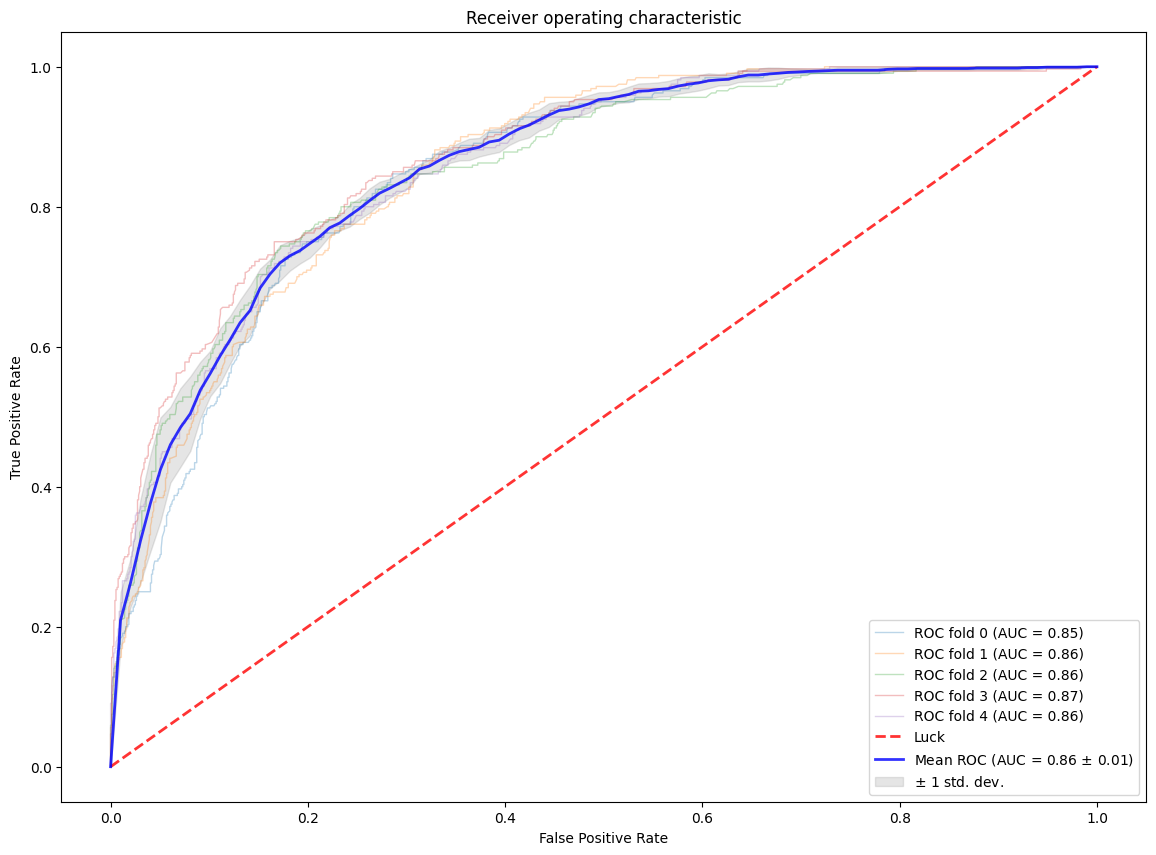

Accaracy list :  [0.7831715210355987, 0.7864077669902912, 0.7928802588996764, 0.8050161812297735, 0.7991902834008097]
equal opportunity for tpr :  [0.07720042417815484, 0.02792489167067888, 0.011331669242046039, 0.06275303643724695, 0.013788471415590031]
equal opportunity for fpr :  [0.007226107226107226, 0.03952697548756662, 0.03581640034842005, 0.003213117307991899, 0.011322862198147616]
odds difference list :  [0.042213265702131034, 0.03372593357912275, 0.023574034795233043, 0.03298307687261942, 0.012555666806868824]
The mean accuracy is  0.793 ± 0.008
The mean equal opportunity for tpr: (close to 0) 0.039 ± 0.027
The mean equal opportunity for fpr: (close to 0) 0.019 ± 0.015
The mean odds difference: (close to 0) 0.029 ± 0.010
The mean parity difference: (close to 0) 0.154 ± 0.064
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 184
---------------------------------------------------------------------------------------------------
Trial Number: 34
Values (

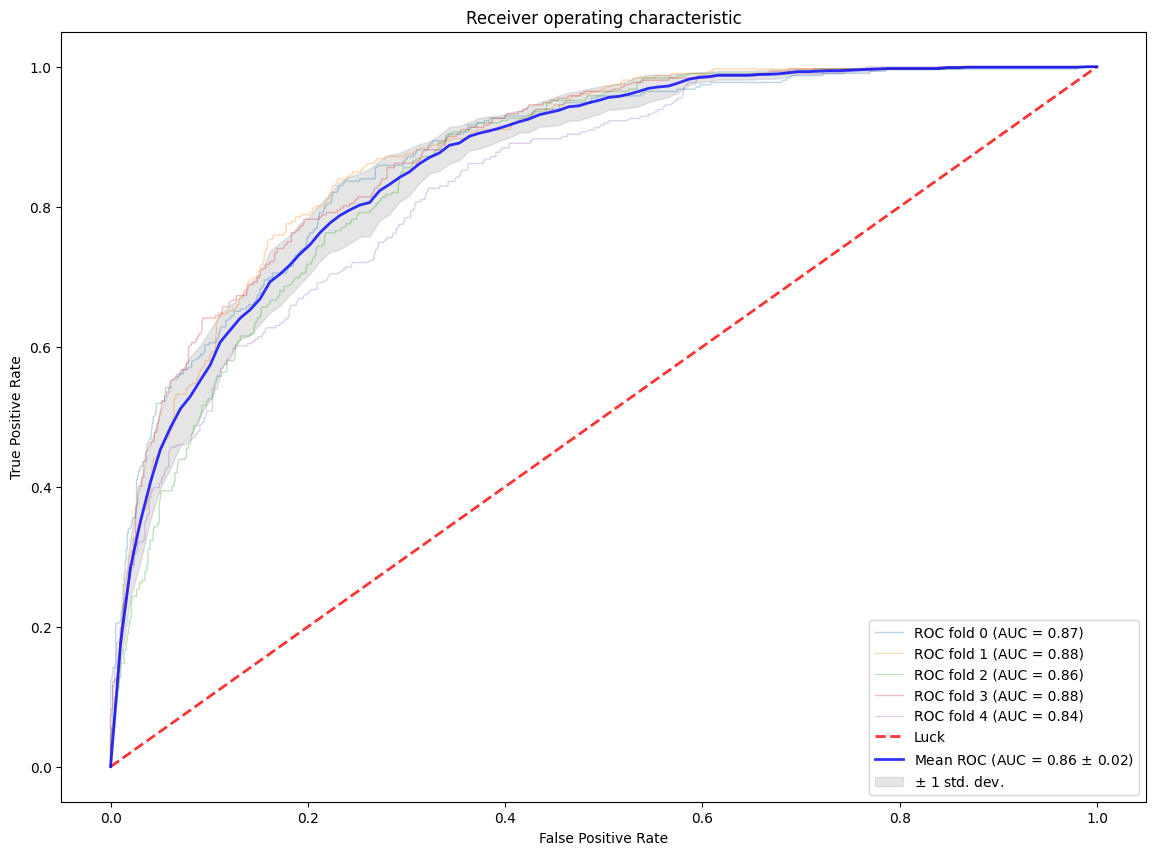

Accaracy list :  [0.794770206022187, 0.8074484944532488, 0.7844690966719493, 0.8009516256938938, 0.8009516256938938]
equal opportunity for tpr :  [0.048909218859957776, 0.021212248498340802, 0.08269329237071174, 0.021448181194234722, 0.0896038747621519]
equal opportunity for fpr :  [0.008559718378380859, 0.0012942844947471319, 0.021062271062271064, 0.006992877624641569, 0.004976373851248279]
odds difference list :  [0.02873446861916932, 0.011253266496543967, 0.051877781716491406, 0.014220529409438146, 0.047290124306700085]
The mean accuracy is  0.798 ± 0.008
The mean equal opportunity for tpr: (close to 0) 0.053 ± 0.029
The mean equal opportunity for fpr: (close to 0) 0.009 ± 0.007
The mean odds difference: (close to 0) 0.031 ± 0.017
The mean parity difference: (close to 0) 0.283 ± 0.131
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 34
---------------------------------------------------------------------------------------------------
Trial Number: 102
Value

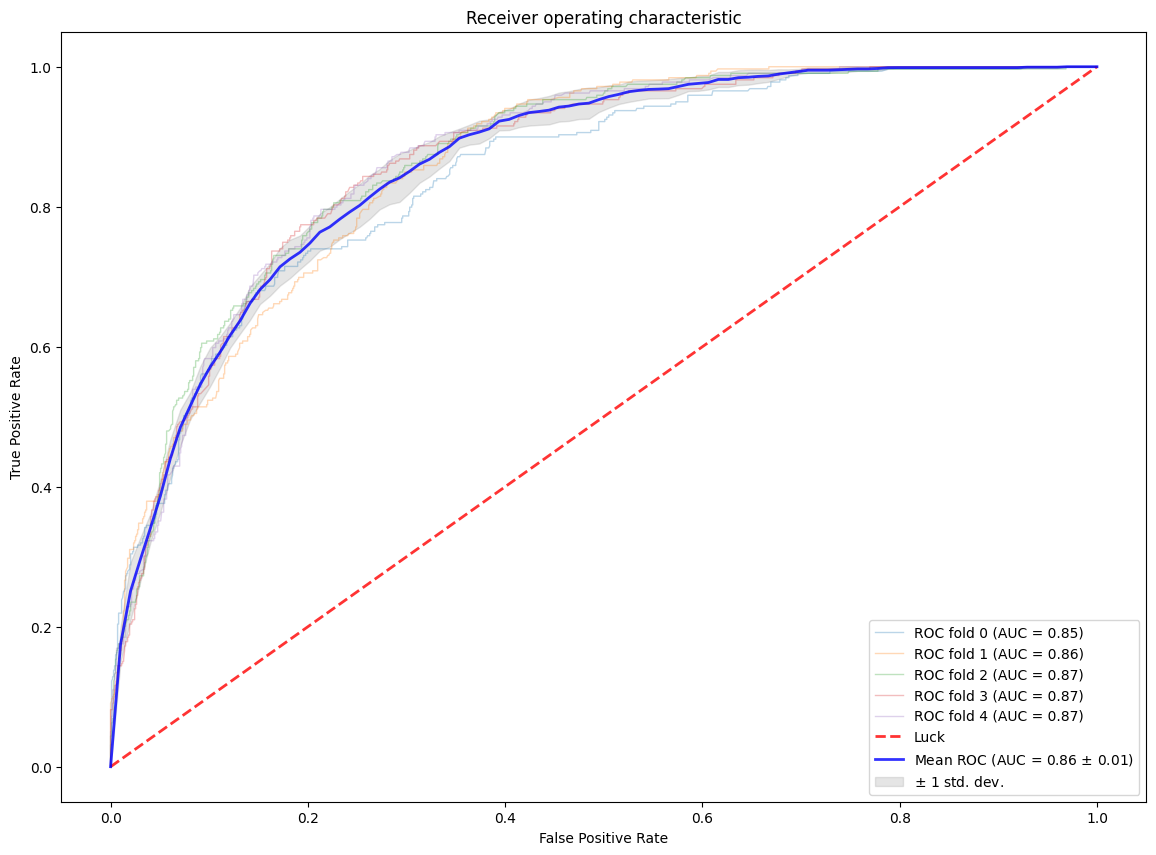

Accaracy list :  [0.7954022988505747, 0.8091954022988506, 0.7954022988505747, 0.7954022988505747, 0.7967791411042945]
equal opportunity for tpr :  [0.02926047727464373, 0.07408291557253124, 0.17008196721311475, 0.007058343533251715, 0.08084727948904519]
equal opportunity for fpr :  [0.009050024511371145, 0.0222598208281816, 0.03691792933670816, 0.010713273834820795, 0.03686705451411333]
odds difference list :  [0.019155250893007437, 0.04817136820035642, 0.10349994827491146, 0.008885808684036255, 0.05885716700157926]
The mean accuracy is  0.798 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.072 ± 0.056
The mean equal opportunity for fpr: (close to 0) 0.023 ± 0.012
The mean odds difference: (close to 0) 0.048 ± 0.033
The mean parity difference: (close to 0) 0.316 ± 0.147
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 102
---------------------------------------------------------------------------------------------------
Trial Number: 140
Values (Obj

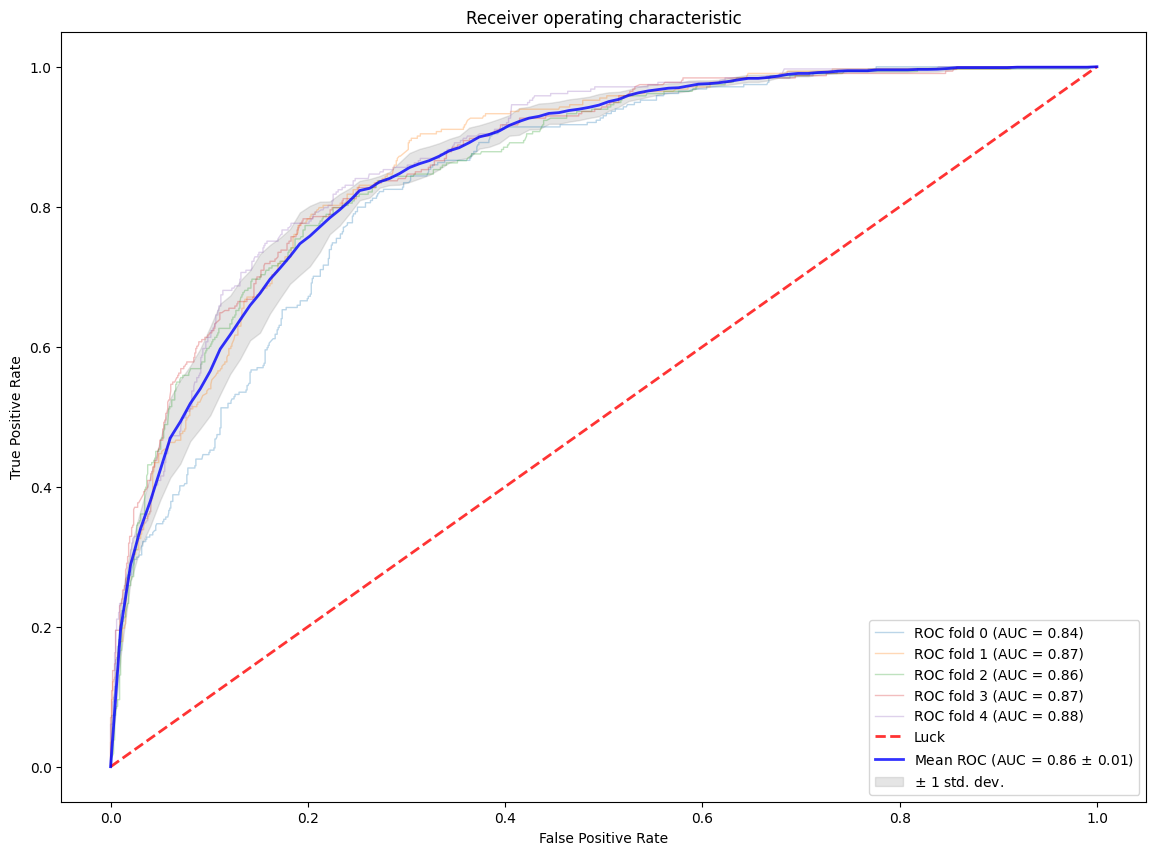

Accaracy list :  [0.8049344641480339, 0.8003084040092521, 0.7995373939861218, 0.8064764841942945, 0.8087895142636854]
equal opportunity for tpr :  [0.07089816124469592, 0.10161023947151113, 0.12573402417962, 0.0020425531914893547, 0.0131424744684413]
equal opportunity for fpr :  [0.022226872803690234, 0.025544677330391615, 0.029167656779935623, 0.009012644605864945, 0.007089041095890411]
odds difference list :  [0.046562517024193076, 0.06357745840095137, 0.07745084047977782, 0.00552759889867715, 0.010115757782165856]
The mean accuracy is  0.804 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.063 ± 0.048
The mean equal opportunity for fpr: (close to 0) 0.019 ± 0.009
The mean odds difference: (close to 0) 0.041 ± 0.029
The mean parity difference: (close to 0) 0.344 ± 0.156
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 140
---------------------------------------------------------------------------------------------------
Trial Number: 100
Values (Ob

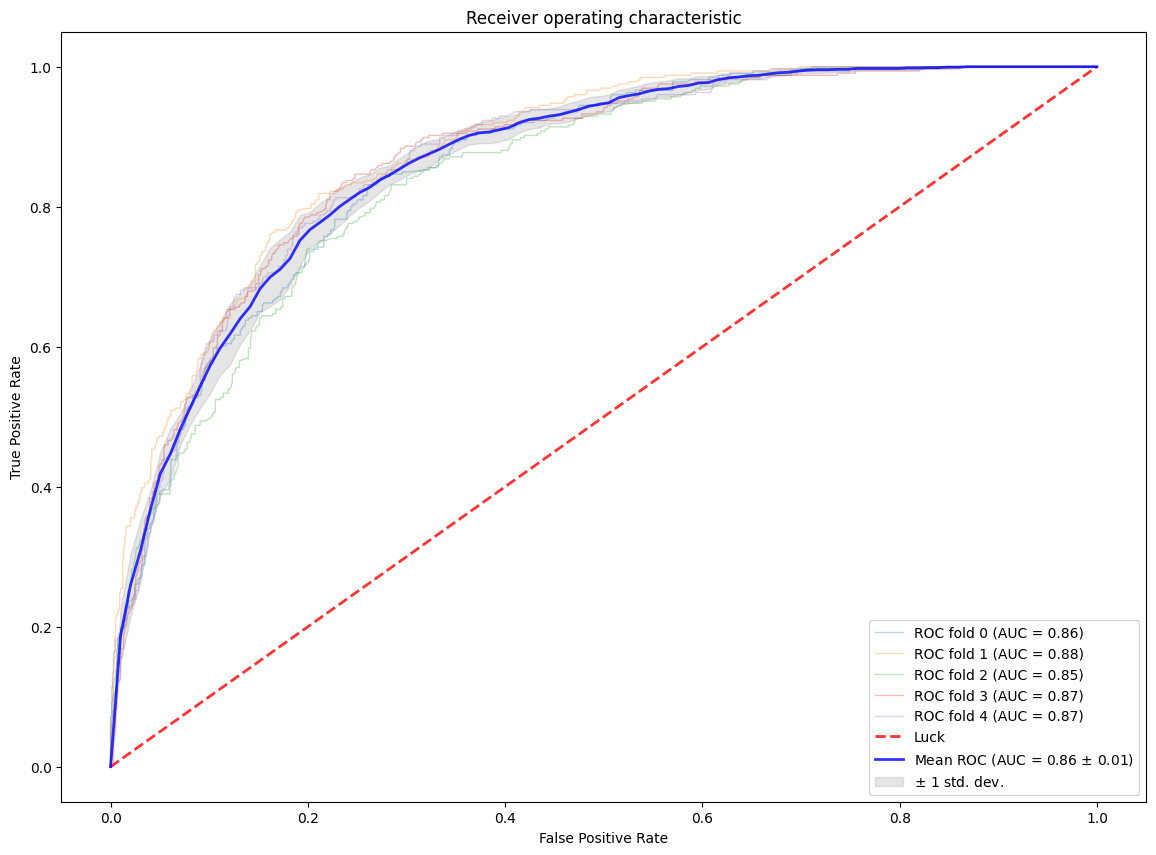

Accaracy list :  [0.79265493496557, 0.8231240428790199, 0.8085758039816233, 0.8001531393568146, 0.7924961715160797]
equal opportunity for tpr :  [0.0025541795665634803, 0.07268373691731356, 0.11126373626373626, 0.13292298102769876, 0.08452749436355994]
equal opportunity for fpr :  [0.008887322840811214, 0.013842746400885935, 0.0018119475835641635, 0.0033770176906156094, 0.025268964796005072]
odds difference list :  [0.005720751203687347, 0.04326324165909975, 0.05653784192365021, 0.06814999935915718, 0.054898229579782507]
The mean accuracy is  0.803 ± 0.011
The mean equal opportunity for tpr: (close to 0) 0.081 ± 0.044
The mean equal opportunity for fpr: (close to 0) 0.011 ± 0.008
The mean odds difference: (close to 0) 0.046 ± 0.021
The mean parity difference: (close to 0) 0.085 ± 0.040
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 100
---------------------------------------------------------------------------------------------------
Trial Number: 80
Values 

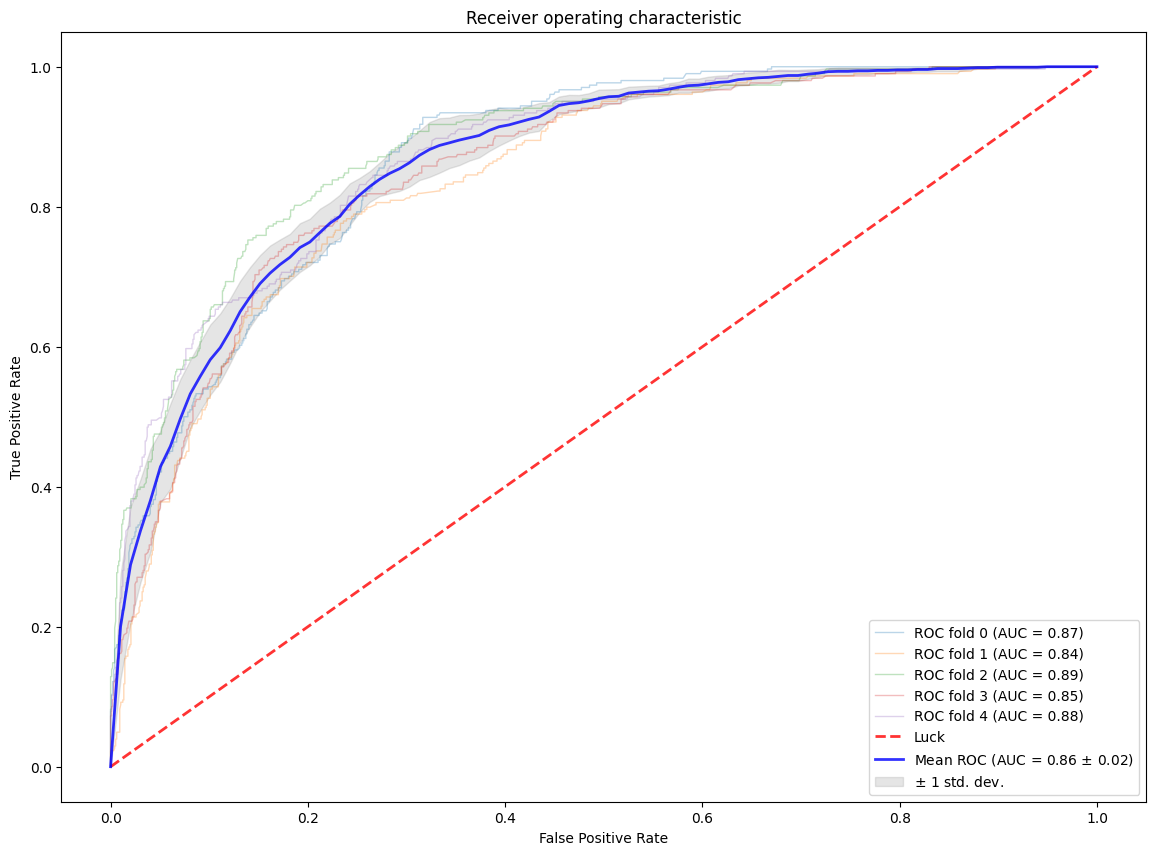

Accaracy list :  [0.7974882260596546, 0.7872841444270016, 0.805184603299293, 0.793401413982718, 0.8020424194815396]
equal opportunity for tpr :  [0.19642857142857142, 0.1972534332084894, 0.08918944481225763, 0.10309898242368178, 0.0968392120934494]
equal opportunity for fpr :  [0.020460358056265986, 0.03944497237180164, 0.010309278350515464, 0.01682324074450635, 0.01703872519111366]
odds difference list :  [0.1084444647424187, 0.11834920279014552, 0.04974936158138655, 0.05996111158409406, 0.056938968642281526]
The mean accuracy is  0.797 ± 0.006
The mean equal opportunity for tpr: (close to 0) 0.137 ± 0.049
The mean equal opportunity for fpr: (close to 0) 0.021 ± 0.010
The mean odds difference: (close to 0) 0.079 ± 0.029
The mean parity difference: (close to 0) 0.617 ± 0.132
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 80
---------------------------------------------------------------------------------------------------
Trial Number: 119
Values (Objectives

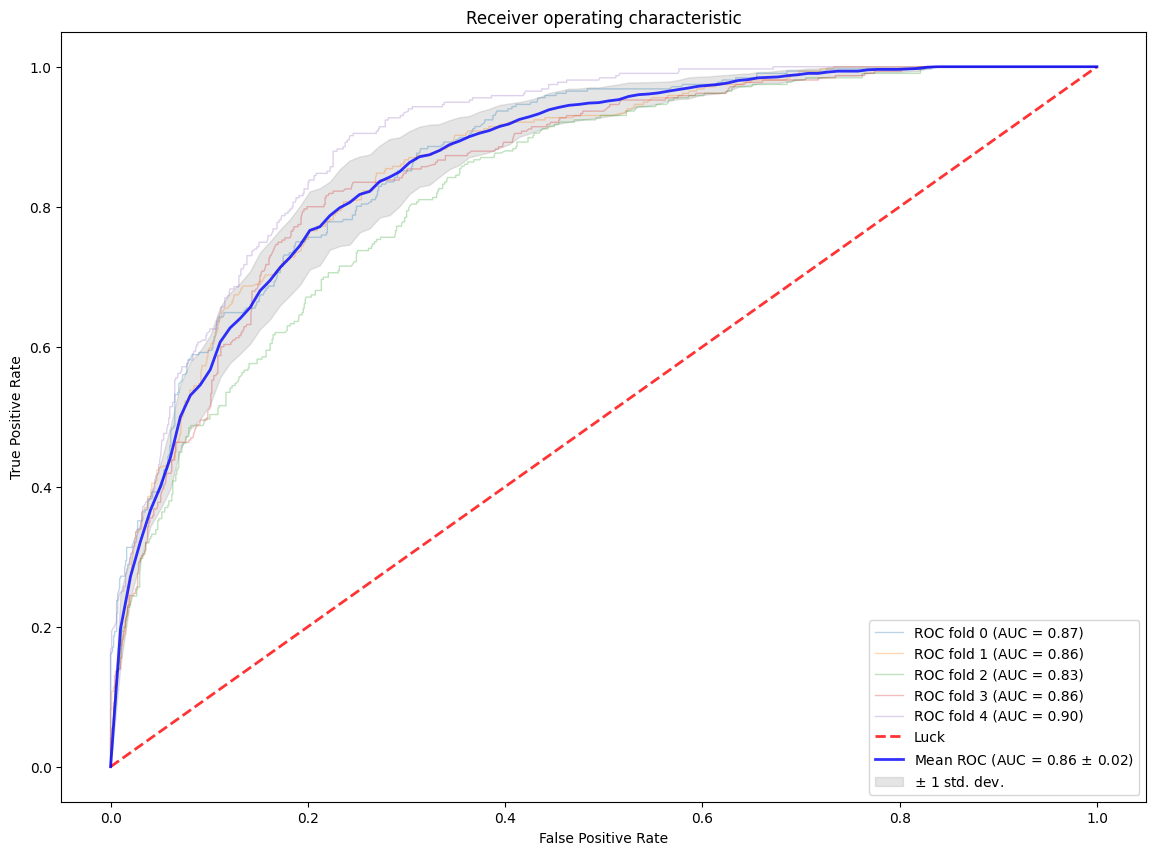

Accaracy list :  [0.806774441878368, 0.7959969207082371, 0.798306389530408, 0.7990762124711316, 0.8090839107005389]
equal opportunity for tpr :  [0.12130376344086022, 0.08311994472218837, 0.11602393617021275, 0.062362776558013866, 0.10582010582010581]
equal opportunity for fpr :  [0.009983361064891847, 0.014788684038864283, 0.025506921257651638, 0.011556927909757795, 0.024605727128298525]
odds difference list :  [0.06564356225287603, 0.048954314380526325, 0.0707654287139322, 0.03695985223388583, 0.06521291647420217]
The mean accuracy is  0.802 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.098 ± 0.022
The mean equal opportunity for fpr: (close to 0) 0.017 ± 0.007
The mean odds difference: (close to 0) 0.058 ± 0.013
The mean parity difference: (close to 0) 0.193 ± 0.154
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 119
---------------------------------------------------------------------------------------------------
Trial Number: 155
Values (Obj

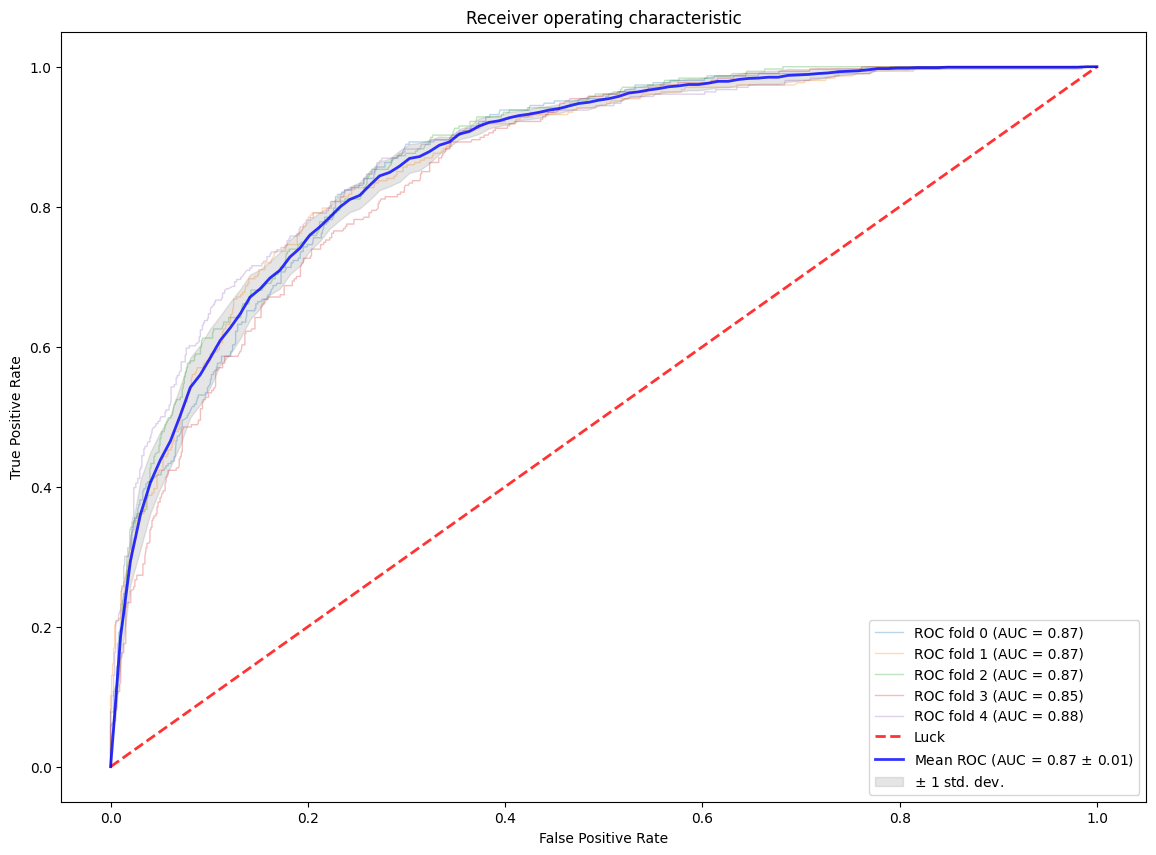

Accaracy list :  [0.8147859922178988, 0.8101167315175097, 0.8084112149532711, 0.7975077881619937, 0.8052959501557633]
equal opportunity for tpr :  [0.05266355140186918, 0.017724936852190565, 0.1661364439731354, 0.09897504456327985, 0.018211323476379382]
equal opportunity for fpr :  [0.01556944199964795, 0.021690282735813936, 0.01331733861854344, 0.03516706338711099, 0.012683250414593698]
odds difference list :  [0.034116496700758565, 0.01970760979400225, 0.08972689129583943, 0.06707105397519542, 0.01544728694548654]
The mean accuracy is  0.807 ± 0.006
The mean equal opportunity for tpr: (close to 0) 0.071 ± 0.056
The mean equal opportunity for fpr: (close to 0) 0.020 ± 0.008
The mean odds difference: (close to 0) 0.045 ± 0.029
The mean parity difference: (close to 0) 0.362 ± 0.137
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 155
---------------------------------------------------------------------------------------------------
Trial Number: 136
Values (Obj

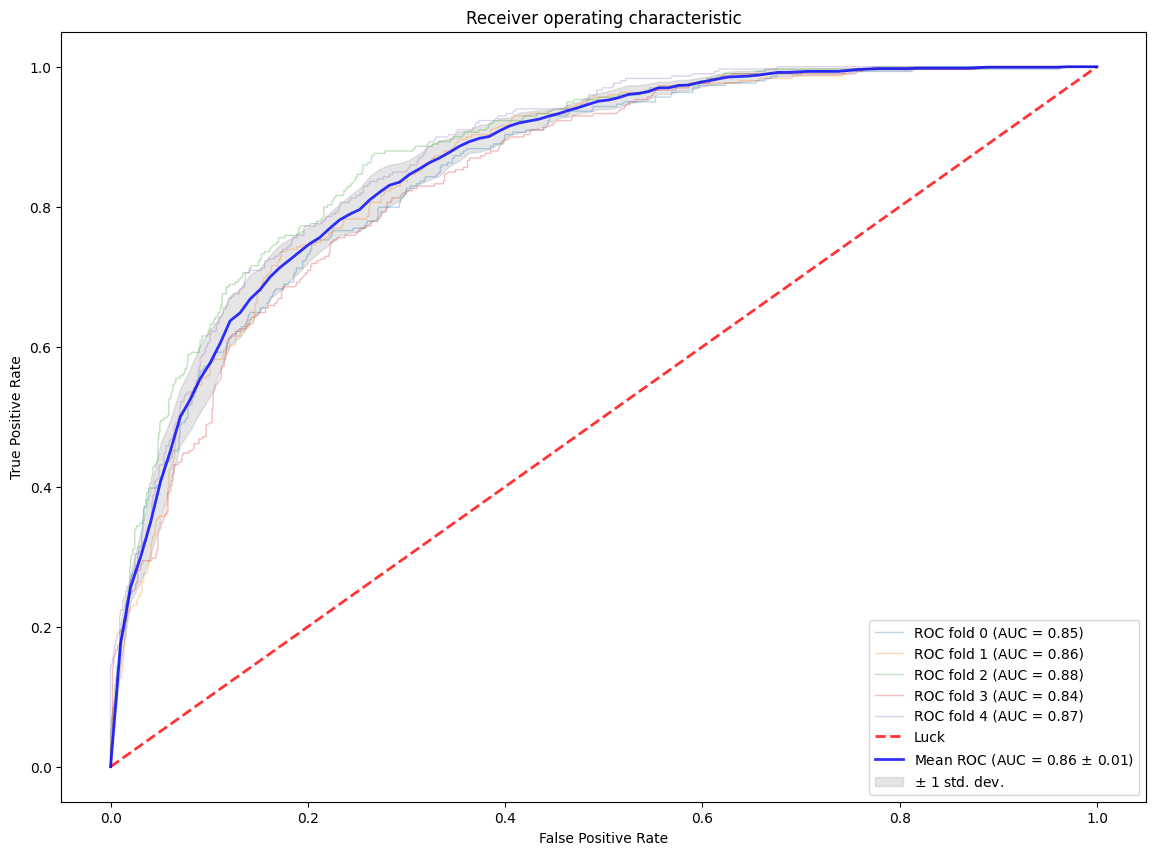

Accaracy list :  [0.8015625, 0.7984375, 0.79453125, 0.8, 0.8123534010946052]
equal opportunity for tpr :  [0.057239221820314795, 0.17791979253496343, 0.10683760683760685, 0.08974358974358973, 0.1623853211009174]
equal opportunity for fpr :  [0.002932589204971192, 0.03875968992248062, 0.02313624678663239, 0.01564559649666033, 0.03504043126684636]
odds difference list :  [0.030085905512642994, 0.10833974122872203, 0.06498692681211962, 0.05269459312012503, 0.09871287618388189]
The mean accuracy is  0.801 ± 0.006
The mean equal opportunity for tpr: (close to 0) 0.119 ± 0.045
The mean equal opportunity for fpr: (close to 0) 0.023 ± 0.013
The mean odds difference: (close to 0) 0.071 ± 0.029
The mean parity difference: (close to 0) 0.565 ± 0.150
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 136
---------------------------------------------------------------------------------------------------
Trial Number: 79
Values (Objectives): [0.10155626636557206, 0.8120249776

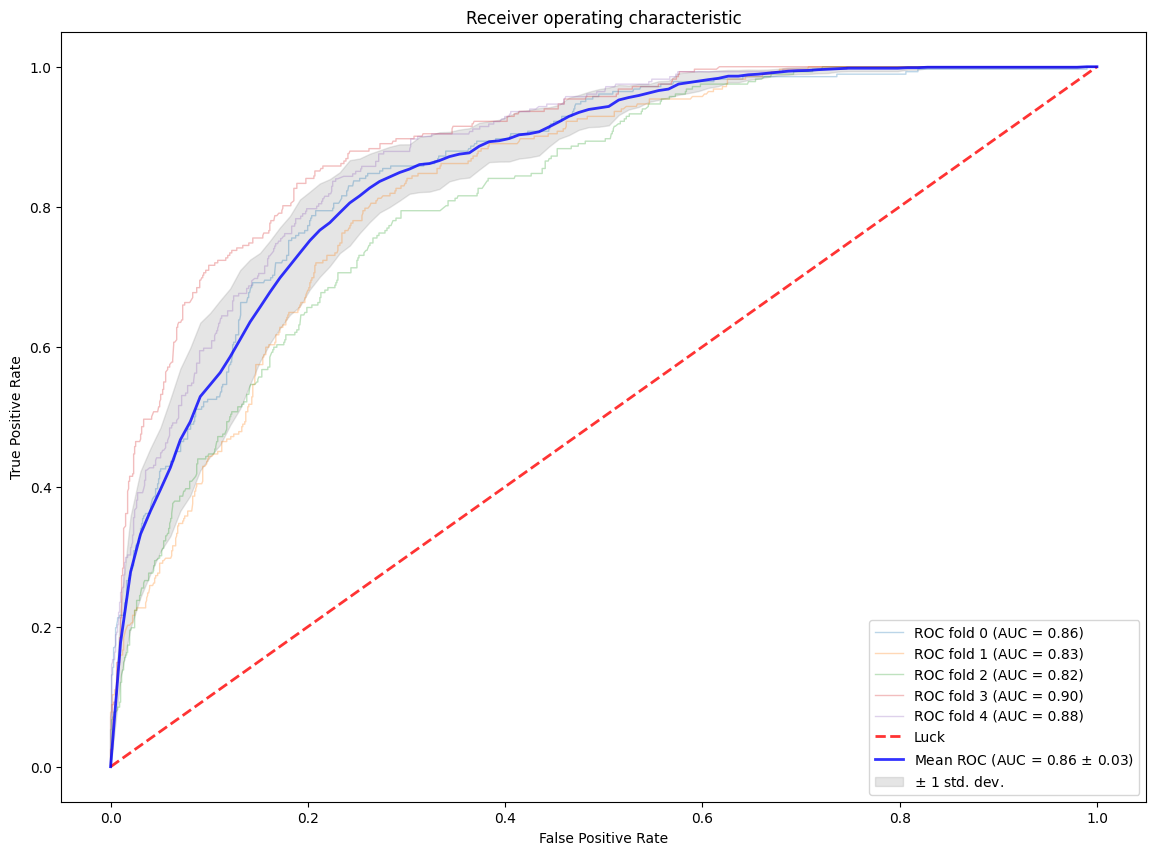

Accaracy list :  [0.8194006309148265, 0.8089976322020521, 0.7987371744277821, 0.819258089976322, 0.8161010260457774]
equal opportunity for tpr :  [0.24841463414634143, 0.2663769178404985, 0.14650537634408603, 0.16198054818744476, 0.24081237911025144]
equal opportunity for fpr :  [0.017721518987341773, 0.03926701570680628, 0.02110981695756782, 0.02594049232459054, 0.016260162601626018]
odds difference list :  [0.1330680765668416, 0.1528219667736524, 0.08380759665082693, 0.09396052025601764, 0.12853627085593872]
The mean accuracy is  0.812 ± 0.008
The mean equal opportunity for tpr: (close to 0) 0.213 ± 0.049
The mean equal opportunity for fpr: (close to 0) 0.024 ± 0.008
The mean odds difference: (close to 0) 0.118 ± 0.026
The mean parity difference: (close to 0) 0.834 ± 0.082
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 79
---------------------------------------------------------------------------------------------------
Trial Number: 160
Values (Objectives

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


conf matrix:
  [[367  15]
 [138  45]] 
accuracy:  0.7292035398230089 precision:  0.75 recall:  0.2459016393442623 fpr:  0.03926701570680628 tpr:  0.2459016393442623 fn+fp 153


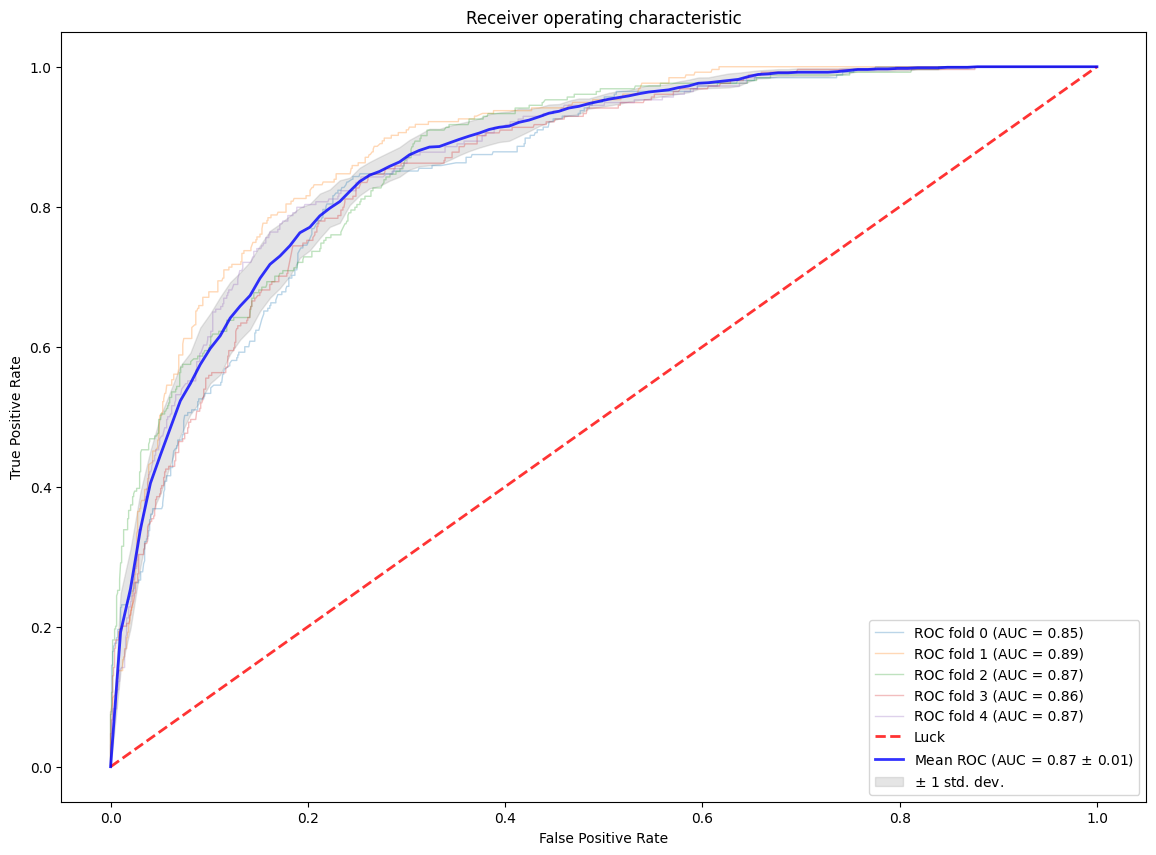

Accaracy list :  [0.8258064516129032, 0.8192090395480226, 0.8297013720742534, 0.8264729620661824, 0.8208232445520581]
equal opportunity for tpr :  [0.22058823529411764, 0.12133775566611388, 0.17863464942661433, 0.273224043715847, 0.21773262525975526]
equal opportunity for fpr :  [0.015665796344647518, 0.043478260869565216, 0.006056916886839697, 0.02956989247311828, 0.03926701570680628]
odds difference list :  [0.11812701581938258, 0.08240800826783955, 0.09234578315672702, 0.15139696809448266, 0.12849982048328076]
The mean accuracy is  0.824 ± 0.004
The mean equal opportunity for tpr: (close to 0) 0.202 ± 0.050
The mean equal opportunity for fpr: (close to 0) 0.027 ± 0.014
The mean odds difference: (close to 0) 0.115 ± 0.025
The mean parity difference: (close to 0) 0.909 ± 0.073
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 160
---------------------------------------------------------------------------------------------------
Trial Number: 182
Values (Object

<ipython-input-4-2890afd092be>:5: RuntimeWarning: invalid value encountered in scalar divide
  'precision: ', tp/(tp+fp),


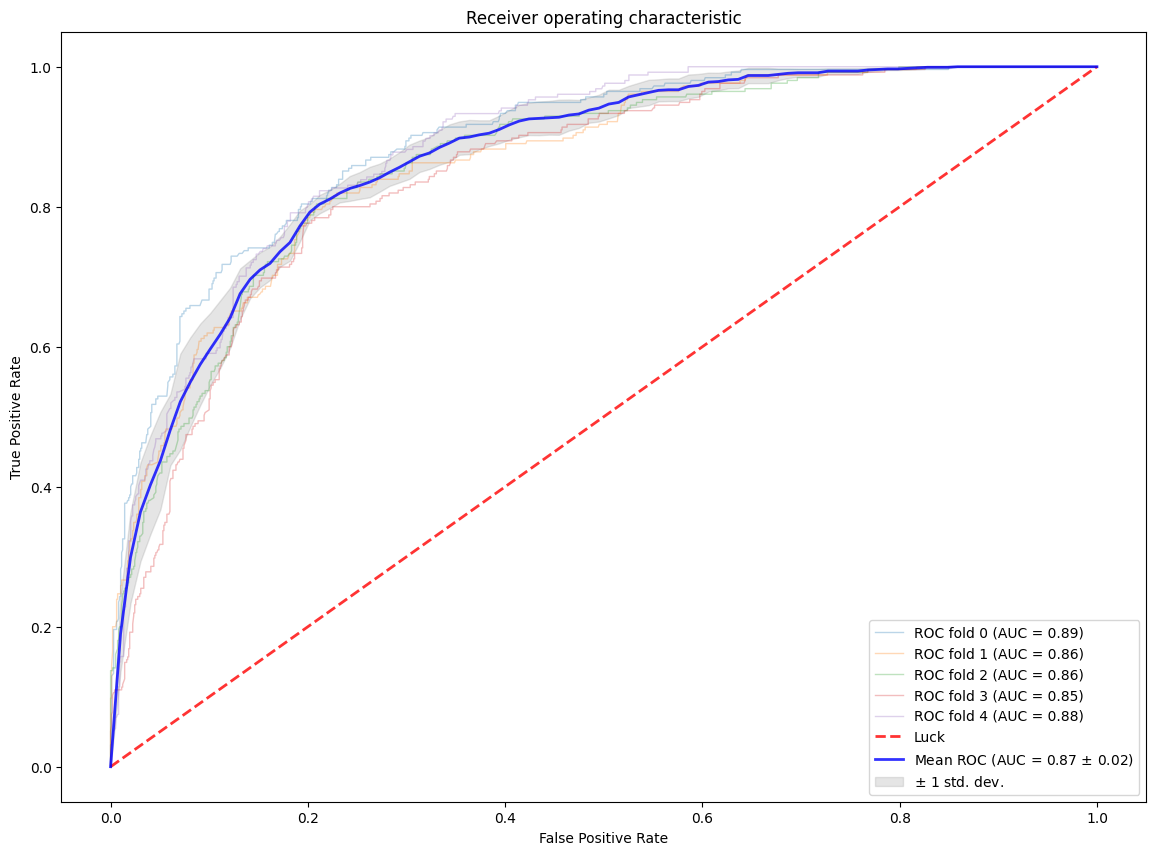

Accaracy list :  [0.8310428455941795, 0.8381877022653722, 0.8276699029126213, 0.808252427184466, 0.8171521035598706]
equal opportunity for tpr :  [0.253301019555407, 0.21750992063492064, 0.2538706739526412, 0.15789473684210525, 0.16670391061452514]
equal opportunity for fpr :  [0.014352553542009885, 0.01837270341207349, 0.020887728459530026, 0.031413612565445025, 0.030379746835443037]
odds difference list :  [0.13382678654870844, 0.11794131202349706, 0.1373792012060856, 0.09465417470377514, 0.09854182872498408]
The mean accuracy is  0.824 ± 0.011
The mean equal opportunity for tpr: (close to 0) 0.210 ± 0.041
The mean equal opportunity for fpr: (close to 0) 0.023 ± 0.007
The mean odds difference: (close to 0) 0.116 ± 0.018
The mean parity difference: (close to 0) 0.928 ± 0.053
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 182
---------------------------------------------------------------------------------------------------
Trial Number: 178
Values (Objectiv

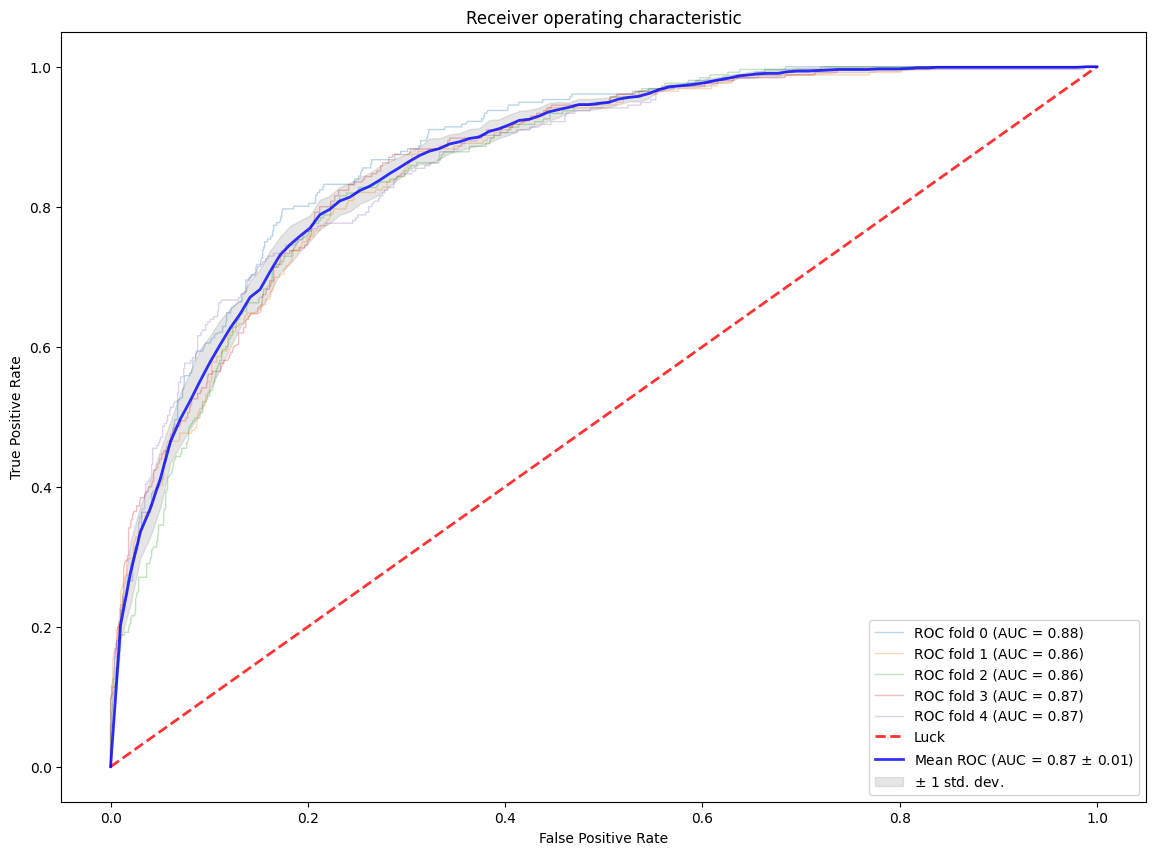

Accaracy list :  [0.8309178743961353, 0.8323932312651088, 0.8186946011281225, 0.8259468170829976, 0.8251410153102336]
equal opportunity for tpr :  [0.24514118078474512, 0.19006497244839216, 0.16894353369763204, 0.2357670578009561, 0.21707060063224448]
equal opportunity for fpr :  [0.03299492385786802, 0.022222222222222223, 0.012119435920422026, 0.016304347826086956, 0.013850415512465374]
odds difference list :  [0.13906805232130656, 0.10614359733530719, 0.09053148480902704, 0.12603570281352153, 0.11546050807235493]
The mean accuracy is  0.827 ± 0.005
The mean equal opportunity for tpr: (close to 0) 0.211 ± 0.028
The mean equal opportunity for fpr: (close to 0) 0.019 ± 0.008
The mean odds difference: (close to 0) 0.115 ± 0.017
The mean parity difference: (close to 0) 0.908 ± 0.058
The mean disperate impact: (close to 1) 1.000 ± 0.000
End Of Trial Number: 178
---------------------------------------------------------------------------------------------------


In [38]:
# Record the end time
end_time = time.time()
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60

pareto_front_trials = study.best_trials
pareto_front_trials = sorted(pareto_front_trials, key=lambda trial: trial.values[0])


trail_list = []
fairness_values_list = []

acc_values_list = []
growth_list = []

# Process each trial in the Pareto front
for trial in pareto_front_trials:
   trail_list.append(trial.number)
   fairness_values_list.append(trial.values[0])
   acc_values_list.append(trial.values[1])

   lambda1 = trial.params['lambda_0']
   lambda2 = trial.params['lambda_1']
   upsampled_df = Upsampling_Dataset(lambda1,lambda2)
   growth_list.append((len(upsampled_df) - len(orig_data))/ len(orig_data) * 100 )

   print("Trial Number:", trial.number)
   print("Values (Objectives):", trial.values)
   print("Parameters:", trial.params)
   print("Dataset Growth Percent :", (len(upsampled_df) - len(orig_data))/ len(orig_data) * 100)
   print('---------------------------------------------------------------------------------------------------')
   y_debias = upsampled_df[TARGET_COL]
   upsampled_df_features = upsampled_df.loc[:, feature_columns]
   upsampled_acc ,upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff , upsampled_dis_impact  = fairness_metrics_roc_auc_std(upsampled_df_features, y_debias )

   print("End Of Trial Number:", trial.number)
   print('---------------------------------------------------------------------------------------------------')




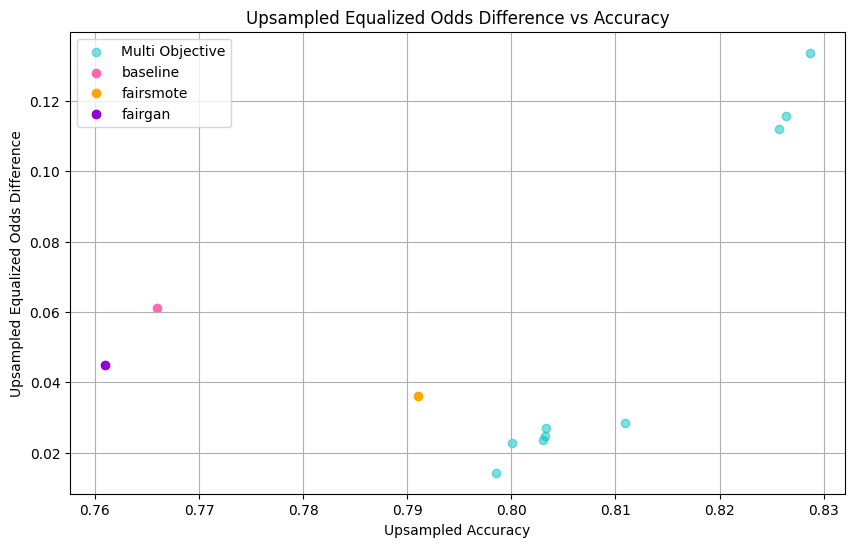

In [34]:
import matplotlib.pyplot as plt

# Plot upsampled_op_diff against upsampled_acc
plt.figure(figsize=(10, 6))
plt.scatter(acc_values_list,fairness_values_list, alpha=0.5,color = 'c', label = 'Multi Objective')

# Add the three additional points
plt.scatter(0.766, 0.061, color='hotpink', label='baseline')  # Baseline point
plt.scatter(0.791, 0.036, color='orange', label='fairsmote')  # Fairsmote point
plt.scatter(0.761, 0.045, color='darkviolet', label='fairgan')  # Fairgan point

plt.xlabel('Upsampled Accuracy')
plt.ylabel('Upsampled Equalized Odds Difference')
plt.title('Upsampled Equalized Odds Difference vs Accuracy')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()

conf matrix:
  [[529  17]
 [161  93]] 
accuracy:  0.7775 precision:  0.8454545454545455 recall:  0.3661417322834646 fpr:  0.031135531135531136 tpr:  0.3661417322834646 fn+fp 178
conf matrix:
  [[367  15]
 [118  81]] 
accuracy:  0.7710843373493976 precision:  0.84375 recall:  0.40703517587939697 fpr:  0.03926701570680628 tpr:  0.40703517587939697 fn+fp 133
conf matrix:
  [[162   2]
 [ 43  12]] 
accuracy:  0.7945205479452054 precision:  0.8571428571428571 recall:  0.21818181818181817 fpr:  0.012195121951219513 tpr:  0.21818181818181817 fn+fp 45
conf matrix:
  [[526  20]
 [169  85]] 
accuracy:  0.76375 precision:  0.8095238095238095 recall:  0.3346456692913386 fpr:  0.03663003663003663 tpr:  0.3346456692913386 fn+fp 189
conf matrix:
  [[158  10]
 [ 54  14]] 
accuracy:  0.7288135593220338 precision:  0.5833333333333334 recall:  0.20588235294117646 fpr:  0.05952380952380952 tpr:  0.20588235294117646 fn+fp 64
conf matrix:
  [[368  10]
 [115  71]] 
accuracy:  0.7783687943262412 precision:  0.

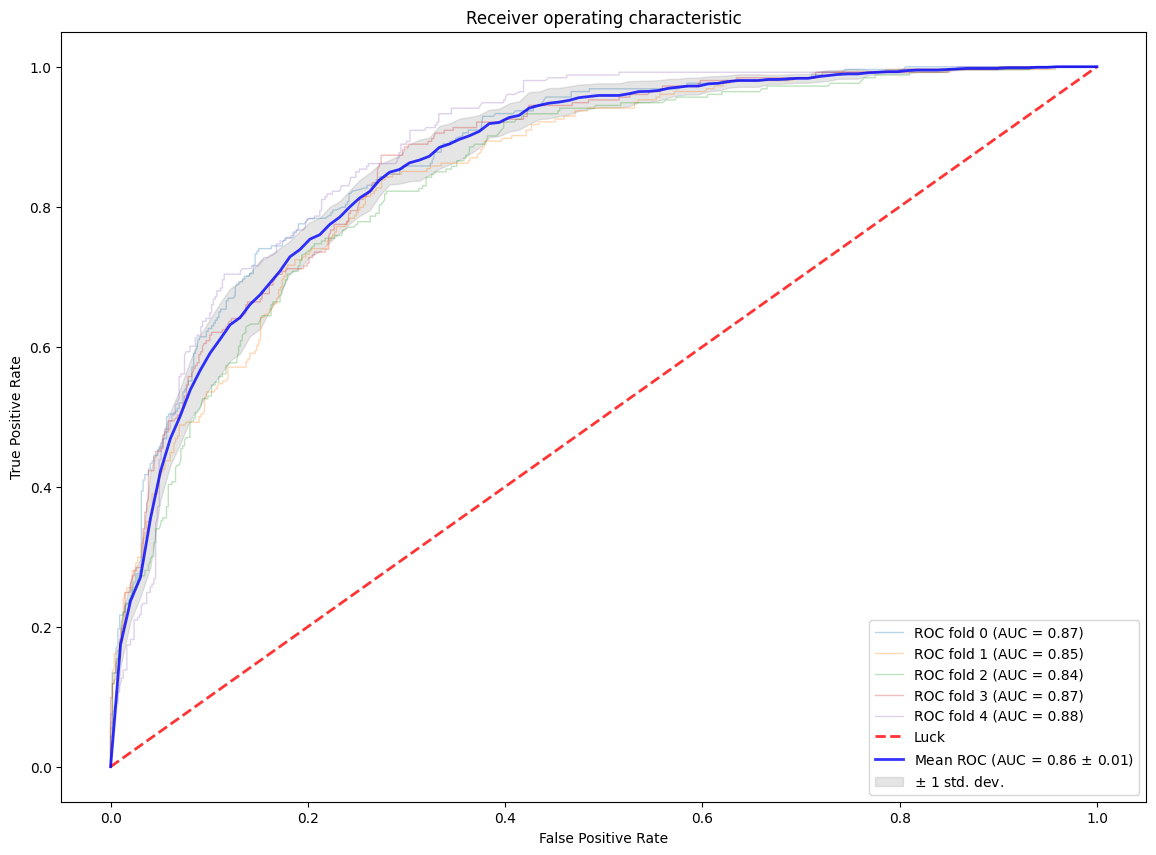

Accaracy list :  [0.7775, 0.76375, 0.75125, 0.7775, 0.745]
equal opportunity for tpr :  [0.1888533576975788, 0.17583807716635041, 0.06750380517503807, 0.11128775834658189, 0.10873440285204991]
equal opportunity for fpr :  [0.02707189375558677, 0.03306878306878307, 0.007937285644292018, 0.009090618609406957, 0.004696176423925114]
odds difference list :  [0.10796262572658279, 0.10445343011756675, 0.037720545409665046, 0.060189188477994426, 0.05671528963798751]
The mean accuracy is  0.763 ± 0.013
The mean equal opportunity for tpr: (close to 0) 0.130 ± 0.045
The mean equal opportunity for fpr: (close to 0) 0.016 ± 0.011
The mean odds difference: (close to 0) 0.073 ± 0.028
The mean parity difference: (close to 0) 0.581 ± 0.085
The mean disperate impact: (close to 1) 1.000 ± 0.000


In [35]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig )

In [36]:
print('Running time is: ',elapsed_time_minutes)

Running time is:  5.0085642298062645
